In [8]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [24]:
!pwd

/nas/xd/projects/transformers/notebooks


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter, namedtuple
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce, partial
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# sys.path.insert(0, '/nas/xd/projects/transformers/src')
from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers.models.gpt_neo.modeling_gpt_neo import GPTNeoSelfAttention
from transformers.models.gptj.modeling_gptj import GPTJAttention
from transformers.models.xglm.modeling_xglm import XGLMAttention

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
# from transformers.trainer_utils import EvaluationStrategy

In file_utils.py: default_cache_path = /raid/xd/.cache/torch/transformers


In [3]:
import einops
from einops import rearrange

In [4]:
# from child_utils import *
from common_utils import *
from child_tasks import *
from model_utils import *

In [5]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [819]:
# model_name = "EleutherAI/gpt-neo-1.3B"
for model_name in ['gpt2-large', 
            'gpt2-xl', 'EleutherAI/gpt-neo-1.3B',  # = babbage
            'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', # = curie 
            'KoboldAI/fairseq-dense-13B']:
    if model_name not in models:
        with Timer(model_name):
            model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)  
            tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
            models[model_name] = model, tokenizer

In [820]:
models.keys()

dict_keys(['gpt2-large', 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B'])

In [1003]:
# model_name = 'roberta-large'
# model_name = 'EleutherAI/gpt-j-6B'  # medium / large /xl
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
_ = model.eval()

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<extra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [1004]:
unify(model)
blocks = model.transformer.h
attn = blocks[0].attn
L, H, embed_dim = len(blocks), attn.num_heads, attn.embed_dim
# L, H, embed_dim = len(blocks), attn.num_attention_heads, attn.embed_dim #gpt-j
all_attrs, all_embs = defaultdict(dict), defaultdict(dict)

In [662]:
we = model.transformer.wte.weight.t()
wp = model.transformer.wpe.weight.t()
wu = model.lm_head.weight

ModuleAttributeError: 'GPTJModel' object has no attribute 'wpe'

In [823]:
# k, n = 5, 4
# bos_id, eos_id = tokenizer._convert_token_to_id('Ġ->'), tokenizer._convert_token_to_id('Ċ')
# l = [bos_id] + choices(range(1, tokenizer.vocab_size-1), k=k) + [eos_id]
# text = tokenizer.decode(l * n)
# examples = text.strip().split('\n')
# print(text)
from transformers.models.gptj.modeling_gptj import GPTJAttention, GPTJBlock

In [824]:
def forward(model, inputs, labels=None, loss_reduction='None', by_head=False, attribute_layer=None, 
            head_mask=None, mlp_mask=None, attn_weights=None,
            hidden_states=None, detach_layer=None, 
            separate_qkv_layer=None, get_hqkv=None):
    head_mask = fill_list(head_mask, L, attribute_layer)
    mlp_mask = fill_list(mlp_mask, L, attribute_layer)
    attn_weights = fill_list(attn_weights, L, attribute_layer)
    # get_hqkv_fns = fill_list(get_hqkv, L, separate_qkv_layer, default_get_hqkv)
    from_layer = attribute_layer if hidden_states is not None else None

    self = model.transformer
    (hidden_states, inputs_embeds, position_embeds) = embed_forward(self, inputs) \
        if from_layer is None else (hidden_states, None, None)
    all_hidden_states, intermediates, mlp_outputs = (), (), ()
    attn_forward_outputs = []
    for i, b in enumerate(self.h):
        if from_layer is not None and i < from_layer: continue
        if i == detach_layer: hidden_states = hidden_states.detach()
        all_hidden_states += (hidden_states,)
        # hq, hk, hv = get_hqkv_fns[i](hidden_states)
        hq = hk = hv = b.ln_1(hidden_states)
        attn_forward_output = attn_forward(b, hq, hk, hv, by_head=by_head,
                                    head_mask=head_mask[i], attn_weights=attn_weights[i])
        attn_forward_outputs.append(attn_forward_output)
        if not my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_forward_output[0]
        mlp_output, intermediate = mlp_forward(b, hidden_states, output_intermediate=True)
        if mlp_mask[i] is not None: mlp_output = einsum('bie,bi->bie', mlp_output, mlp_mask[i])
        intermediates += (intermediate,)
        mlp_outputs += (mlp_output,)
        if my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_forward_output[0]
        hidden_states = hidden_states + mlp_output
    attn_outputs, all_attentions, head_inputs, head_outputs = zip(*attn_forward_outputs)
    all_hidden_states += (hidden_states,) # both before and after ln_f
    hidden_states = self.ln_f(hidden_states)
    all_hidden_states += (hidden_states,)

    logits = model.lm_head(hidden_states)
    loss = compute_loss(logits, labels, reduction=loss_reduction) if labels is not None else None
    return Outputs(
        inputs_embeds=inputs_embeds, position_embeds=position_embeds,
        attn_outputs=attn_outputs, head_inputs=head_inputs, head_outputs=head_outputs, 
        intermediates=intermediates, mlp_outputs=mlp_outputs,
        hidden_states=all_hidden_states, attentions=all_attentions, 
        logits=logits, loss=loss,
    )

In [739]:
# nrows, ncols = 2, 3
# text, examples = make_input_str(tasks[0], nrows=nrows, ncols=ncols)
text = "\u003CInduction example. Goobledegook. Goobledegook"  # from unseal
bos_token, eos_token = '.', None
examples = text.split(bos_token)[1:]
k_shot = 1
print(text)
inputs = tokenizer.encode_plus(text, return_tensors='pt')
inputs = prepare_inputs(inputs, model.device)
input_ids = inputs.input_ids
qlen = input_ids.size(1)
# tokenize without tokenization artifact -> needed for visualization, from unseal
tokens = tokenizer.tokenize(text)
tokens = list(map(tokenizer.convert_tokens_to_string, map(lambda x: [x], tokens))) 

<Induction example. Goobledegook. Goobledegook


In [1005]:
text = "a c d -> c\nb f e -> f\nt y u -> y\nq w e -> w\nz x c -> x\n"
bos_token, eos_token = 'Ġ->', 'Ċ'
examples = text.split('->')[1:]
k_shot = 1
print(text)
inputs = tokenizer.encode_plus(text, return_tensors='pt')
inputs = prepare_inputs(inputs, model.device)
input_ids = inputs.input_ids
qlen = input_ids.size(1)
# tokenize without tokenization artifact -> needed for visualization, from unseal
tokens = tokenizer.tokenize(text)
tokens = list(map(tokenizer.convert_tokens_to_string, map(lambda x: [x], tokens))) 
bos_indices, eos_indices, answers, labels = locate_answers(input_ids, tokenizer, bos_token=bos_token, eos_token=eos_token)

a c d -> c
b f e -> f
t y u -> y
q w e -> w
z x c -> x



In [962]:
examples =['a c d -> c','b f e -> f','t y u -> y','q w e -> w','z x c -> x']

In [1006]:
# bos_indices, eos_indices, answers, labels = locate_answers(input_ids, tokenizer, bos_token=bos_token, eos_token=eos_token)
# with torch.no_grad(): o2 = model(**inputs, output_attentions=True, output_hidden_states=True)
with torch.no_grad(): o = forward(model, inputs, labels=labels, by_head=True, loss_reduction='none')

In [929]:
answers
labels

[tensor([269]), tensor([277]), tensor([331]), tensor([266]), tensor([2124])]

tensor([[-100, -100, -100,  269, -100, -100, -100, -100, -100,  277, -100, -100,
         -100, -100, -100,  331, -100, -100, -100, -100, -100,  266, -100, -100,
         -100, -100, -100, 2124, -100, -100]])

In [964]:
 a =model.transformer(inputs.input_ids)

In [965]:
a.last_hidden_state.shape

torch.Size([1, 30, 1600])

In [966]:
o.hidden_states[-1].shape

torch.Size([1, 30, 1600])

In [967]:
# a.last_hidden_state.mean()

In [968]:
(a.last_hidden_state - o.hidden_states[-1]).abs().mean()

tensor(3.8309e-07, grad_fn=<MeanBackward0>)

In [1007]:
loss, _ = show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
                sep='\n', loss_reduction='none', show_range=range(k_shot, len(examples)))

* f 0.323 {' f': 0.323, ' e': 0.244, ' d': 0.142, ' b': 0.106, ' c': 0.086} 
  f
t y u 
* y 0.491 {' y': 0.491, ' t': 0.234, ' u': 0.137, ' g': 0.011, ' (': 0.011} 
  y
q w e 
* w 0.569 {' w': 0.569, ' e': 0.167, ' q': 0.16, ' u': 0.031, ' y': 0.012} 
  w
z x c 
* x 0.753 {' x': 0.753, ' z': 0.12, ' w': 0.04, ' c': 0.036, ' q': 0.011} 
  x



In [41]:
# 看前传到哪层就够预测出结果了（26层左右）
layer_out = L
for i in range(0, L - 2):
    h = o.hidden_states[i]
    # h = h + attn_forward(blocks[-2], h, h, h)[0]
    # h = h + mlp_forward(blocks[-2], h)
    # h = h + attn_forward(blocks[-1], h, h, h)[0]
    # h = h + mlp_forward(blocks[-1], h)
    h = model.transformer.ln_f(h)
    # h = h[0, dst]
    logits = model.lm_head(h)
    print(i)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, logits, 
        bos_indices, eos_indices, answers, labels, sep='\n', show_range=range(k_shot, len(examples)))
    if all_top1_correct and layer_out == L: layer_out = i
    # print(i, show_topk(*logits.softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens))
    # if logits.argmax() == input_ids[0, dst + 1] and layer_out == L: layer_out = i
print(layer_out)

0
  Goobledegook
 ĠGo 0.0 {'.': 0.0, ',': 0.0, '."': 0.0, ';': 0.0, '-': 0.0}
 ob 0.0 {'ĠGo': 0.0, 'Go': 0.0, 'ĠGO': 0.0, 'go': 0.0, 'GO': 0.0}
 led 0.0 {'ob': 0.001, 'obl': 0.0, 'obs': 0.0, 'oby': 0.0, 'obe': 0.0}
 eg 0.0 {'led': 0.001, 'ling': 0.0, 'Led': 0.0, 'ledged': 0.0, 'les': 0.0}
 ook 0.0 {'eg': 0.002, 'EG': 0.0, 'ega': 0.0, 'egu': 0.0, 'Ġeg': 0.0}
1
  Goobledegook
 ĠGo 0.0 {'ĠUntil': 0.0, 'ĠAnd': 0.0, 'ĠGiven': 0.0, 'ĠSpend': 0.0, 'ĠOne': 0.0}
 ob 0.0 {'ĠGone': 0.004, 'ji': 0.003, 'ĠGo': 0.003, 'Go': 0.003, 'ĠBetter': 0.002}
 led 0.0 {'ob': 0.18, 'obe': 0.007, 'obs': 0.006, 'obo': 0.004, 'viously': 0.003}
 eg 0.0 {'led': 0.023, 'ering': 0.003, 'ling': 0.002, 'ging': 0.002, 'ged': 0.001}
 ook 0.0 {'eg': 0.399, 'entric': 0.006, 'ohyd': 0.005, 'eson': 0.002, 'oard': 0.002}
2
  Goobledegook
 ĠGo 0.0 {'ĠSpend': 0.002, 'ĠBeh': 0.002, 'ĠDag': 0.001, 'ĠDupl': 0.001, 'ĠFol': 0.001}
 ob 0.001 {'verning': 0.024, 'ji': 0.008, 'backs': 0.007, 'ĠBetter': 0.007, 'eg': 0.006}
 led 0.0 {'ob':

In [834]:
# 对layer normal scale
def scaled_ln(ln, x):
    self = ln
    mean = x.mean(dim=-1, keepdim=True)
    var = ((x - mean) ** 2).mean(dim=-1, keepdim=True)
    std = (var + self.eps).sqrt()
    std = std[-1:].detach()  # use the std of the last original (unscaled) example in the batch
    y = (x - mean) * self.weight / std + self.bias
    return y

In [835]:
def sum_forward(model, outputs, labels=None, loss_reduction='per_example_mean', embed_mask=None, mlp_mask=None, head_mask=None, attn_weights=None, ln_scale=0.1):
    embed_output = outputs.hidden_states[0]
    if embed_mask is not None: embed_output = einsum('bie,bi->bie', embed_output, embed_mask)
    output = embed_output

    head_outputs = rearrange(list(outputs.head_outputs), 'l 1 n i e -> 1 l n i e')
    if head_mask is not None:
#         print(head_mask.shape,head_outputs.shape)
        head_outputs = einsum('blni,blnie->blnie', head_mask, head_outputs)
    elif attn_weights is not None:
        head_inputs = rearrange(list(outputs.head_inputs), 'l 1 n i e -> 1 l n i e')
        head_outputs = einsum('blnij,blnje->blnie', attn_weights, head_inputs)
    attn_outputs = torch.einsum('blnie->blie', head_outputs)

    mlp_outputs = rearrange(list(outputs.mlp_outputs), 'l 1 i e -> 1 l i e')
    if mlp_mask is not None: mlp_outputs = einsum('blie,bli->blie', mlp_outputs, mlp_mask)
    output = output + torch.einsum('blie->bie', attn_outputs + mlp_outputs)

    logits, loss = None, None
    if labels is not None:
        ln_output = scaled_ln(model.transformer.ln_f, output)
        logits = model.lm_head(ln_output)
        loss = compute_loss(logits, labels, reduction=loss_reduction)
    return Outputs(hidden_states=(output,), logits=logits, loss=loss)

In [836]:
def attribute(forward_fn, x, get_y, num_points=20, batch_size=20):
    scaled_x, grad = {}, {}
    for key in x:
        scaled_x[key] = scaled_input(x[key], num_points)
        grad[key] = torch.zeros_like(x[key])
    ys = []
    for i in range(0, num_points, batch_size):
        scaled_x_ = OrderedDict({key: scaled_x[key][i: i + batch_size] for key in x})
        o = forward_fn(model, **scaled_x_)
        print(o.hidden_states[0].shape)
        y = get_y(o); ys.append(y)
        # print(f'y = {y}, ys = {ys}')
        grad_ = torch.autograd.grad(y.flatten().unbind(), list(scaled_x_.values()))
        for j, key in enumerate(x.keys()): grad[key] += grad_[j].sum(dim=0, keepdim=True)
    attr = {key: (grad[key] / num_points * x[key]).squeeze(0) for key in x}
    return attr, torch.cat(ys)

In [837]:
def get_x(key, outputs, to_layer=None):
#     L, H = len(outputs.hidden_states), outputs.attentions[0].size(1)
    # L dim removed when doing per-layer attribution
    if key == 'head_mask': x = torch.ones(1, L, H, outputs.hidden_states[0].size(1))
    elif key == 'mlp_mask': x = torch.ones(1, L, outputs.hidden_states[0].size(1))
    elif key == 'embed_mask': x = torch.ones(1, outputs.hidden_states[0].size(1))
    elif key == 'attn_weights': x = rearrange(list(outputs.attentions), 'l 1 n i j -> 1 l n i j')
    if to_layer is not None and x.size(1) == L: x[:, to_layer:] = 0
    return x

In [838]:
def binarize(a, fraction=0.33):
    b = torch.zeros_like(a)
    prev_v = None
    for r, c, v in zip(*topk_md(a, 20)):
        if prev_v is not None and abs(v) < abs(prev_v) * fraction: break
        b[r, c] = 1; prev_v = v
    return b

In [839]:
def get_head_weights(model, layer, head):
    m = model.transformer.h[layer].attn
    # wq = m.q_proj.weight.view(H, -1, embed_dim)[head]
    # wk = m.k_proj.weight.view(H, -1, embed_dim)[head]
    # wv = m.v_proj.weight.view(H, -1, embed_dim)[head]
    # wo = m.out_proj.weight.view(embed_dim, H, -1)[:, head]
    wq, wk, wv = [rearrange(getattr(m, name).weight, '(n d) e -> n d e', n=H)[head] # d e
                for name in ['q_proj', 'k_proj', 'v_proj']]
    wo = rearrange(getattr(m, 'out_proj').weight, 'e (n d) -> n e d', n=H)[head]  # e d
    return wq.data, wk.data, wv.data, wo.data

def combine_weights(weights, qk=True, with_embedding=False, BA=False):
    wq, wk, wv, wo = weights
    wqt = wq.t()
    if with_embedding:
        wqt, wk = we.t().mm(wqt), wk.mm(we)
        wo, wv = wu.mm(wo), wv.mm(we)
    if BA: return wk.mm(wqt) if qk else wv.mm(wo)
    return wqt.mm(wk) if qk else wo.mm(wv)

In [1011]:
# bos_indices
# k_shot =4

# labels[:, :bos_indices[k_shot] + 1] = -100  # 只算k_shot个示例后的loss
# labels
k_shot =4
labels[:, :bos_indices[k_shot]] = -100
labels

tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, 2124, -100, -100]])

In [756]:
L


28

In [841]:
labels

tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, 2124, -100, -100]])

In [1015]:
# keys = ['head_mask', 'mlp_mask', 'embed_mask'] # 对head_output归因，看哪些head重要（先运行，粗粒度）
keys = ['attn_weights', 'mlp_mask', 'embed_mask']  # 对attn_weights归因，看哪些head的哪些关注重要（后运行，细粒度）
forward_fn = partial(sum_forward, outputs=o, labels=labels)
x = OrderedDict((key, get_x(key, o)) for key in keys)
def get_y(outputs): return -outputs.loss
attr, ys = attribute(forward_fn, x, get_y)
ys
# attrs, yss = [], []
# for l in tqdm(range(0, layer_out)):
#     attr, ys = attribute(l, key, o, multiply_x=False)
#     attrs.append(attr); yss.append(ys)

torch.Size([20, 30, 4096])


tensor([-8.6845, -7.8092, -6.9596, -6.1372, -5.3449, -4.5866, -3.8690, -3.2015,
        -2.5964, -2.0670, -1.6237, -1.2695, -0.9975, -0.7941, -0.6433, -0.5307,
        -0.4454, -0.3792, -0.3267, -0.2841], grad_fn=<CatBackward>)

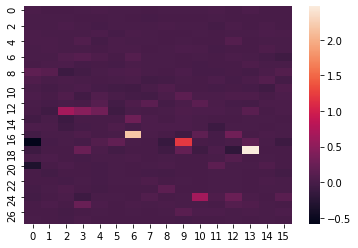

In [1013]:
head_attr = torch.einsum('lni->ln', attr['head_mask'])
_ = sns.heatmap(head_attr, cbar=True)

In [979]:
L

48

In [1021]:
list(zip(*topk_md(head_attr, 10)))

[(18, 13, 2.4655323),
 (16, 6, 2.1607635),
 (17, 9, 1.1983489),
 (13, 2, 0.66549575),
 (24, 10, 0.65004075),
 (13, 3, 0.45677605),
 (16, 12, 0.29596582),
 (13, 4, 0.28596193),
 (14, 6, 0.27321222),
 (18, 3, 0.24843416)]

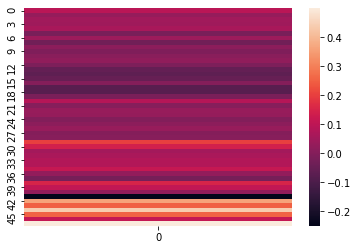

In [976]:
mlp_attr = torch.einsum('li->l', attr['mlp_mask'])
_ = sns.heatmap(mlp_attr.unsqueeze(-1), cbar=True)

18 13 2.4655323


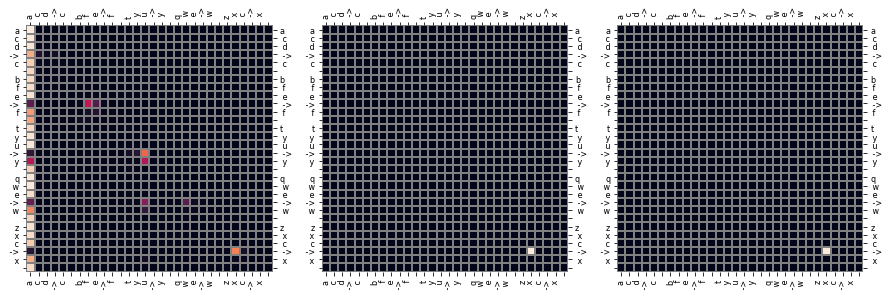

16 6 2.1607635


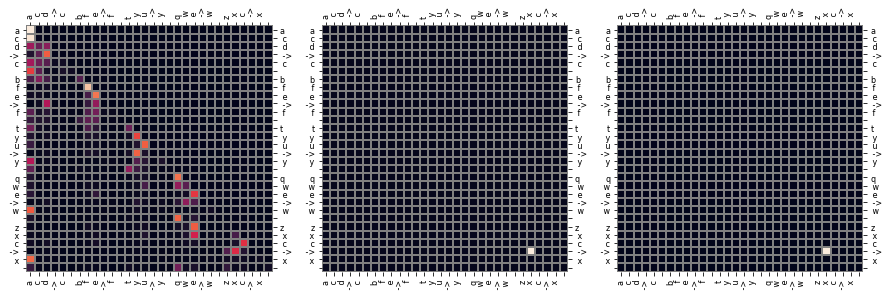

17 9 1.1983489


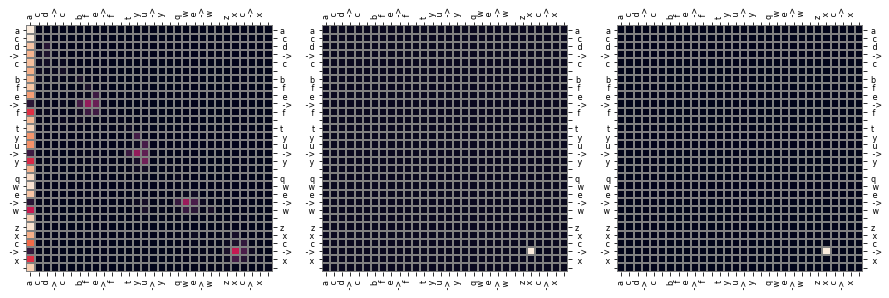

13 2 0.66549575


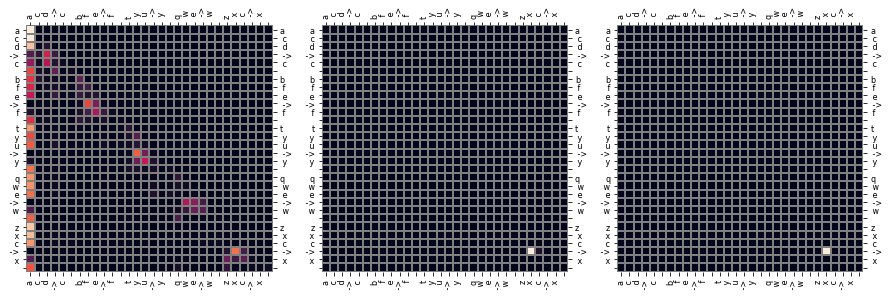

24 10 0.65004075


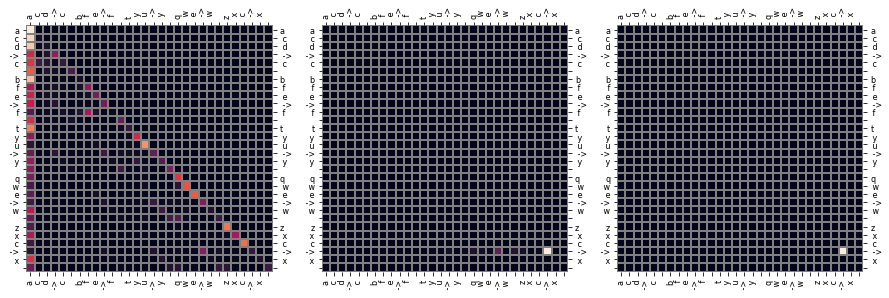

13 3 0.45677605


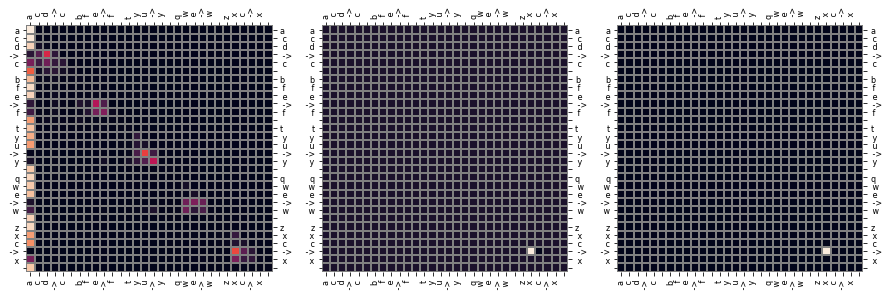

16 12 0.29596582


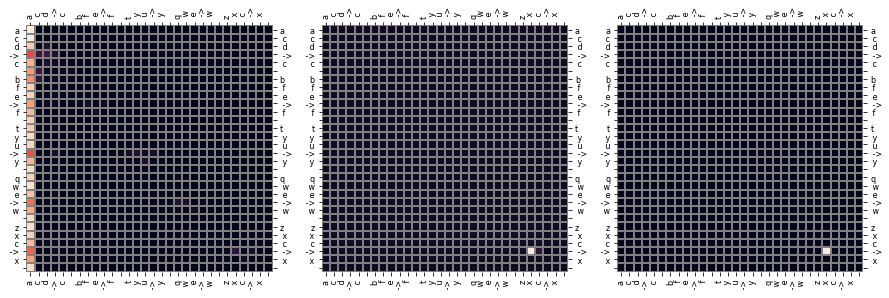

13 4 0.28596193


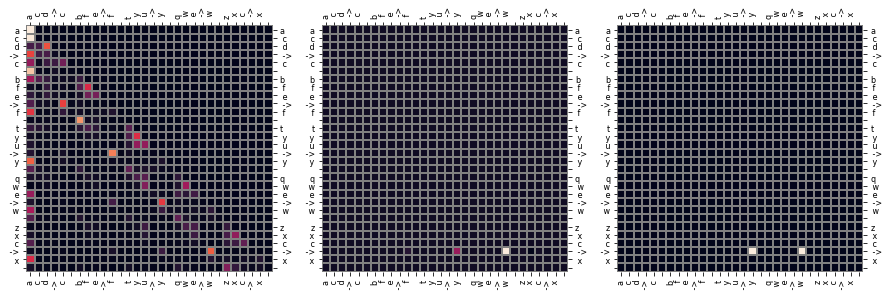

14 6 0.27321222


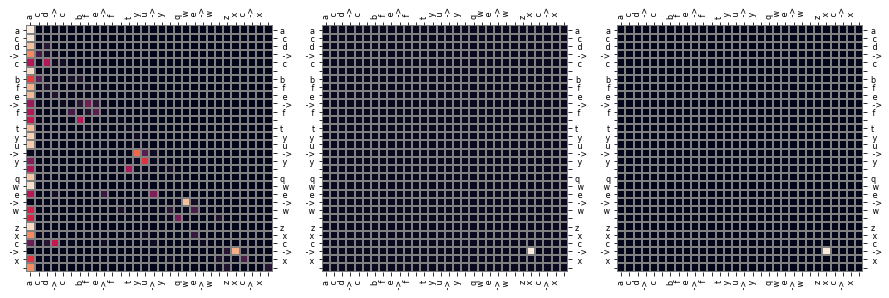

18 3 0.24843416


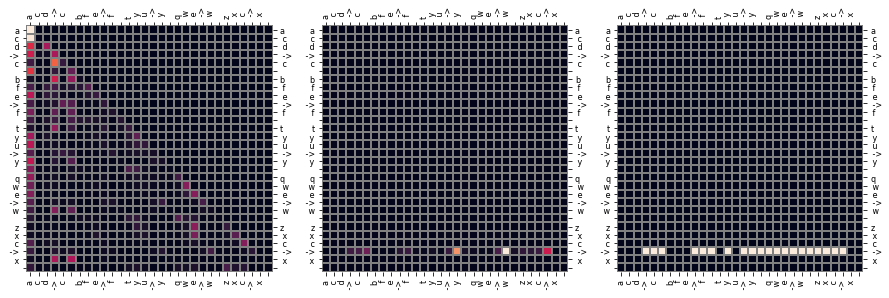

In [1016]:
# 对attn_weights归因后运行
attn_attr = attr['attn_weights']
attentions = torch.cat(o.attentions)

for l, h, v in zip(*topk_md(head_attr, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attr[l, h], binarize(attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

以上用归因找到对最终预测结果起重要作用的上层heads（induction heads），  
以下用归因找到对上层induction heads的attn_weights起重要作用的下层heads（Q-compostion or K-composition with induction heads）

In [1022]:
layer, head, _ = list(zip(*topk_md(head_attr, 10)))[0]
layer, head
wq, wk = get_head_weights(model, layer, head)[:2]

(18, 13)

In [770]:
input_ids
tokens = tokenizer.tokenize(text)
print(tokens)

tensor([[  64,  269,  288, 4613,  269,  198,   65,  277,  304, 4613,  277,  198,
           83,  331,  334, 4613,  331,  198,   80,  266,  304, 4613,  266,  198,
           89, 2124,  269, 4613, 2124,  198]])

['a', 'Ġc', 'Ġd', 'Ġ->', 'Ġc', 'Ċ', 'b', 'Ġf', 'Ġe', 'Ġ->', 'Ġf', 'Ċ', 't', 'Ġy', 'Ġu', 'Ġ->', 'Ġy', 'Ċ', 'q', 'Ġw', 'Ġe', 'Ġ->', 'Ġw', 'Ċ', 'z', 'Ġx', 'Ġc', 'Ġ->', 'Ġx', 'Ċ']


In [983]:
labels

tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, 2124, -100, -100]])

In [1023]:
def head_forward(model, o, hidden_states, layer, head, labels=None, loss_reduction='per_example_mean', attn_weights=None, ln_scale=0.1):
    blocks = model.transformer.h
    ln_f = model.transformer.ln_f
    hq = scaled_ln(blocks[layer].ln_1, hidden_states) #batch,seq_len,hidden_size
#     hq =hidden_states
    hk = hv = blocks[layer].ln_1(o.hidden_states[layer])
    attn_weights = attn_forward(blocks[layer], hq, hk, hv)[1]  # bnij
    return Outputs(loss= attn_weights[:, head, 27, 25]) #->为什么能够关注x
   

In [1030]:
# keys = ['head_mask', 'mlp_mask', 'embed_mask'] # 对head_output归因，看哪些head重要（先运行，粗粒度）
keys = ['attn_weights', 'mlp_mask', 'embed_mask']  # 对attn_weights归因，看哪些head的哪些关注重要（后运行，细粒度）
forward_fn = partial(sum_forward, outputs=o, labels=labels, ln_scale=0.1)
x = OrderedDict((key, get_x(key, o, to_layer=layer)) for key in keys)
# def get_y(outputs): return -outputs.loss
def get_y(outputs): 
    return head_forward(model, o, outputs.hidden_states[0], layer, head, 
        labels=labels, loss_reduction='argmax', ln_scale=0.1).loss

attr_twolayer, ys = attribute(forward_fn, x, get_y, num_points=4, batch_size=4)
print(ys)

torch.Size([4, 30, 4096])
tensor([0.1161, 0.3048, 0.5456, 0.7348], grad_fn=<CatBackward>)


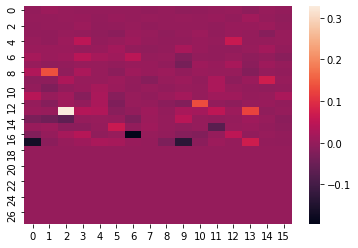

In [1028]:
head_attr_twolayer = torch.einsum('lni->ln', attr_twolayer['head_mask'])
_ = sns.heatmap(head_attr_twolayer, cbar=True)

In [1029]:
list(zip(*topk_md(head_attr_twolayer, 10)))

[(13, 2, 0.32714438),
 (8, 1, 0.13710745),
 (12, 10, 0.13179228),
 (13, 13, 0.12263214),
 (9, 14, 0.07185429),
 (17, 13, 0.06956253),
 (15, 5, 0.0640797),
 (4, 12, 0.061904255),
 (13, 11, 0.049681123),
 (16, 12, 0.048331305)]

13 2 0.32714438


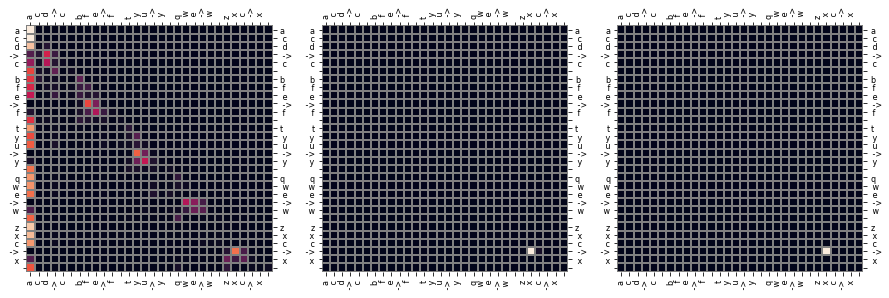

8 1 0.13710745


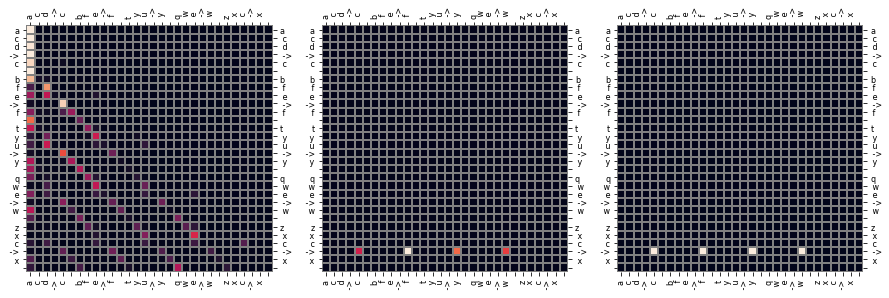

12 10 0.13179228


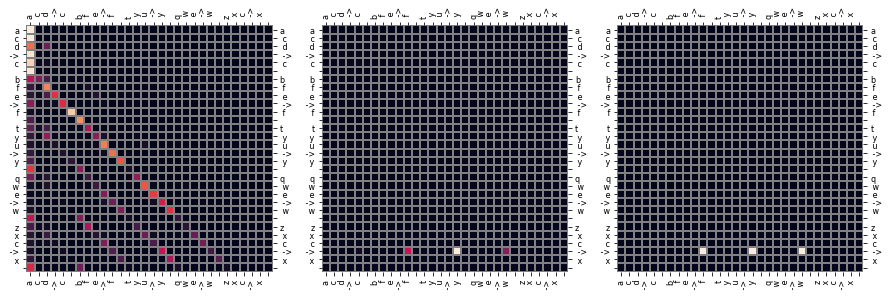

13 13 0.12263214


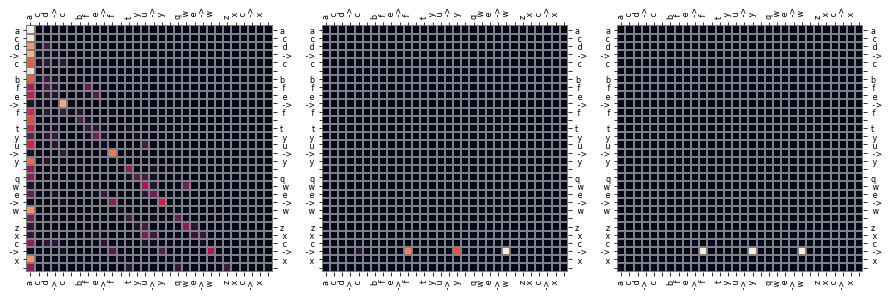

9 14 0.07185429


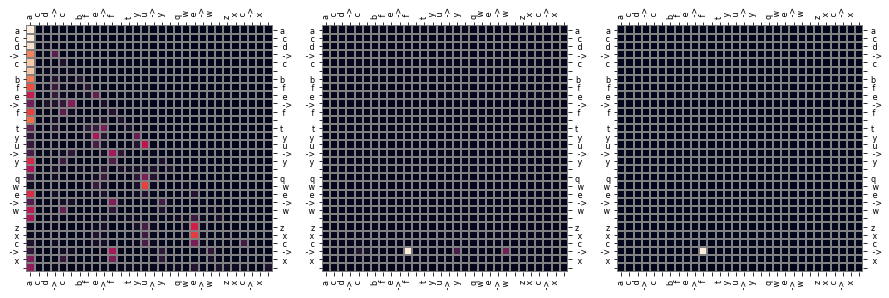

17 13 0.06956253


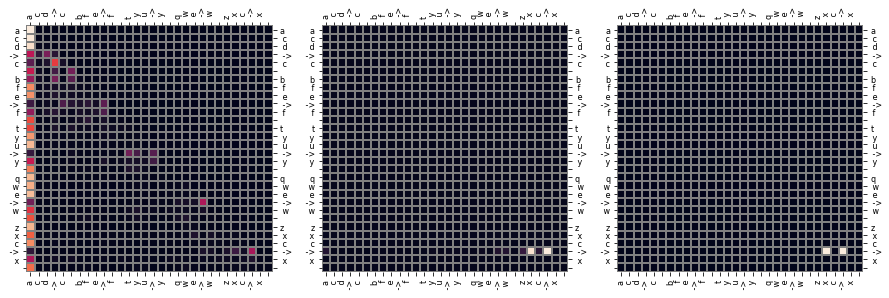

15 5 0.0640797


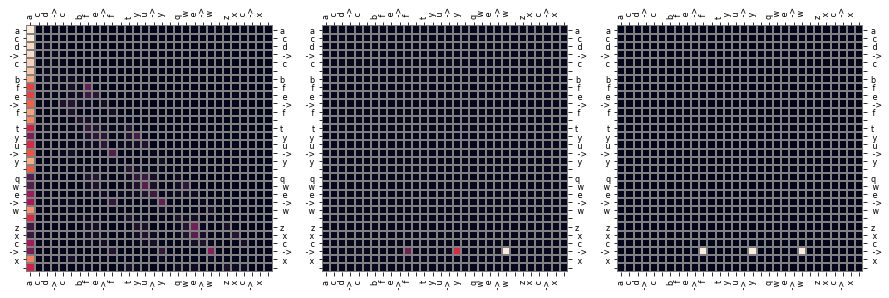

4 12 0.061904255


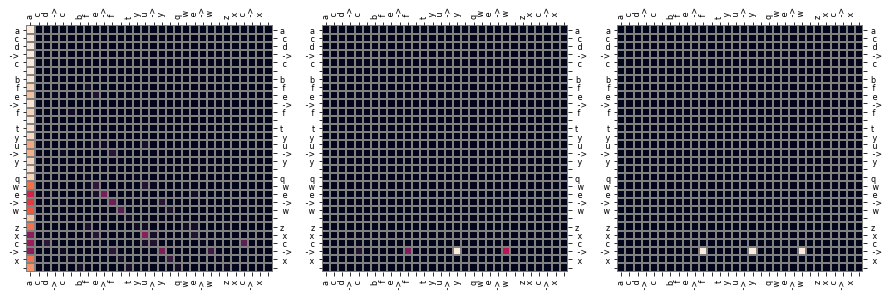

13 11 0.049681123


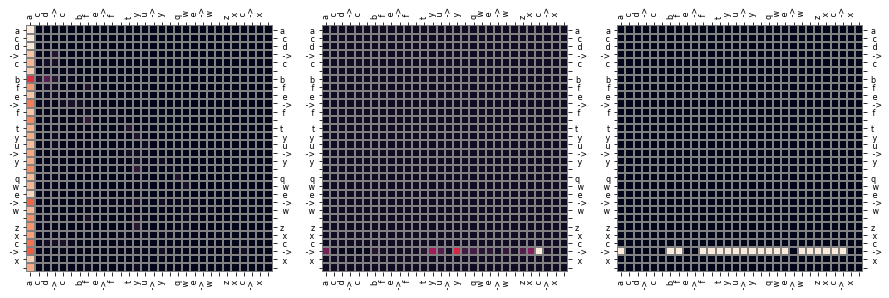

16 12 0.048331305


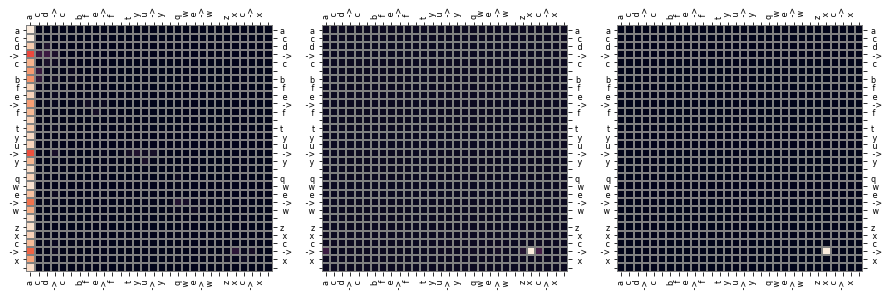

In [1031]:
attn_attr_twolayer = attr_twolayer['attn_weights']
attentions = torch.cat(o.attentions)

for l, h, v in zip(*topk_md(head_attr_twolayer, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attr_twolayer[l, h], binarize(attn_attr_twolayer[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

In [1056]:
layer, head, _ = list(zip(*topk_md(head_attr_twolayer, 10)))[1]
layer, head

(8, 1)

In [873]:
labels

tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, 2124, -100, -100]])

In [1034]:
def head_forward_v(model, hidden_states, layer, head, labels=None, loss_reduction='per_example_mean', attn_weights=None, layer_back =18, head_back=13):
    blocks = model.transformer.h
    ln_f = model.transformer.ln_f
    hq = hk = hv = scaled_ln(blocks[layer].ln_1, hidden_states)
    if attn_weights is not None: hq, hk = None, None
    head_output = attn_forward(blocks[layer], hq, hk, hv, by_head=True, attn_weights=attn_weights)[0]
#     print('sssss',head_output.shape) #4，25，30，1600
    return head_forward(model, o, head_output, layer_back, head_back, 
        labels=labels, loss_reduction='argmax', ln_scale=0.1)

In [1057]:
layer,head

(8, 1)

In [1061]:
# keys = ['head_mask', 'mlp_mask', 'embed_mask'] # 对head_output归因，看哪些head重要（先运行，粗粒度）
keys = ['attn_weights', 'mlp_mask', 'embed_mask']  # 对attn_weights归因，看哪些head的哪些关注重要（后运行，细粒度）
forward_fn = partial(sum_forward, outputs=o, labels=labels, ln_scale=0.1)
x = OrderedDict((key, get_x(key, o, to_layer=layer)) for key in keys)
# def get_y(outputs): return -outputs.loss
def get_y(outputs): 
    return head_forward_v(model,outputs.hidden_states[0], layer, head, 
        labels=labels, loss_reduction='argmax',attn_weights =None,layer_back = 18, head_back = 13).loss

attr_threelayer, ys = attribute(forward_fn, x, get_y, num_points=4, batch_size=4)
print(ys)

torch.Size([4, 30, 4096])
tensor([0.0403, 0.0749, 0.1970, 0.3352], grad_fn=<CatBackward>)


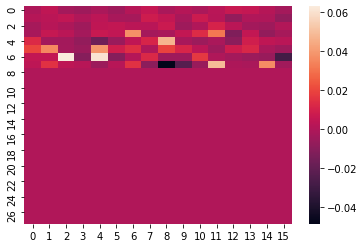

In [1059]:
head_attr_threelayer = torch.einsum('lni->ln', attr_threelayer['head_mask'])
_ = sns.heatmap(head_attr_threelayer, cbar=True)

In [1060]:
list(zip(*topk_md(head_attr_threelayer, 10)))

[(6, 2, 0.062813416),
 (6, 4, 0.060548097),
 (7, 11, 0.0488324),
 (4, 8, 0.0470934),
 (5, 4, 0.038542915),
 (3, 6, 0.037487876),
 (7, 14, 0.036689904),
 (5, 1, 0.03525466),
 (3, 11, 0.03128053),
 (5, 0, 0.019458685)]

6 2 0.062813416


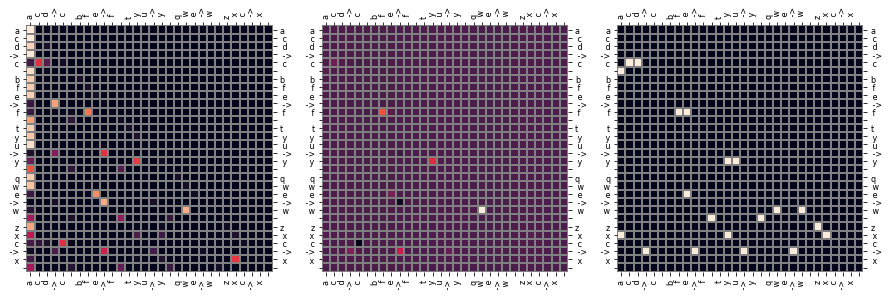

6 4 0.060548097


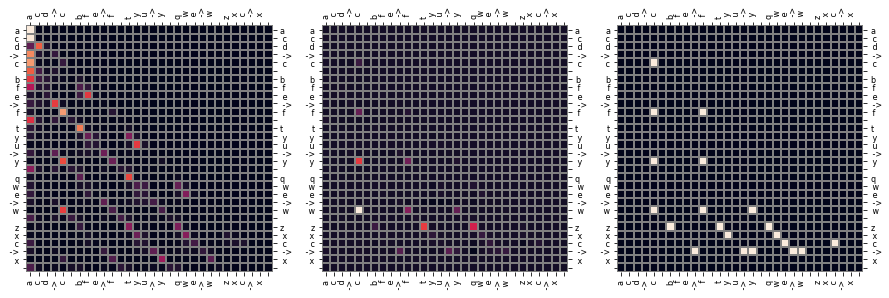

7 11 0.0488324


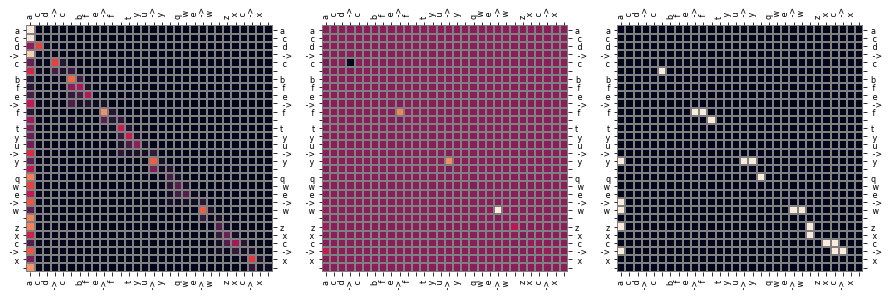

4 8 0.0470934


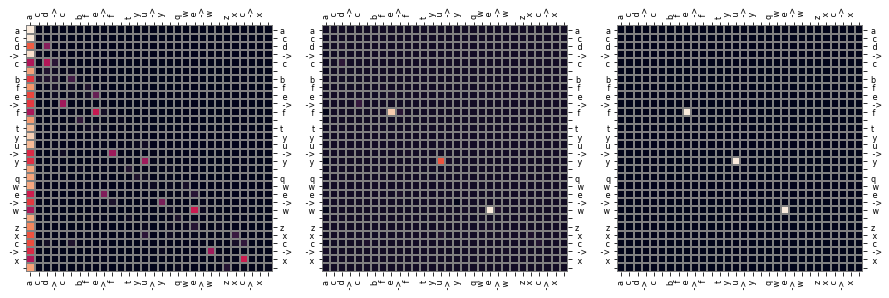

5 4 0.038542915


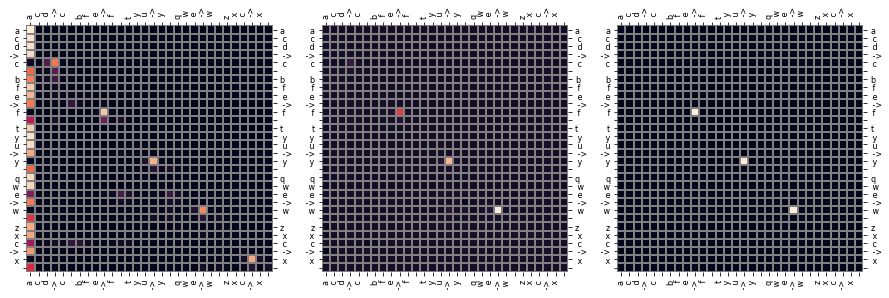

3 6 0.037487876


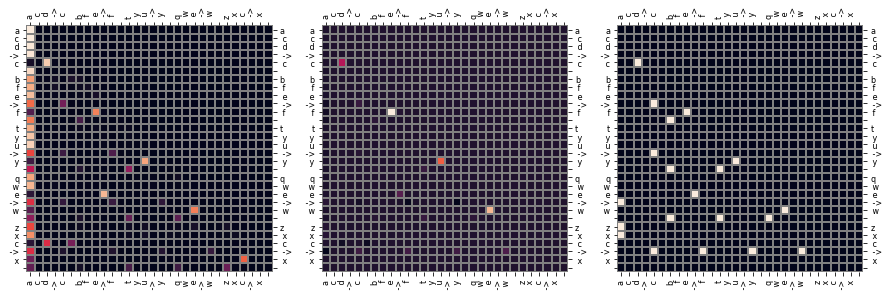

7 14 0.036689904


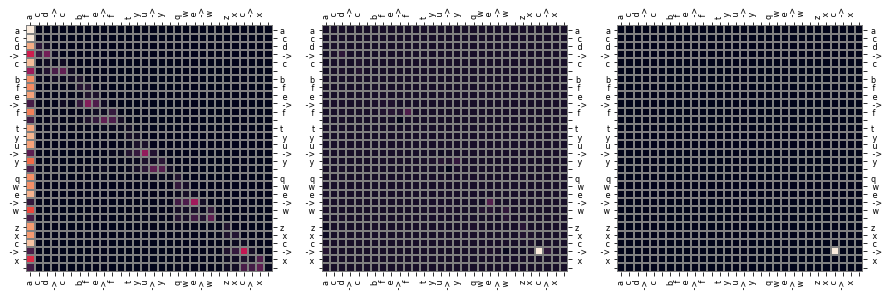

5 1 0.03525466


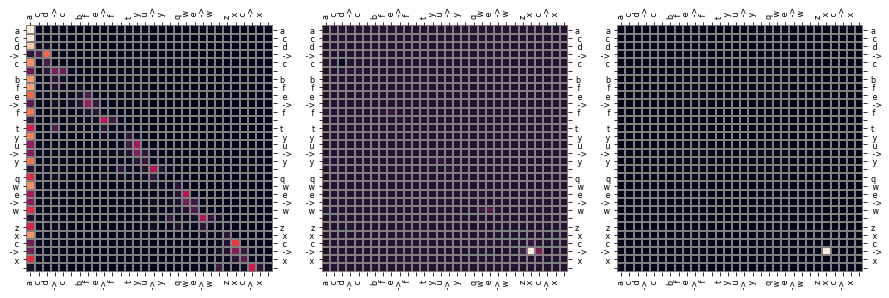

3 11 0.03128053


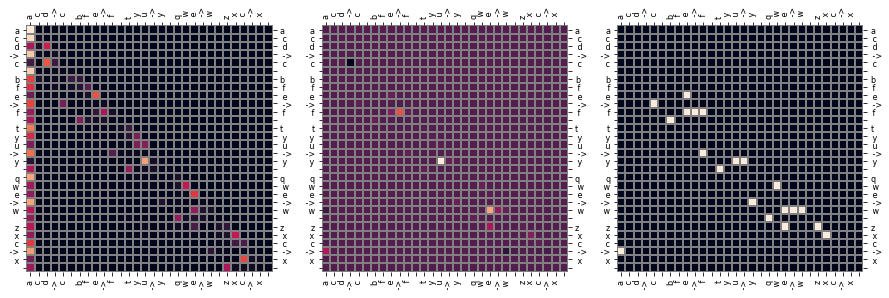

5 0 0.019458685


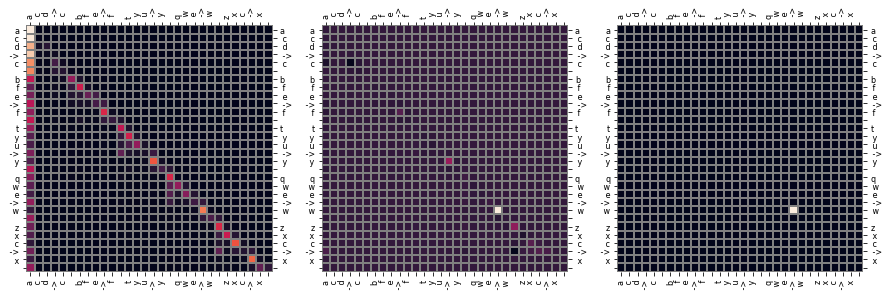

In [1062]:
attn_attr_threelayer = attr_threelayer['attn_weights']
attentions = torch.cat(o.attentions)

for l, h, v in zip(*topk_md(head_attr_threelayer, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attr_threelayer[l, h], binarize(attn_attr_threelayer[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

In [682]:
# 找第2重要的induction head（17-4）的K-composition heads
layer, head, _ = list(zip(*topk_md(head_attr, 10)))[0]
layer, head
aw_label = binarize(attn_attr[layer, head])
wq, wk = get_head_weights(layer, head)[:2]

(18, 13)

In [683]:
# Q com
head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
query = torch.einsum('blnie,de->blnid', head_outputs, wq)

key = torch.einsum('bje,de->bjd', o.hidden_states[layer], wk) # ln is important for query

# key = torch.einsum('blnje,de->blnjd', blocks[layer].ln_1(head_outputs), wk)
attn_logits = torch.einsum('blnid,bjd->lnij', query, key) # b==1
# i j l n -> n_label l n -> ln
attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)

In [416]:
blocks[0]

GPTNeoBlock(
  (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (attn): GPTNeoSelfAttention(
    (attn_dropout): Dropout(p=0, inplace=False)
    (resid_dropout): Dropout(p=0, inplace=False)
    (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (mlp): GPTNeoMLP(
    (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
    (c_proj): Linear(in_features=8192, out_features=2048, bias=True)
    (act): NewGELUActivation()
    (dropout): Dropout(p=0, inplace=False)
  )
)

In [434]:
# 对head_output归因 k com
query = torch.einsum('bie,de->bid', blocks[layer].ln_1(o.hidden_states[layer]), wq) # ln is important for query
head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
key = torch.einsum('blnje,de->blnjd', blocks[layer].ln_1(head_outputs), wk)
attn_logits = torch.einsum('bid,blnjd->lnij', query, key) # b==1
# i j l n -> n_label l n -> ln
attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)

[(13, 2, 116.81008),
 (8, 1, 87.14897),
 (12, 10, 83.38505),
 (13, 13, 70.88155),
 (9, 14, 41.475597),
 (15, 5, 38.282818),
 (4, 12, 36.39428),
 (17, 13, 32.392113),
 (6, 3, 31.646812),
 (13, 11, 30.46665)]

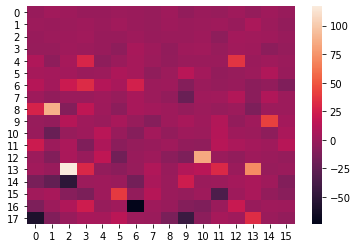

In [684]:
attn_head_attr = attn_head_attr.detach()
_ = sns.heatmap(attn_head_attr)
list(zip(*topk_md(attn_head_attr, 10)))

In [685]:
# 对attn_weights归因
# h2: a higher-layer (induction) head (layer, head)
# h1: lower-layer heads forming K-composition with h2
# i: h2 query position, j: h2 key position, k: h1 query position
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
attentions_ = attentions[:layer]
lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
query = lnije @ wq.T  # lnije,de->lnijd    
lnkij_attn_logits = torch.einsum('lnijd,bkd->lnijk', query, key)  # b==1
# kij means k attends i in higher layer, i attends j in lower layer
attn_attn_attr = torch.einsum('lnijk,ik->lnij', lnkij_attn_logits, aw_label)



In [604]:
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n i e -> l n i e')[:layer]
attentions_ = attentions[:layer]
query = head_inputs_ @ wq.T #lnie,de->lnid
lnik_attn_logits = torch.einsum('lnid,bkd->lnik', query, key) # b==1
lnkij_attn_logits = torch.einsum('lnij,lnik->lnikj', attentions_, lnik_attn_logits)
attn_attn_attr = torch.einsum('lnikj,ik->lnij', lnkij_attn_logits, aw_label)

In [436]:
# 对attn_weights归因
# h2: a higher-layer (induction) head (layer, head)
# h1: lower-layer heads forming K-composition with h2
# i: h2 query position, j: h2 key position, k: h1 query position
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
attentions_ = attentions[:layer]
if True: # faster version
    key = head_inputs_ @ wk.T  # lnje,de->lnjd
    lnkj_attn_logits = torch.einsum('bkd,lnjd->lnkj', query, key) # b==1
    lnkij_attn_logits = torch.einsum('lnij,lnkj->lnkij', attentions_, lnkj_attn_logits)
else: # slower version, but easier to understand (similar to unseal)
    lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
    key = lnije @ wk.T  # lnije,de->lnijd    
    lnkij_attn_logits = torch.einsum('bkd,lnijd->lnkij', query, key)  # b==1
# kij means k attends i in higher layer, i attends j in lower layer
attn_attn_attr = torch.einsum('lnkij,ki->lnij', lnkij_attn_logits, aw_label)

13 2 116.81008


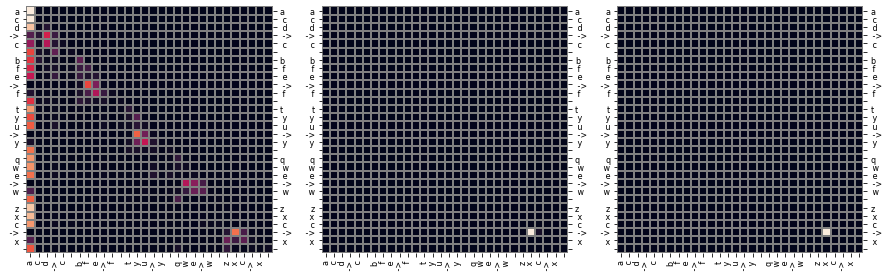

8 1 87.14897


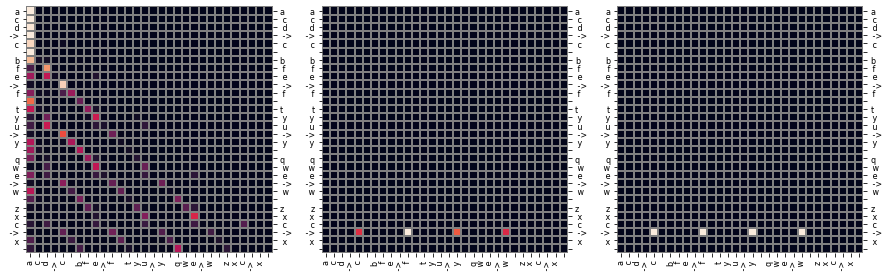

12 10 83.38505


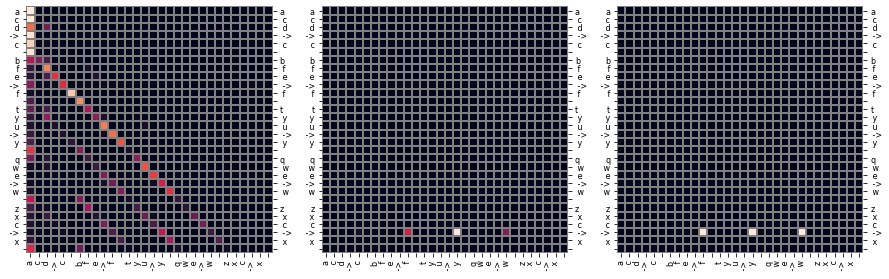

13 13 70.88155


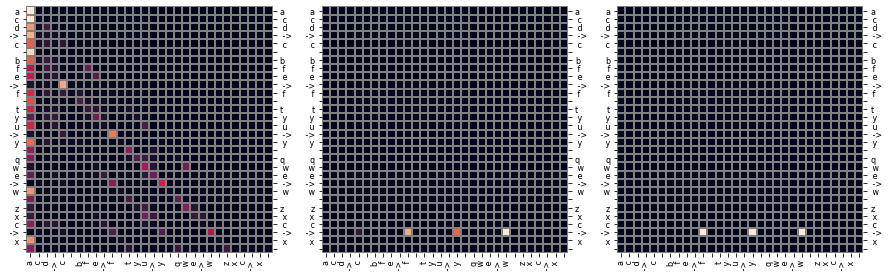

9 14 41.475597


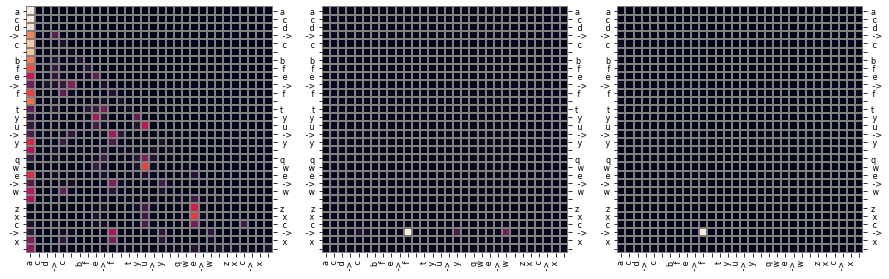

15 5 38.282818


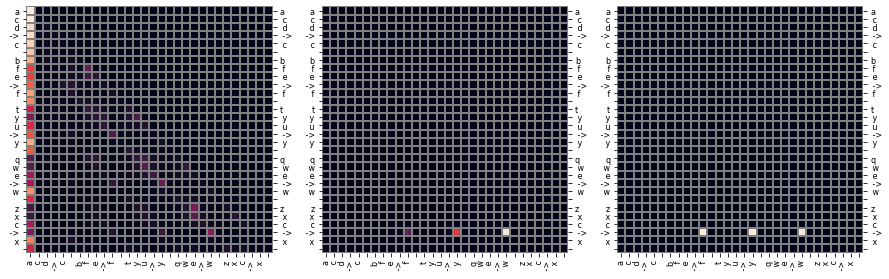

4 12 36.39428


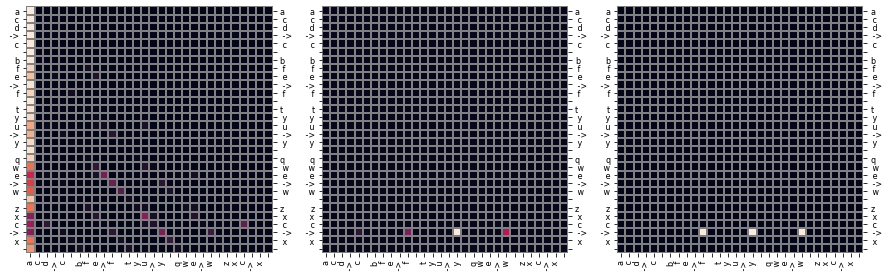

17 13 32.392113


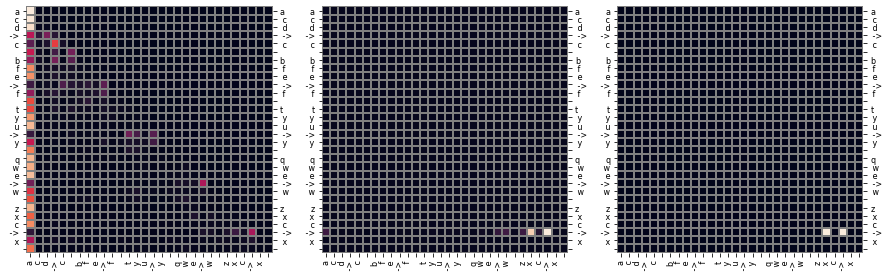

6 3 31.646812


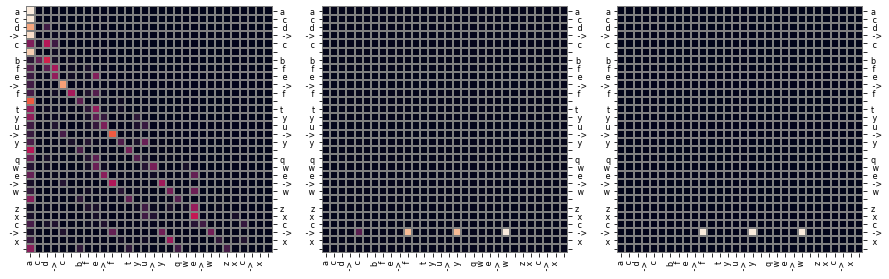

13 11 30.46665


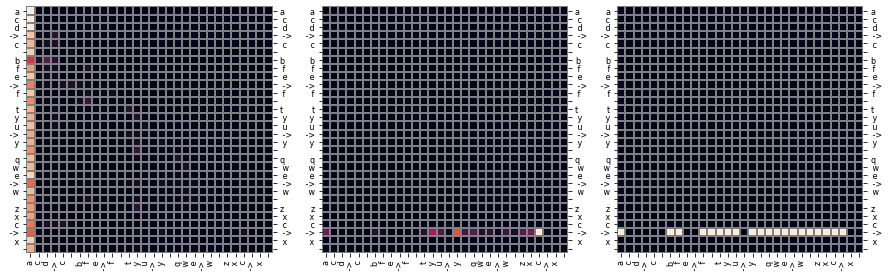

In [686]:
attn_attn_attr = attn_attn_attr.detach()
for l, h, v in zip(*topk_md(attn_head_attr, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attn_attr[l, h], binarize(attn_attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

In [473]:
all_attrs, all_yss = {}, {}

In [324]:
def qk_forward(model, outputs, layer, head, aw_label, attr_x, **mask_kwarges):
    ln = blocks[layer].ln_1
    kwargs = {x: ln(outputs.hidden_states[layer]) for x in ['hq', 'hk', 'hv']}
    kwargs[attr_x] = scaled_ln(ln, sum_forward(model, outputs, **mask_kwarges).hidden_states[0], scale=0.01) # attr_x in ['hq', 'hk']
    aw = attn_forward(blocks[layer], **kwargs)[1][:, head]
    aw_label_sum = torch.einsum('ij->', aw_label)
    # print('aw_label_sum =', aw_label_sum)
    mean_prob = torch.einsum('bij,ij->b', aw, aw_label) / aw_label_sum
    mean_logprob = torch.einsum('bij,ij->b', (aw + 1e-8).log(), aw_label) / aw_label_sum
    print('mean_prob =', mean_prob)
    print('mean_logprob =', mean_logprob)
    return mean_prob, mean_logprob

In [ ]:
# ig attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y)
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
attrs, yss = all_attrs[key], all_yss[key]

In [ ]:
dlosses = [(ys[0] - ys[-1]).item() for ys in yss]
np.array(dlosses)
_ = plt.bar(range(len(dlosses)), dlosses, 0.3)

In [248]:
# nattrs = [attr / abs(dloss) for attr, dloss in zip(attrs, dlosses)]
nattrs = [attr / attr.abs().mean() for attr in attrs]

In [251]:
mean_nattrs = torch.cat([nattr.mean(dim=-1) for nattr in nattrs])

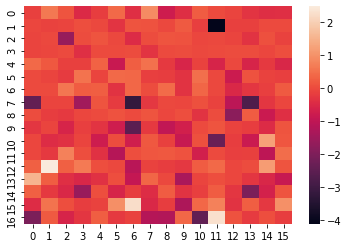

In [252]:
_ = sns.heatmap(mean_nattrs, cbar=True)

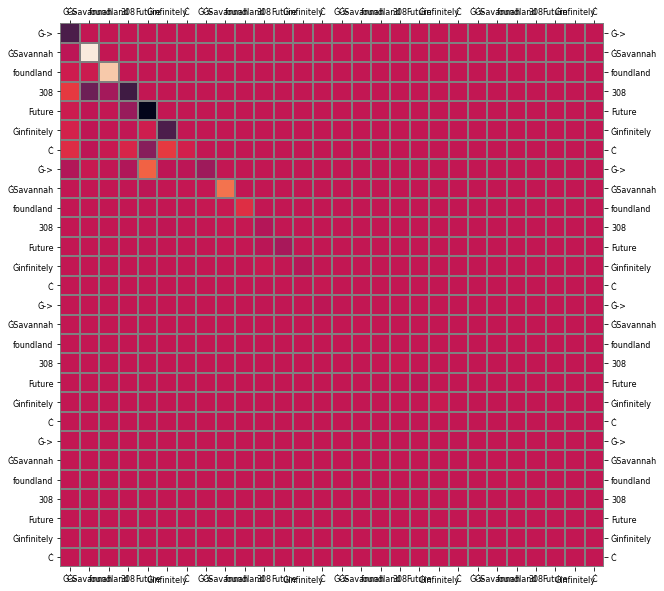

In [320]:
l, h = 6, 6
# attn = o.attentions[l][0, h]
attn = attrs[l][0, h]
plot_attn(attn, tokens)

QK circuit: $W_E^T W_Q^T W_K W_E$  
OV circuit: $W_U W_O W_V W_E$

In [230]:
def plot_eigenvalues(evs, ncols=4):
    fig, axs = plt.subplots(H // ncols, ncols, sharex=True, sharey=True, figsize=(20, 5))
    for i, (e, v) in enumerate(evs):
        e = e.detach().numpy()
        _ = axs[i // ncols][i % ncols].plot(e[:,0], e[:,1], '.')

In [281]:
WQK, WOV = [], []
for l in tqdm(range(L)):
    WQK.append([combine_weights(get_head_weights(l, h), qk=True) for h in range(H)])
    WOV.append([combine_weights(get_head_weights(l, h), qk=False) for h in range(H)])

100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


In [284]:
WQK = [[combine_weights(get_head_weights(l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]

100%|██████████| 24/24 [00:01<00:00, 20.26it/s]


In [333]:
# rwqk2, rwov1 = torch.rand(hidden_size, hidden_size) * 10, torch.rand(hidden_size, hidden_size) * 100

# rwq, rwk = torch.rand(hidden_size // H, hidden_size)*10, torch.rand(hidden_size // H, hidden_size)
# rwo, rwv = torch.rand(hidden_size, hidden_size // H), torch.rand(hidden_size // H, hidden_size)*100
# rwqk2, rwov1 = rwq.t().mm(rwk), rwo.mm(rwv)

# rwqk2.mm(rwov1).norm() / (rwqk2.norm() * rwov1.norm())

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio: $||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

In [345]:
dl = 3
kcomp3 = np.array([[[(WQK[l][h2].mm(WOV[l-dl][h1]).norm() / (WQK[l][h2].norm() * WOV[l-dl][h1].norm())).item() 
          for h1 in range(H)] for h2 in range(H)] for l in tqdm(range(dl, L))])

100%|██████████| 21/21 [01:23<00:00,  3.96s/it]


In [386]:
def scatter_plot(a): a = a.detach().numpy(); plt.plot(a[:,0], a[:,1], '.')

In [74]:
chains = [
    [(4, 14), (3, 3)],  # 0.24024388
    [(5, 4), (2, 2)],  # 0.21996385
    [(5, 4), (3, 7)],  # 0.31488344
    [(6, 6), (3, 3)],  # 0.27304175
    [(6, 6), (5, 3)],  # 0.12567882
]

In [314]:
(l2, h2), (l1, h1) = chains[4]

In [433]:
e = WQK[l2][h2].mm(WOV[l1][h1]).eig()[0]

In [435]:
e[:10] = 0

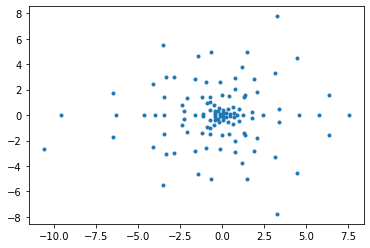

In [436]:
scatter_plot(e)

In [437]:
e = WOV[l2][h2].eig()[0]

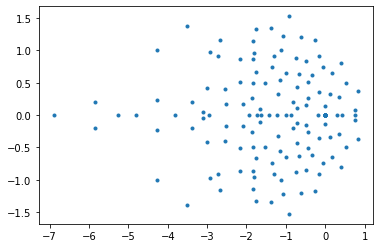

In [438]:
scatter_plot(e)

In [356]:
a = kcomp3[2]; ind = np.unravel_index(a.argmax(), a.shape); ind, a[ind]

((4, 2), 0.21996384859085083)

<AxesSubplot:>

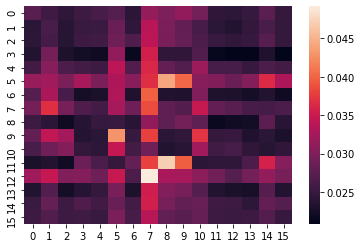

In [319]:
kcomp = np.array(kcomp)
sns.heatmap(kcomp, cbar=True)

In [364]:
wov_evs = [torch.eig(combine_weights(get_head_weights(3, h), qk=False, with_embedding=True, BA=True)) for h in tqdm(range(H))]

100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


  0%|          | 0/16 [3:32:06<?, ?it/s]


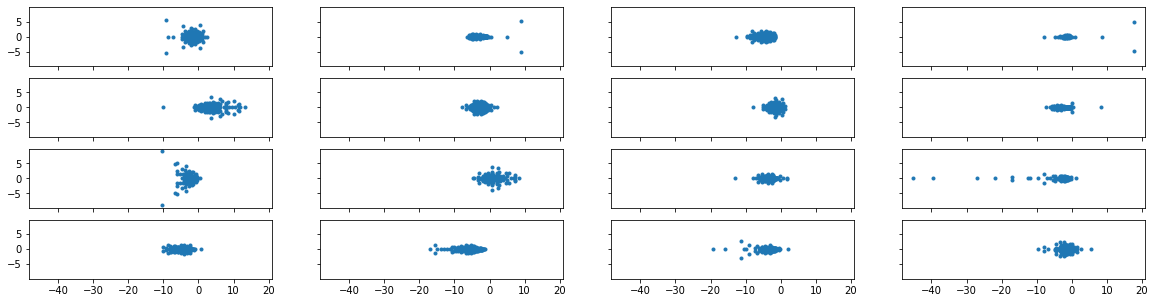

In [363]:
plot_eigenvalues(wov_evs)

In [138]:
w_eu = w_e.matmul(w_u)

In [522]:
def mlp(layer): return lambda x: blocks[layer].mlp(blocks[layer].ln_2(x))
def mlp0(layer): return lambda x: blocks[layer].mlp(x)

In [186]:
def attn(layer): return lambda x: blocks[layer].attn(blocks[layer].ln_1(x))

In [537]:
w_e2 = w_e * 50
w_eu2 = (w_e2 + mlp0(L-1)(w_e2)).matmul(w_u)

In [ ]:
# grad attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y);
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
plot_attn(globalize(attentions[8])[0, 2], figsize=(20, 20))

In [5395]:
for i, token in enumerate(tokens):
    if token in ['Ċ', '^']: print()
    else: print('%2d %s' %(i, token), end='  ')
tgt_positions


 1 E   2 N   3 K   4 R   5 ->   6 N  
 8 A   9 T  10 D  11 7  12 ->  13 T  
15 Q  16 A  17 P  18 K  19 ->  20 A  
22 A  23 N  24 L  25 5  26 ->  27 N  
29 V  30 1  31 P  32 B  33 ->  34 1  
36 G  37 V  38 7  39 4  40 ->  41 V  
43 R  44 Y  45 J  46 P  47 ->  48 Y  
50 A  51 C  52 S  53 Y  54 ->  55 C  


tensor([ 2,  9, 16, 23, 30, 37, 44, 51])

In [5409]:
a = all_attrs[task_name]['aw' + str(int(pred_attn))]
a = a / a.view(a.size(0), -1).norm(dim=1)[:, None, None, None] #.view(a.size(0), 1, 1, 1)
if not pred_attn:
    src_indices, tgt_indices = [src], [tgt]
    _a = a[:, :, src_indices, tgt_indices]
    values, indices = _a.view(_a.size(0), H, -1).topk(1, dim=-1)
    show_top_heads(values, indices, src_indices=src_indices, tgt_indices=tgt_indices)
    print()
# src_indices = numpy(ans_positions[:])
# src_indices = numpy(tgt_positions + 1)
# tgt_indices = tgt_positions
_a = a[:, :, src_indices, :]
values, indices = _a.view(_a.size(0), H, -1).topk(nrows // 2, dim=-1)
show_top_heads(values, indices, src_indices=src_indices)#, tgt_indices=tgt_indices)

16-15	0.918 [(51, 0.918, 66.8)]	0.13030353 *0.66812056 0.011132528 0.0006797812 
14-0	0.783 [(51, 0.783, 66.5)]	0.14255618 *0.6645065 0.019694159 0.0019851688 
17-13	0.705 [(51, 0.705, 49.8)]	0.18755053 *0.49829417 0.078217894 0.10344336 
13-2	0.505 [(51, 0.505, 44.5)]	0.43078056 *0.44530356 0.017190581 0.001503151 
17-17	0.213 [(51, 0.213, 40.9)]	0.16368316 *0.4086181 0.24944614 0.11208218 
14-13	0.192 [(51, 0.192, 32.8)]	0.20337617 *0.32792574 0.07777147 0.073093265 
15-8	0.159 [(51, 0.159, 22.5)]	0.15539594 *0.22527154 0.26876858 0.27620015 
14-16	0.101 [(51, 0.101, 26.3)]	0.11579089 *0.2628595 0.104256935 0.014017421 
15-16	0.099 [(51, 0.099, 13.2)]	0.13631786 *0.1315605 0.098822616 0.30740336 
13-12	0.095 [(51, 0.095, 13.1)]	0.44031265 *0.13147357 0.035518978 0.05850061 
13-3	0.078 [(51, 0.078, 34.5)]	0.46285912 *0.34470326 0.08684665 0.0354087 
7-2	0.062 [(51, 0.062, 27.9)]	0.105706446 *0.2786354 0.16776893 0.2326701 
17-1	0.047 [(51, 0.047, 46.0)]	0.38024765 *0.45963302 0.023335

In [5408]:
def show_top_heads(values, indices, src_indices=None, tgt_indices=None, topk=15):
    val, ind = values.sum(dim=-1).view(-1).topk(topk)
    val, ind = numpy(val), unravel_index(ind, values.size()[:-1])
    for (l, h), v in zip(ind, val):
        _l = l + layer_range[0]
        if _l <= 3: continue
        top_links = list(zip(unravel_index(indices[l, h], (seq_len, seq_len)), numpy(values[l, h], decimals=3)))
        if src_indices is not None: top_links = [([src_indices[_s], _t], _v) for [_s, _t], _v in top_links]
        if tgt_indices is not None: top_links = [([_s, tgt_indices[_t]], _v) for [_s, _t], _v in top_links]
        top_links = [([_s, _t], _v, numpy(globalize(attentions[_l]) * 100, decimals=1)[0, h, _s, _t]) for [_s, _t], _v in top_links]
        _top_links = [([_s, _t], _v, _a) if len(src_indices) > 1 else (_t, _v, _a) for [_s, _t], _v, _a in top_links]
        print('%d-%d\t%.3f' % (_l, h, v), _top_links, end='\t') 
        if len(top_links) == 1:
            probs = numpy(globalize(attentions[_l])[0, h, src])
            for i in cand_range:
                if i == tgt: print('*', end='')
                print(probs[i], end=' ')
        print()

tensor([0.6156])


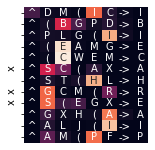

In [5057]:
a = globalize(attentions[layer2])[:, head2]
# a = a.softmax(-1)
a = torch.cat([a[:, i - 1: i, i - ncols - 2: i + 1] for i in ans_positions], dim=1)
# a = a.softmax(-1)
loss = a.view(a.size(0), -1)[:, tgt_positions[1:]].mean(dim=1)
print(loss)
plot_tgt_attn(a[0])

In [3455]:
wvos = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(11, 8), (12, 18)]]
wqk = torch.matmul(*get_head_weights(13, 2)[:2])
ww = wvos[0].matmul(wvos[1]).matmul(wqk)

In [3735]:
ww.norm(dim=0).topk(40).indices

tensor([2484,   88,  578, 1781,  586,  408, 2054,  304,  824, 1675, 1772,  501,
        2456, 1019,  936, 2463, 2368,  340, 2418,  101, 1734,  687, 2159, 1060,
          20, 1838,  224, 1669, 1187,  870, 1585,  232,  281, 1474, 1729,  328,
        1860, 1174,  816, 1524])

In [3741]:
show_topk(*aw.view(-1).topk(20, largest=False), indices_fn=indices_fn)

{(578, 586): -0.0016085216,
 (578, 88): -0.0011706072,
 (936, 1782): -0.0011014504,
 (578, 501): -0.0009034774,
 (578, 114): -0.00086396607,
 (578, 1761): -0.00080681103,
 (578, 1067): -0.0007989705,
 (936, 814): -0.00079893926,
 (936, 405): -0.00076955673,
 (936, 336): -0.0007586547,
 (578, 2149): -0.00074234203,
 (578, 1666): -0.0007264766,
 (578, 408): -0.00071433355,
 (578, 1019): -0.00066249806,
 (936, 946): -0.00065255526,
 (2484, 1675): -0.00064498984,
 (578, 1675): -0.0006330121,
 (578, 1651): -0.00062471436,
 (936, 1445): -0.00062095723,
 (578, 289): -0.0006184878}

In [4065]:
wvos2 = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(9, 9), (10, 1), (12, 18)]]
ww2 = reduce(torch.matmul, wvos2 + [wqk])

In [5015]:
attn_output1, out = None, None
out_proj_w = self1.out_proj.weight.view(hidden_size, H, -1).permute(1, 2, 0).unsqueeze(0)
head_mask = torch.zeros(H, seq_len, seq_len)
head_mask[[18,]] = 1
# head_mask[:] = 1
attn1 = attentions[layer1]
_attn1, __attn1 = torch.zeros_like(attn1), torch.zeros_like(attn1)
for i in range(0, nrows):
    _attn1[:, :, arrow_positions[i], ans_positions[i]] = 1
    __attn1[:, :, arrow_positions[i], ans_positions[:i]] = 1 / i if i > 0 else 0
    
def ffn(layer, x): return blocks[layer].mlp(blocks[layer].ln_2(x))

def tgt_attn_loss(h1, attn1, key0, residual=None, attn_output_w=1, apply_softmax=True, temperature=10, 
                  positions=tgt_positions, plot=False, ax=None):
    def get_attn(attn_output):
        out = (residual if residual is not None else 0) + attn_output * attn_output_w
        if residual is not None: out = out + ffn(layer1, out)
        if residual is not None: out = ln2(out)
        query = out.matmul(wq2.t()).unsqueeze(2) # (bsz, nrows, d_head) -> (bsz, nrows, 1, d_head), ln2 is omissible
        key = key0.matmul(wk2.t()).view(bsz, nrows, ncols + 3, hidden_size // H)
        a = (query * key).sum(-1) # (bsz, nrows, ncols + 3)
        a[:, :, [-1]] = -1e9
        if apply_softmax: a = (a / temperature).softmax(-1)
        return a

    self1.w = attn1 * head_mask; attn_output1 = self1(h1)[0] - self1.out_proj.bias
    a = get_attn(attn_output1[:, arrow_positions])
    loss = a.view(a.size(0), -1)[:, positions]
    if plot:
#         a = a - a.min(dim=2, keepdim=True).values
        plot_tgt_attn(a[0], ax=ax)#; print(loss)
    return loss.mean()

residual = None or hidden_states[layer1][:, arrow_positions]

[0.7721180319786072, 0.9933991432189941, 0.9961371421813965]

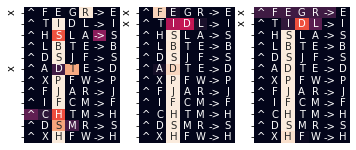

In [5052]:
def get_ln(layer): return blocks[layer].ln_1
# 10-ffn, 9-11 for find special, 9-11 for AbCD->B/b, 9-11 for ABCD->C
# 10-19+ffn+8!, 9-11 for after bracket 5-5/7, 9-11, 10-1+13+ffn+8+19 for in brackets
mask = torch.zeros(H, seq_len, 1); mask[11] = 1#; mask[:] = 0 # 11-8, 10-1, 9-11,   9-11/6?->8-17 for 2nd
# for i in range(0, nrows): mask[1, ans_positions[i], tgt_positions[i]+1] = 1
layer0 = 9
self0, ln0 = get_attn_module(blocks[layer0]), blocks[layer0].ln_1

h0 = hidden_states[9]*0 + head_outputs[8][:, [17]].sum(1)*1
self0.w = attentions[layer0] * mask; attn_output0 = self0((h0), attention_masks[layer0])[0] - self0.out_proj.bias
# h1 = hidden_states[9]*0 + head_outputs[11][:, [8]].sum(1)*1 #+ ffn_outputs[10]#+ head_outputs[11][:, [8,]].sum(1)*1
# h1 = ln1(h1)
h1 = attn_output0
key0 = get_ln(10)(hidden_states[10])#; key0.reqires_grad = True; key0.retain_grad()
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24))
# loss = tgt_attn_loss(h1, __attn1, key0, residual=None, plot=True, apply_softmax=True, temperature=1, ax=axes[0]); loss
# print('after', key0[:, :, 0])
[tgt_attn_loss(h1, attn, key0, residual=None,plot=True,temperature=1, positions=tgt_positions[(i>0)*2:],ax=ax).item() 
    for i, (attn, ax) in enumerate(zip([_attn1, attn1, __attn1], axes))]
# if losses[0] > 0.8 and losses[-1] > 0.8: print(layer, head, losses)

In [5075]:
def get_weight_norm(w):
    return w.abs().mean().item()

In [5083]:
wvo1 = get_combined_w(9, 11) * get_combined_w(12, 18)
for layer in [8, ]:
    for head in range(H):
        wvo = get_combined_w(layer, head)
        print('%d-%d %.4f %.4f' % (layer, head, get_weight_norm(wvo.matmul(wvo1)) / get_weight_norm(wvo), get_weight_norm(wvo.matmul(wvo1))))

8-0 0.0865 0.0030
8-1 0.0865 0.0016
8-2 0.0866 0.0026
8-3 0.0870 0.0027
8-4 0.0867 0.0019
8-5 0.0873 0.0022
8-6 0.0874 0.0027
8-7 0.0867 0.0023
8-8 0.0867 0.0021
8-9 0.0879 0.0026
8-10 0.0874 0.0023
8-11 0.0866 0.0024
8-12 0.0870 0.0024
8-13 0.0868 0.0023
8-14 0.0866 0.0017
8-15 0.0870 0.0023
8-16 0.0874 0.0029
8-17 0.0865 0.0014
8-18 0.0876 0.0025
8-19 0.0866 0.0024


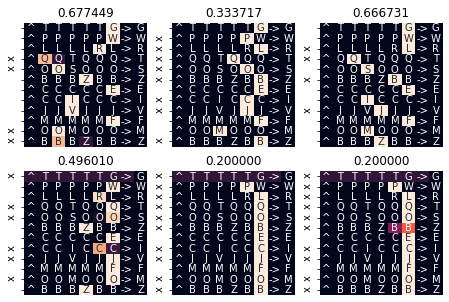

In [4950]:
front_chains = [
    [[(11, 8), create_mask(ans_positions, tgt_positions)]],
    [[(9, 9), create_mask(tgt_positions + 1, tgt_positions)], [(10, 1), create_mask(ans_positions, tgt_positions + 1)]],
]
rear_chains = [
    [[(12, 18), create_mask(arrow_positions, ans_positions)], [(13, 2), None]],
    [[(12, 18), create_mask(arrow_positions, ans_positions, accum=True)], [(13, 2), None]],
]

sum_a = {i: 0 for i in range(len(rear_chains))}
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for j, front_chain in enumerate(front_chains):
    l0 = front_chain[0][0][0]
    h = h0 = get_ln(l0)(hidden_states[l0])
    for (layer, head), mask in front_chain:
#         attn = globalize(attentions[layer])[:, head] #if layer in [9] else mask
        attn = mask
        wvo = get_combined_w(layer, head)
        h = attn.matmul(h.matmul(wvo))
    for i, rear_chain in enumerate(rear_chains):
        (layer, head), mask = rear_chain[0]
        attn = mask
        wvo = get_combined_w(layer, head)
        q = attn.matmul(h.matmul(wvo))
        wqk = get_combined_w(*rear_chain[-1][0], qk=True)
        q = q.matmul(wqk)[:, arrow_positions].unsqueeze(2)
        k = h0.view(h0.size(0), nrows, ncols + 3, hidden_size)
        a = q.matmul(k.transpose(-1, -2)).squeeze(2) / 1
        a[:, :, [-1]] = -1e9
        sum_a[i] = sum_a[i] + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j], title='%f' % loss.item())

for i in range(len(rear_chains)):
    a = sum_a[i]
    a = a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2], title='%f' % loss.item())

In [4602]:
_sattn, __sattn = torch.zeros(1, seq_len, seq_len), torch.zeros(1, seq_len, seq_len)
for i in range(0, nrows):
    _sattn[:, arrow_positions[i], tgt_positions[i]] = 1
    __sattn[:, arrow_positions[i], tgt_positions[:i]] = 1 / i if i > 0 else 0

0.157 0.497 0.250 
0.100 0.809 0.264 


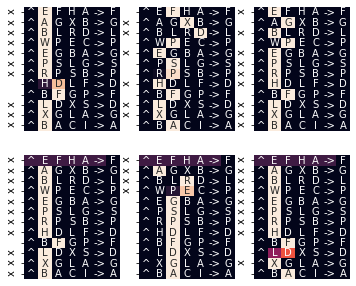

In [4605]:
ww0 = torch.eye(hidden_size)
# layer = 9; ln = blocks[layer].ln_1
# h0 = key0 = ln(hidden_states[layer])
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for i, attn in enumerate([_sattn, __sattn]):
    sum_a = 0
    for j, (w, layer) in enumerate([(ww, 11), (ww2, 9)]):
        ln = blocks[layer].ln_1
        h0 = key0 = ln(hidden_states[layer])
        query = attn.matmul(h0)[:, arrow_positions].matmul(w).unsqueeze(2)
        key = key0.view(key0.size(0), nrows, ncols + 3, hidden_size)
        a = (query * key).sum(-1) / 1
        a[:, :, [-1]] = -1e9
        sum_a = sum_a + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j])
    a = sum_a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2])
    print()

In [3719]:
aw = ww * ww.grad

In [3721]:
aw.norm(dim=0).topk(10)

torch.return_types.topk(
values=tensor([0.0037, 0.0029, 0.0027, 0.0025, 0.0023, 0.0023, 0.0018, 0.0016, 0.0016,
        0.0016], grad_fn=<TopkBackward>),
indices=tensor([  88,  586, 2484,  408, 1782,  578, 1781, 1019,  405, 1761]))

In [4962]:
head_outputs[9][0, :, ans_positions].norm(dim=-1).mean(-1).topk(10)

torch.return_types.topk(
values=tensor([12.2424, 11.6219, 11.3335, 10.7489,  9.3170,  9.2139,  8.5213,  7.5385,
         6.7957,  6.3538]),
indices=tensor([ 9, 19, 11,  7, 14,  6,  4, 10,  0,  8]))

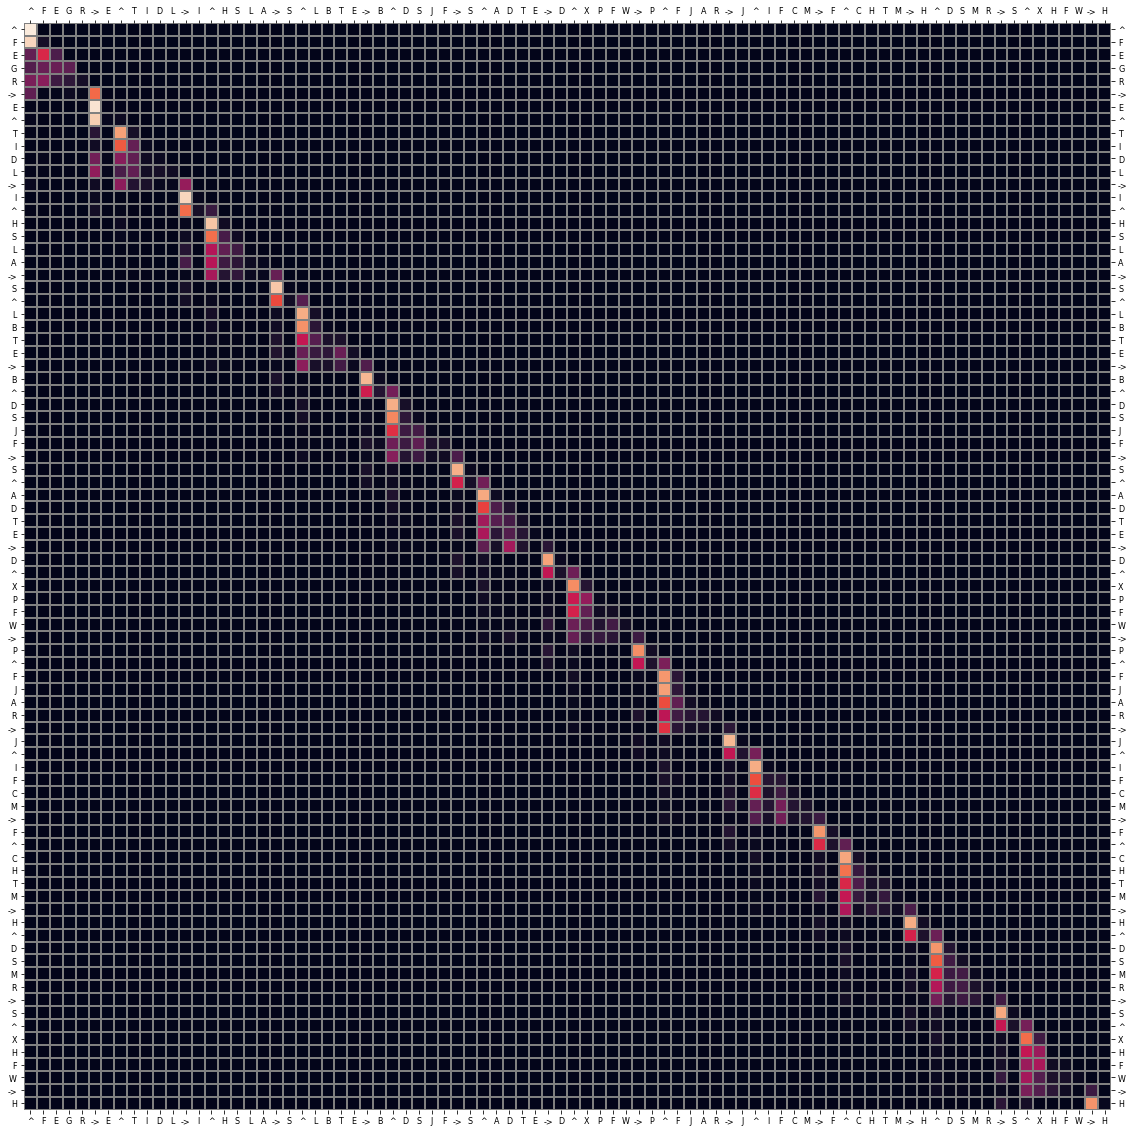

In [5037]:
plot_attn(globalize(attentions[9])[0, 6], figsize=(20, 20))

In [3360]:
a0 = head_outputs[9][0, 11, ans_positions]
a1 = head_outputs[11][0, 8, ans_positions]

In [3362]:
a0 = attrs['head_output'][9, 11, ans_positions]
a1 = attrs['head_output'][11, 8, ans_positions]

In [3363]:
cos = nn.CosineSimilarity(dim=1)
cos(a0, a1)

tensor([0.0226, 0.1145, 0.0712, 0.1595, 0.0533, 0.0150, 0.1125, 0.1410, 0.0172,
        0.0142, 0.0040, 0.0719])

In [3336]:
attr = attrs['attn_output'].sum(-1)
attr = attr / attr.view(attr.size(0), -1).norm(dim=1)[:, None]

<AxesSubplot:>

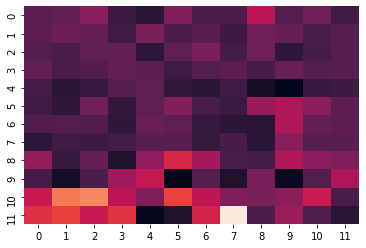

In [3337]:
sns.heatmap(numpy(attr[:, ans_positions]), cbar=False)

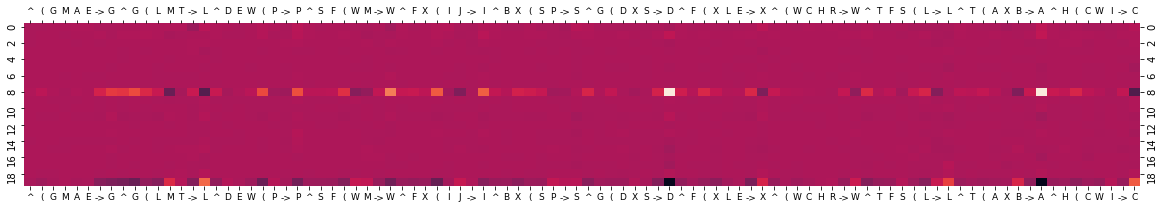

In [3887]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attrs['head_output'].sum(-1)[10]), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

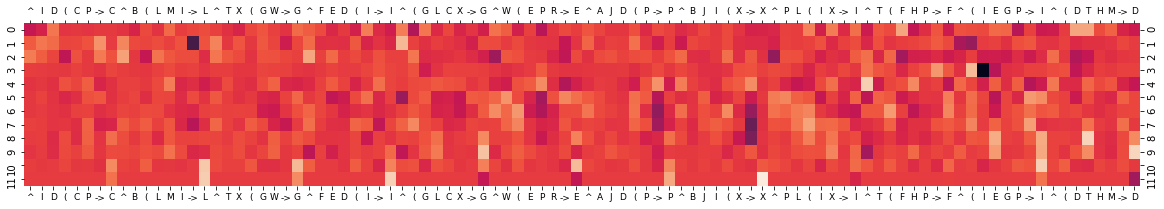

In [3303]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attr), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

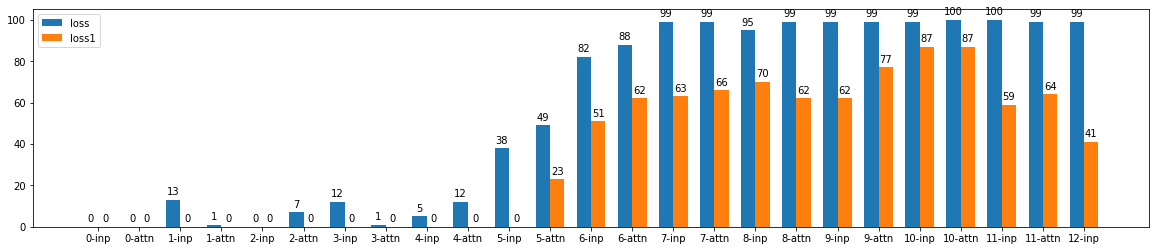

In [616]:
ffn_w = 0
results = []
for i in range(0, layer1 + 1):
    h1 = hidden_states[i] - hidden_states[0]*1
    residual = None #or hidden_states[layer1][:, arrow_positions]
    losses = [tgt_attn_loss(h1, attn, residual=residual, ffn_w=ffn_w) for attn in [_attn1, attn1]]
    results.append(('%d-inp' % i, losses[0], losses[1]))
    if i < layer1:
        losses = [tgt_attn_loss(h1 + attn_outputs[i], attn, residual=residual, ffn_w=ffn_w) 
                  for attn in [_attn1, attn1]]
        results.append(('%d-attn' % i, losses[0], losses[1]))
plot_tgt_attn_losses(*zip(*results))

10 tensor(0.2207, grad_fn=<MeanBackward0>)


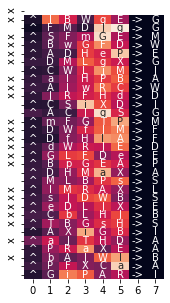

In [2149]:
a = []
tgt_h = hidden_states[layer0][0, tgt_positions]
h0 = hidden_states[layer0].view(nrows, ncols + 3, hidden_size)
for i in range(nrows):
    q = tgt_h[0:i].mean(dim=0)
    q = ln2(q).matmul(wq2.t())
    k = ln2(h0[i]).matmul(wq2.t())
#     attn1 = globalize(attentions[layer1]) * head_mask
#     attn_output1 = torch.matmul(attn1, _head_output1).sum(1)
#     q = ln2(attn_output1[:, arrow_positions[i]]).matmul(wq2.t())
#     q = ln2(_attn_output1[:, ans_positions][:, i:i+1].mean(1)).matmul(wq2.t())
#     k = key[i]
    a.append((q * k).sum(-1).unsqueeze(0))  # == torch.matmul(q, k.t())

a = torch.cat(a)
a[:, -2:] = -1000000
a = a.softmax(-1)
plot_tgt_attn(a)

In [3153]:
layer1, head1 = 12, 18
layer0, head0 = 11, 8
layer2, head2 = 13, 2  #17-4 for A[B]C->B,A*BC->B, 13-5 for reverse set diff
self0, self1, self2 = get_attn_module(blocks[layer0]), get_attn_module(blocks[layer1]), get_attn_module(blocks[layer2])

h_mask = torch.ones(hidden_size)
h_mask[top_i[0]] = 0

ln0, ln1, ln2 = blocks[layer0].ln_1, blocks[layer1].ln_1, blocks[layer2].ln_1
# mean, var = forward(blocks[layer2], 'ln1_mean_var')

wq0, wk0, wv0, wo0 = get_head_weights(layer0, head0)
wq1, wk1, wv1, wo1 = get_head_weights(layer1, head1)
wq2, wk2, wv2, wo2 = get_head_weights(layer2, head2)

In [3396]:
attn_output0, ffn_output0 = forward(blocks[layer0], ['attn_output', 'ffn_output'], exit_module=blocks[layer0],
                                    extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])
head_output0 = forward(get_attn_module(blocks[layer0]), 'head_output', exit_module=blocks[layer0],
                        extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])

10


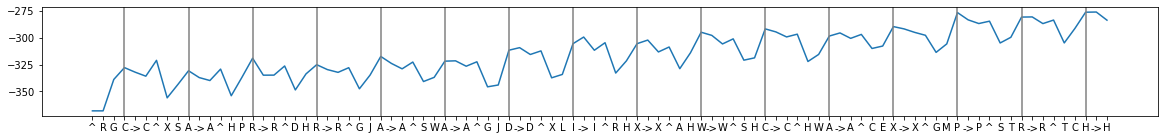

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 tensor(1.0000, grad_fn=<MeanBackward0>)


In [1202]:
## h1 = ln1(hidden_states[10]*0 + attn_output0 * 1 + ffn_output0 * 1)
h1 = ln1(hidden_states[layer0]*1 + attn_outputs[10]*1 + ffn_outputs[10] * 1 + attn_outputs[11] * 1 + ffn_outputs[11] * 1)

self1.head_output, self1.attn_output = None, None
self1.w = attentions[layer1]
try: _ = self1(h1, attention_mask=attention_masks[layer1])
finally:
    head_output1, attn_output1 = getdelattr(self1, 'head_output'), getdelattr(self1, 'attn_output')
    try_delattr(self1, 'w')

query = get_query(self2, ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*0))
# query = get_query(self2, ln2(head_output1[:, [16, 18]].sum(1)))
# query = get_query((self2, head_outputs[layer1][:, head1]))
# query = get_query(self2, attn_hidden_states[layer2])
for layer in [layer0]:#range(layer2 + 1):
    key2 = get_key(self2, ln2(hidden_states[layer]))
#     key2 = get_key(self2, ln2(attn_outputs[9]))
    logits = (query * key2).sum(dim=-1)
    print(layer)
    _ = test(None, None, logits=logits, always_show=True)

In [73]:
emb = all_embs[task_name][key]
emb_attr = all_attrs[task_name][key + str(int(pred_attn))]

In [2881]:
layer0 = 10
# layer, head = 10, 8  # ABC->B, ABC->A(pred_attn<12-18), ABC->C(only pred_attn), find lowercase, set diff2(only pred_attn)
layer, head = 12, 18 # 12-16, 12-18, 12-1 ABC->A, ABC,AXC->X, set diff2, set diff
layer2, head2 = 13, 2  # ABC->B, ABC->A, ABC->C, ABC,AXC->X, set diff, set diff2(<13-12), find lowercase(<15-8)
# layer2, head2 = 15, 8  # 15-8, find lowercase
# layer2, head2 = 13, 12  # set diff2, ABC,AXC->X(<13-2)

In [483]:
positions = tgt_positions[1:]
offsets = [torch.zeros_like(positions) - 1, torch.zeros_like(positions), torch.zeros_like(positions) + 1]
labels = numpy(torch.cat(offsets))
for layer in range(layer2):
    for head in range(H):
        emb = numpy(torch.cat([attn_outs[layer][0, head, positions + offset] for offset in offsets]))
#         emb = numpy(torch.cat([head_outputs[layer][0, head, positions + offset] for offset in offsets]))
        head_output = head_outputs[layer][:, head]
        if cluster(emb, labels)[0]:# and test(head_output, always_show=False) is not None:
#         if test(head_output, always_show=False) is not None:
            visualize_by_pca(emb, labels)
#             attn = globalize(attentions[layer])[0, head]
#             plot_attn(attn)
            print(layer, head)

(tensor([0.0174, 0.0392, 0.0546, 0.0641, 0.0408, 0.2807, 0.1289, 0.1209, 0.0977],
        grad_fn=<IndexBackward>),
 tensor(0.8444, grad_fn=<SumBackward0>))

(tensor([0.6571, 0.1062, 0.3671, 0.5548, 0.2617, 0.7426, 0.6988, 0.5396, 0.8236,
         0.6873], grad_fn=<SelectBackward>),
 tensor(0.5439, grad_fn=<MeanBackward0>))

(tensor([1.1355e-16, 3.7752e-13, 7.8185e-12, 6.1335e-10, 5.1372e-08, 3.3332e-06,
         3.1391e-04, 5.4327e-03, 1.5451e-01, 5.4892e-01],
        grad_fn=<IndexBackward>),
 tensor(0.0709, grad_fn=<MeanBackward0>))

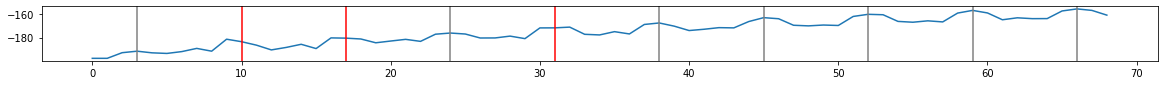

True

In [2023]:
layer0, head0 = 10, 1 #11-14  10-1
h_mask2 = torch.ones(hidden_size)
h_mask2[top_i[:]] = 0

attn_mask = torch.ones(H, seq_len, hidden_size // H)
# attn_mask[:, :] = 0
# attn_mask[8, :] = .1
m = get_attn_module(blocks[layer2])
outputs = forward(get_attn_module(blocks[layer0]), 'attn_mask', attn_mask, exit_module=blocks[layer2],
                 extra_tuples=[(m, 'return_attn_logits', True), #(m, 'hidden_states_mask', h_mask2),
#                                (get_attn_module(blocks[10]), 'hidden_states_mask', h_mask2),
                               (get_attn_module(blocks[layer1]), 'w', attentions[layer1])
                              ])

probs0 = outputs.attentions[layer1][0, head1, src, ans_positions[:-1]]
probs0, probs0.sum()
logits = globalize(outputs.attentions[layer2])[0, head2, src, : src + 1]
probs = logits[cand_positions].view(-1, n_candidates).softmax(-1)[:, task_name2idx[task_name]]
probs, probs.mean()
probs = logits.softmax(-1)[tgt_positions]
probs, probs.mean()
test(None, None, logits=logits)

tensor([[0.0066, 0.0076, 0.1356, 0.0835, 0.2636, 0.0631, 0.2177]],
       device='cuda:2')
tensor([0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
       device='cuda:2')
{'44 a': 0.3398, '42 ^': 0.2043, '43 Y': 0.1879, '38 I': 0.0659, '41 v': 0.0539}


{'Ġa': 0.3382, 'Ġv': 0.2697, 'ĠY': 0.0545, 'Ġu': 0.042, 'Ġy': 0.0365}

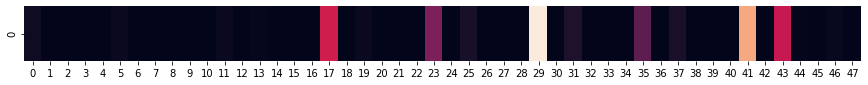

In [261]:
m = blocks[layer].attn.attention
mask = torch.ones(H, seq_len, seq_len)
# mask[:, src] = 0
mask[:] = 0
mask[head, src] = 0.1
_ = mask.requires_grad_(True)
# m.attn_mask = mask

# scaled_attn = attentions[layer] * mask.to(model.device)
# _ = scaled_attn.requires_grad_(True)
# m.w = scaled_attn
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[layer]
    _ = plt.figure(figsize=(15, 1))
    _ = sns.heatmap(numpy(attn[:, head, src, :]), cbar=False)
    print(attn[:, head, src, ans_positions[:-1]])
    
    attn[:] = 0
#     attn[0, head, src] = 0
    attn[0, head, src, ans_positions[:-1]] = 0.1 / len(ans_positions[:-1])
#     i = random.randint(0, attn.size(3) - 1); i
#     attn[0, head, src] = 0.1 / attn.size(3)
    print(attn[0, head, src, ans_positions[:-1]])
    m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     outputs = model(**inputs, output_attentions=True)
finally:
#     m.attn_mask = None
    m.w = None
# y = outputs.logits.softmax(-1)[:, src, pred_label]
# mask_grad = torch.autograd.grad(torch.unbind(y), mask)[0]
# attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    
attn = globalize(outputs.attentions[layer2])[0, head2, src]
print(show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions))
probs = outputs.logits[0, src].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [209]:
attn_grad[0, head - 2].mean()

tensor(0.0001, device='cuda:2')

In [169]:
attn_grad.size()
attn_grad2.size()
(attn_grad2[4:5] - attn_grad).abs().max()
attn_grad[0, head, src, ki]
attn_grad2[4, head, src, ki]

torch.Size([1, 20, 72, 72])

torch.Size([10, 20, 72, 72])

tensor(6.2585e-05, device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

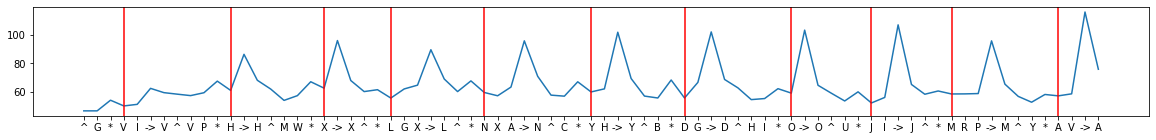

[0.017 0.002 0.011 0.    0.    0.001 0.    0.044 0.    0.088 0.13 ] 
 tensor(0.0266, grad_fn=<MeanBackward0>)


In [3504]:
qh = ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*1)[:, src:src+1]
kh = attn_hidden_states[layer2]
# kh = ln2(attn_outputs[9])
logits = (qh * kh).sum(dim=-1).squeeze(0)
_ = test(None, None, logits=logits, always_show=True)

In [11]:
texts = {
    'find lowercase': '''
X C e -> e
S f Z -> f
K y N -> y
q M N -> q
u S N -> u
S v Y -> v
v I J -> v
Y a N -> a''',
    'AbC->B': '''
X C e -> E
S f Z -> F
K y N -> Y
q M N -> Q
u S N -> U
S v Y -> V
g I J -> G
Y a N -> A
L n J -> N
d H I -> D
Z r C -> R
U S t -> T
K r A -> R
I G m -> M
t O X -> T''',  # failed, but GPT-3 can with low prob
    'set diff': '''
G L C, G L -> C
Y P J, Y P -> J
E S A, S A -> E
U P W, U P -> W
W Z A, W A -> Z
Z Q J, Z J -> Q
C Y L, Y L -> C
C K Z, C Z -> K
K O Q, O Q -> K
K O N, K N -> O
R U P, R P -> U
X C J, X C -> J
B G V, G V -> B
H V L, H V -> L
J K M, J M -> K
N W K, W K -> N
F B D, F B -> D''',
    'find majority': '''
n d d -> d
f f d -> f
e b e -> e
s q s -> s
d d o -> d
c e e -> e
g t g -> g
i i w -> i''', # basically failed
    'find special': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',  # failed, GPT-3 failed, too
    'find special2': '''
n d d d -> n
f f f d -> d
e b e e -> b
s s q s -> q
d d d o -> o
e c e e -> c
g g g t -> t
w i i i -> w''',  # failed, but GPT-3 can
    'ABC,AXC->X': '''
D O Q, K O Q -> K
K H N, K O N -> O
R X P, R U P -> U
X C G, X C J -> J
Z G V, B G V -> B
H V T, H V L -> L
J E M, J K M -> K
A W K, U W K -> U
F B Y, F B D -> D''',
    'reverse set diff': '''
O Q, K O Q -> K
K N, K O N -> O
R P, R U P -> U
X C, X C J -> J
G V, B G V -> B
H V, H V L -> L
J M, J K M -> K
W K, N W K -> N
F B, F B D -> D''',
    'set diff2': '''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'find next': '''
W S D L, S -> D
F M W Q, F -> M
T W A V, A -> V
U V N M, N -> M
S D N O, S -> D
A S B T, S -> B
H W L Z, H -> W
C L J O, J -> O
T B A E, B -> A
L G C K, L -> G
G B S O, G -> B
K Y F O, F -> O
V Q U S, V -> Q
S E Y P, Y -> P
X D A U, A -> U
T L M N, L -> M
U O Y I, O -> Y''',  # failed, GPT-3 failed too
    'antonym': '''
big -> small
low -> high
fast -> slow
dark -> light
long -> short''',
}

In [ ]:
try:
#     with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     attn = outputs.attentions[layer]
#     print(attn[0, head, src, ans_positions[:-1]])
#     attn[0, head, src] = 0
#     attn[0, head, src, ans_positions[-8]] = 1
#     print(attn[0, head, src, ans_positions[:-1]])
#     m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    m.attn_mask = None
#     m.w = None

In [258]:
def norm(tensor): return round(tensor.abs().mean().item(), 4)
hidden_states.mean(), hidden_states.std()
for l in range(layer, layer2):
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].attn_output
    print(norm(h[l].attn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].ffn_output
    print(norm(h[l].ffn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())

(tensor(-0.7157, device='cuda:2'), tensor(17.1320, device='cuda:2'))

2.3035 0.7521 2.545 tensor(-0.7262, device='cuda:2') tensor(17.2453, device='cuda:2')
2.545 0.7547 2.7227 tensor(-0.7361, device='cuda:2') tensor(17.7049, device='cuda:2')
2.7227 0.7046 2.9372 tensor(-0.7366, device='cuda:2') tensor(17.8712, device='cuda:2')
2.9372 0.8032 3.1048 tensor(-0.7600, device='cuda:2') tensor(18.7369, device='cuda:2')
3.1048 0.8814 3.2894 tensor(-0.7694, device='cuda:2') tensor(18.9570, device='cuda:2')
3.2894 0.8759 3.2595 tensor(-0.7893, device='cuda:2') tensor(19.1697, device='cuda:2')


In [257]:
_hidden_states = h[layer2].ln_1(hidden_states)
try:
    with torch.no_grad(): _, attn = am2(am2_hidden_states, am2_attention_mask, output_attentions=True, q_hidden_states=_hidden_states)
finally: am2.q_hidden_states = None
attn = globalize(attn)
attn[0, head2, -1].topk(5)

torch.return_types.topk(
values=tensor([0.4904, 0.3162, 0.0501, 0.0432, 0.0416], device='cuda:2'),
indices=tensor([42, 43, 36, 44, 46], device='cuda:2'))

In [326]:
with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

for l in range(layer, layer + 1):
    mask_tgt_indices = [41, 35, 29, 23, 17, 11, 5]
    excluded_src_indices = [seq_len - 1] #if l == layer else []
    attn = outputs.attentions[l]
    if attn.dim() == 5:
        attn = attn[:, 0, :, :, -seq_len:] # (bsz, num_blokcs, H, seq_len, window_size + seq_len) -> (bsz, H, seq_len, seq_len)
#     for hd in range(H):
#         for src_idx in range(seq_len):
#             if hd != head and src_idx in excluded_src_indices:
#                 attn[:, hd, src_idx] = 0
    for hd in range(H):
        for src_idx in range(seq_len):
            for tgt_idx in range(seq_len):
                if hd == head and src_idx not in excluded_src_indices and tgt_idx in mask_tgt_indices:
                    attn[:, hd, src_idx, tgt_idx] = 0
    h[l].attn.attention.w = outputs.attentions[l]
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    for l in range(layer, layer2):
        h[l].attn.attention.w = None
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'44 E': 0.7865, '43 V': 0.1431, '38 K': 0.0355, '45 H': 0.0323, '37 A': 0.001}

{'ĠE': 0.8562, 'ĠH': 0.1216, 'ĠV': 0.0133, 'ĠD': 0.0009, 'ĠI': 0.0007}

{'28 ->': 0.6616,
 '40 ->': 0.3003,
 '22 ->': 0.0244,
 '34 ->': 0.013,
 '16 ->': 0.0003}

{'ĠT': 0.2914, 'ĠC': 0.1015, 'ĠL': 0.0839, 'ĠY': 0.0793, 'ĠE': 0.0643}

In [70]:
head_attrs = all_attrs['A B C D -> a'].sum(dim=(2, 3))
# head_attrs = attrs.sum(dim=(2, 3))

values, indices = head_attrs[:, :].view(-1).topk(10)
indices = unravel_index(indices, head_attrs.size())
top_heads = [(l, h, round(v, 8)) for l, h, v in zip(
    indices[0].tolist(), indices[1].tolist(), values.tolist())]
top_heads

[(17, 1, 1.08707237),
 (19, 21, 1.00648546),
 (21, 13, 0.78149551),
 (17, 10, 0.68284625),
 (17, 15, 0.63359404),
 (18, 18, 0.62241864),
 (22, 15, 0.52263898),
 (20, 5, 0.45230082),
 (19, 17, 0.36873266),
 (21, 4, 0.33636701)]

In [26]:
inputs = tokenizer.encode_plus(_text, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
y = logits[0, -1].max()
attentions = outputs.attentions if hasattr(outputs, 'attentions') else outputs[-1]
for a in attentions: a.retain_grad()
model.zero_grad()
y.backward()

# attns = torch.cat(attentions)
grads = torch.cat([a.grad for a in attentions])
attrs2 = attns * grads

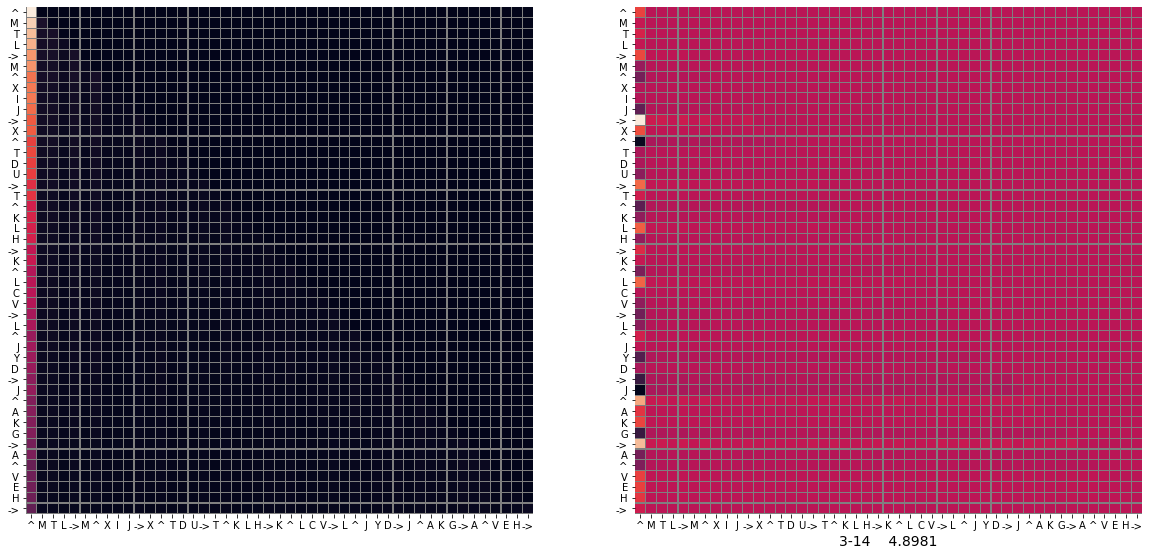

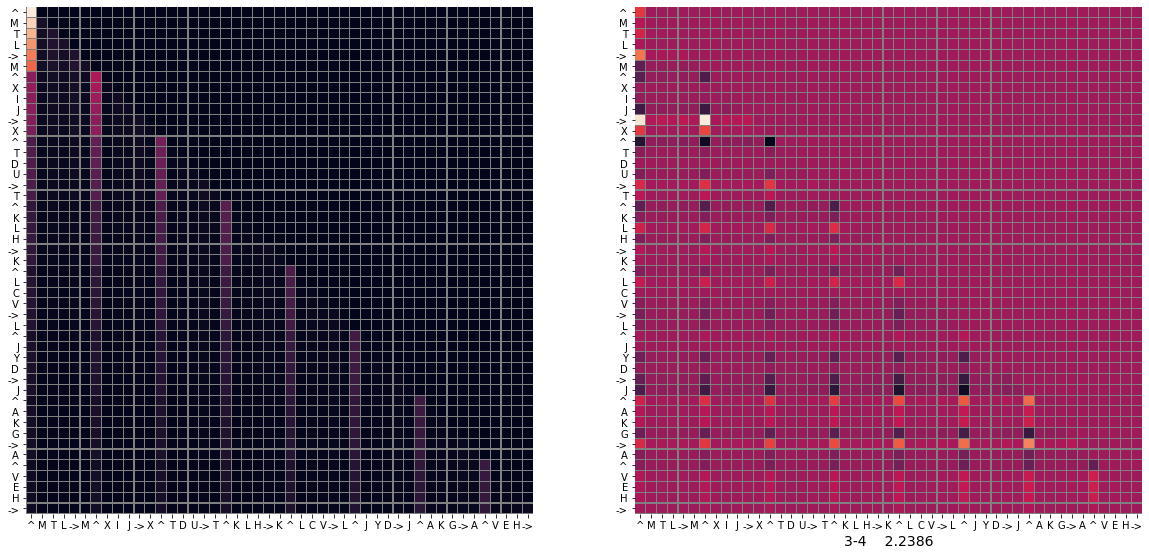

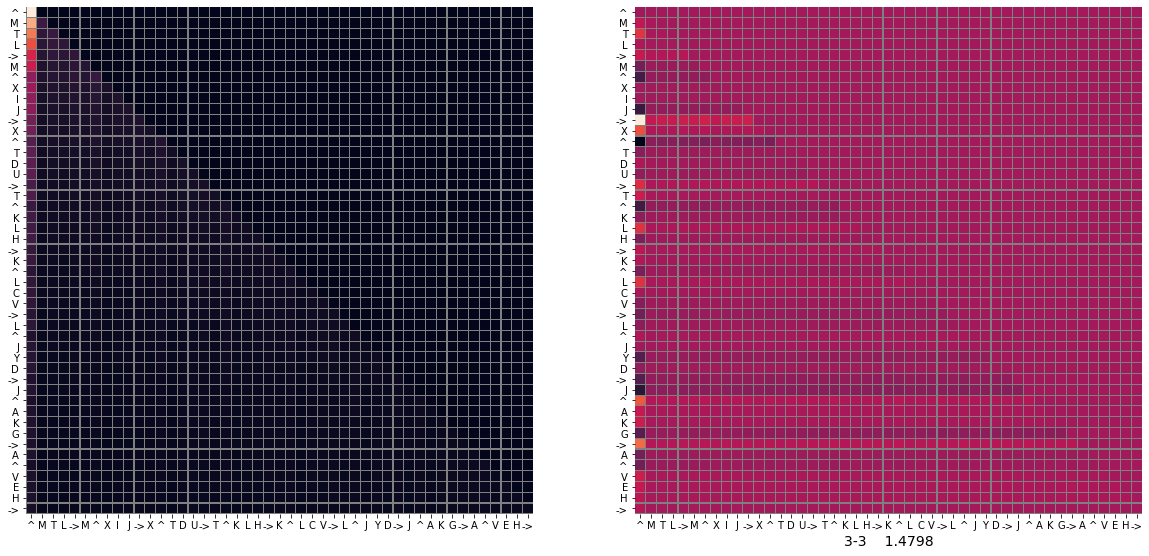

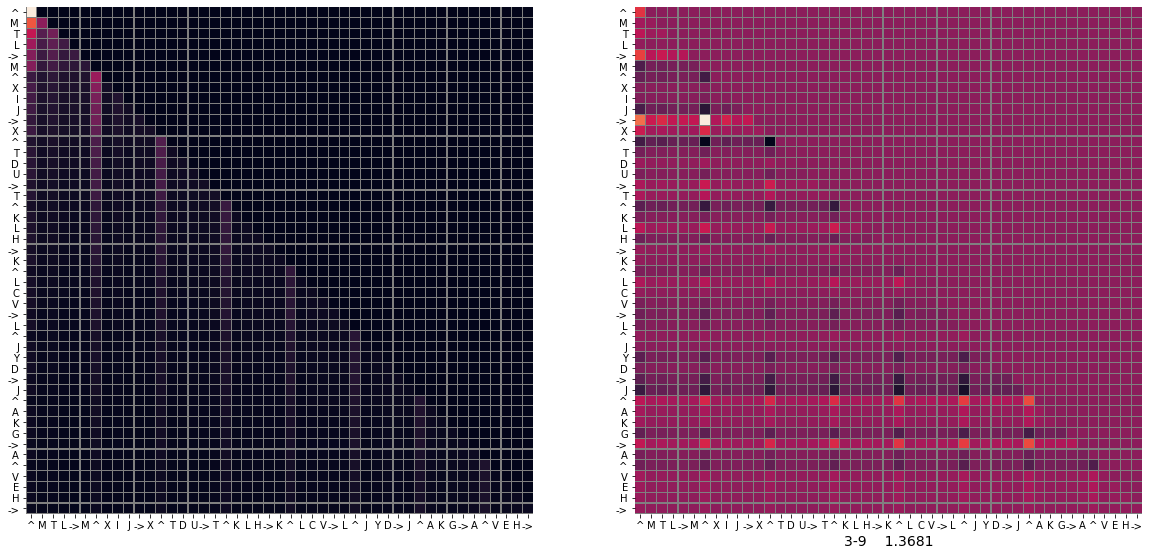

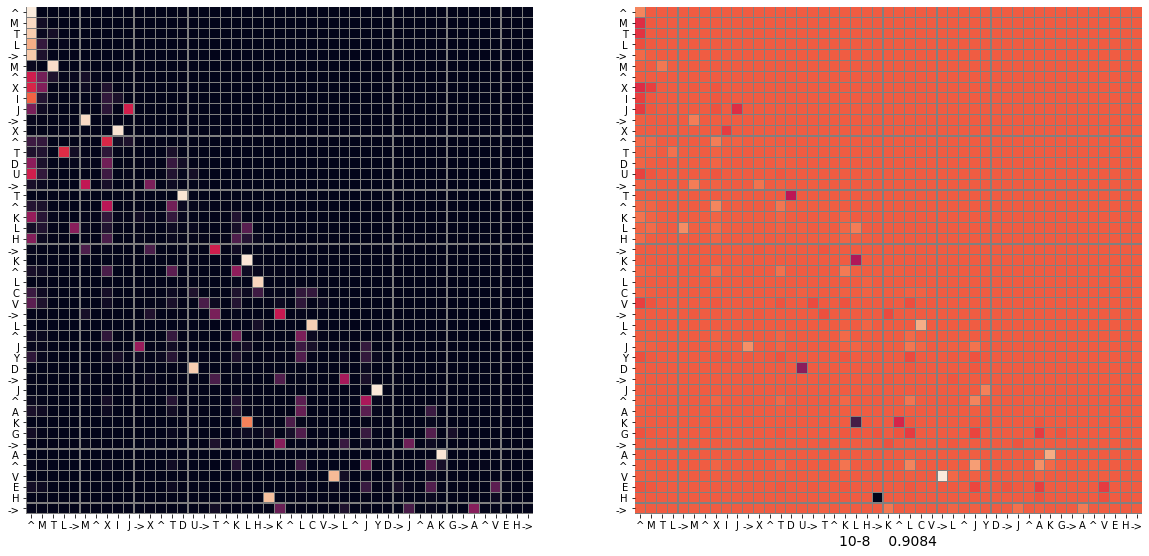

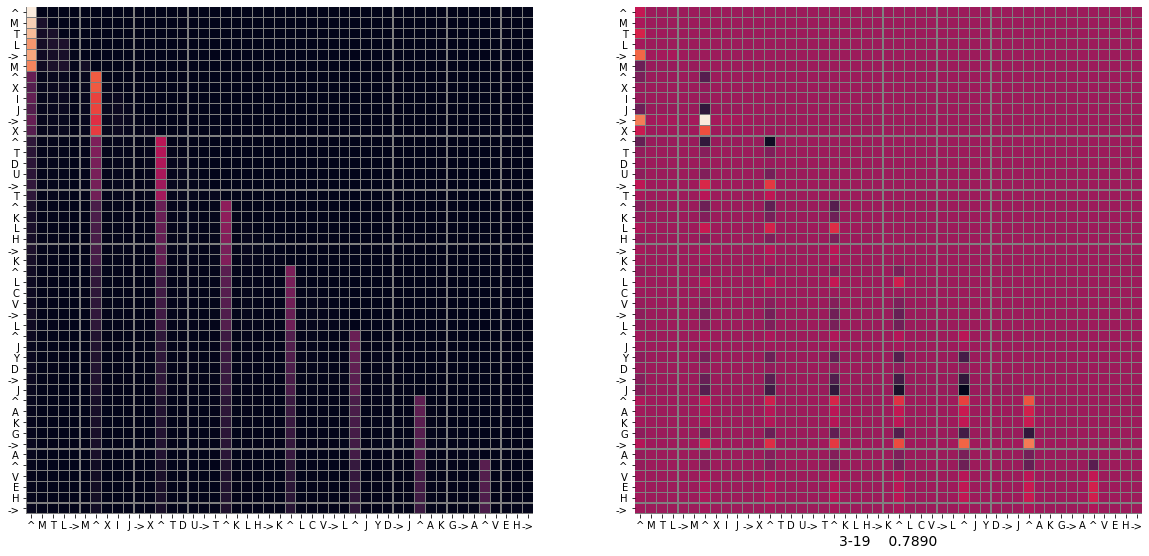

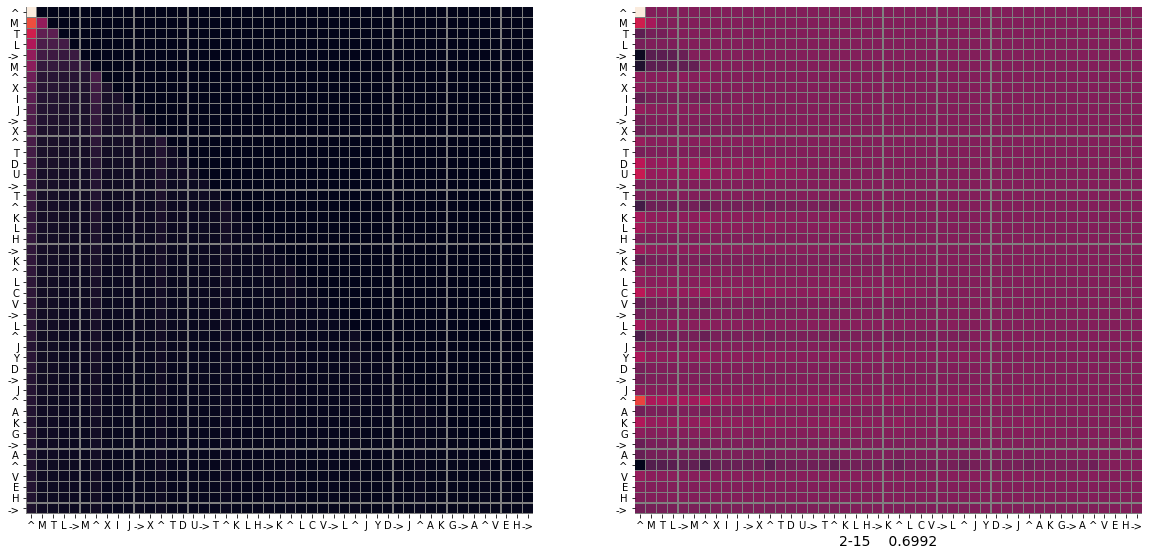

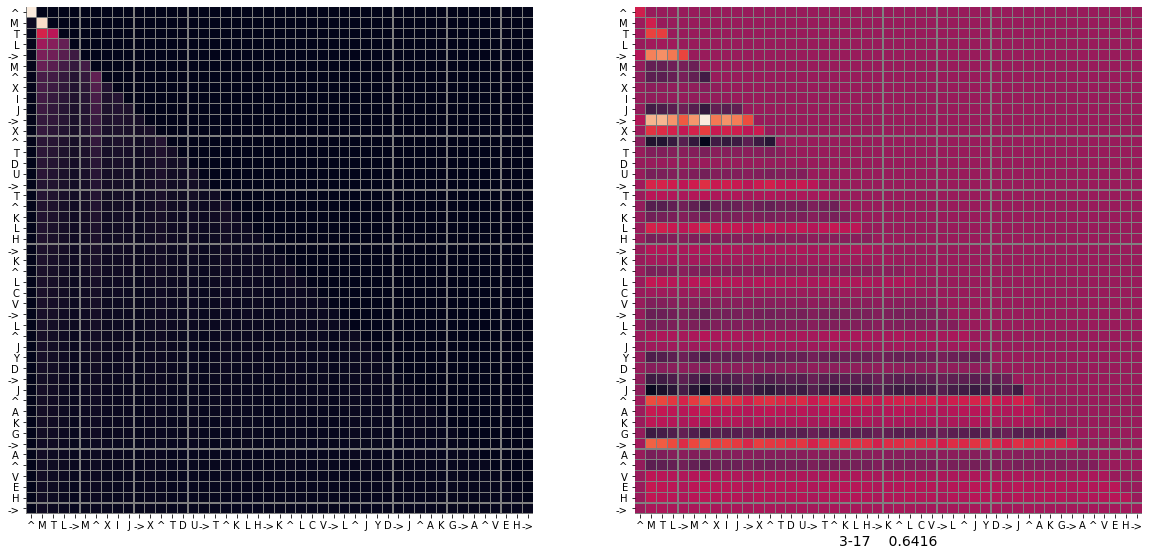

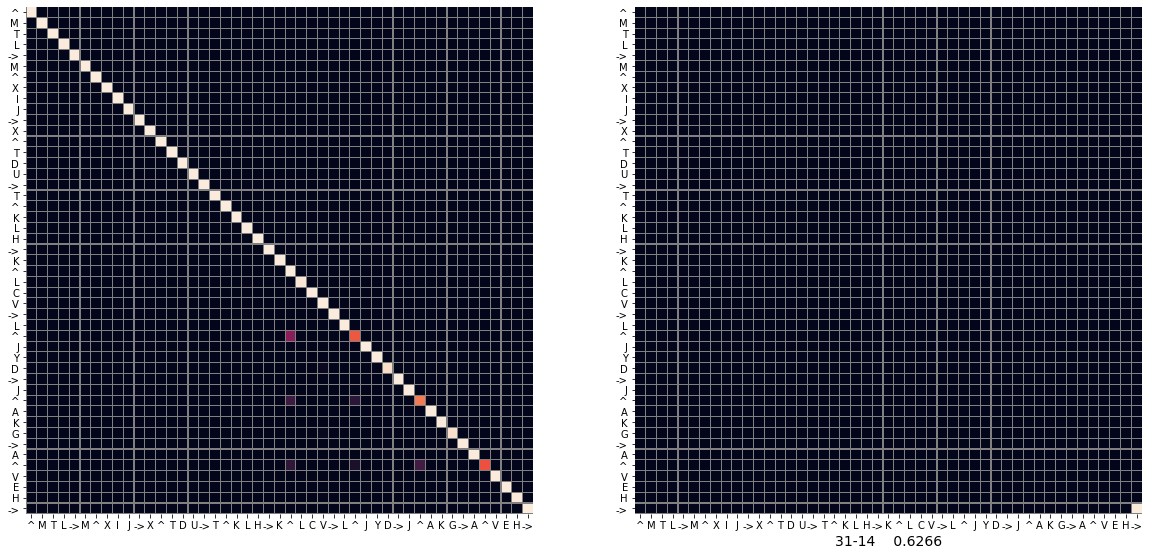

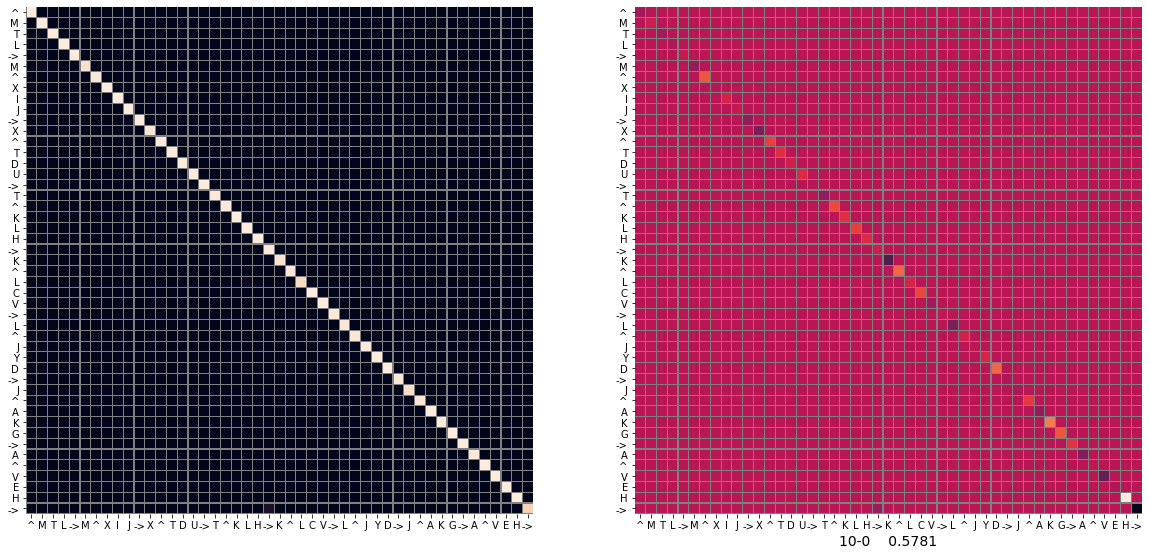

In [259]:
for i in range(len(top_heads)):
    layer, head, v, _ = top_heads[i]
    if layer in [0, 1, ]: continue
#     layer, head, v = 30, 10, 1.
    fig, axs = plt.subplots(1,2,sharey=False, figsize=(10 * 2, 10))
    for i, (a, _ax) in enumerate(zip([attns, attrs], axs)):
        a = a[layer][head].detach().cpu()
        a, annot = ((a * 100).long(), True) if i == -1 else (a, False)
        res = sns.heatmap(a, square=True, cbar=False, annot=annot, fmt='d', linewidths=0.1, linecolor='grey', 
                          xticklabels=tokens, yticklabels=tokens, ax=_ax)
        _ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = plt.xlabel('%d-%d    %.4f' % (layer, head, v), fontsize=14)

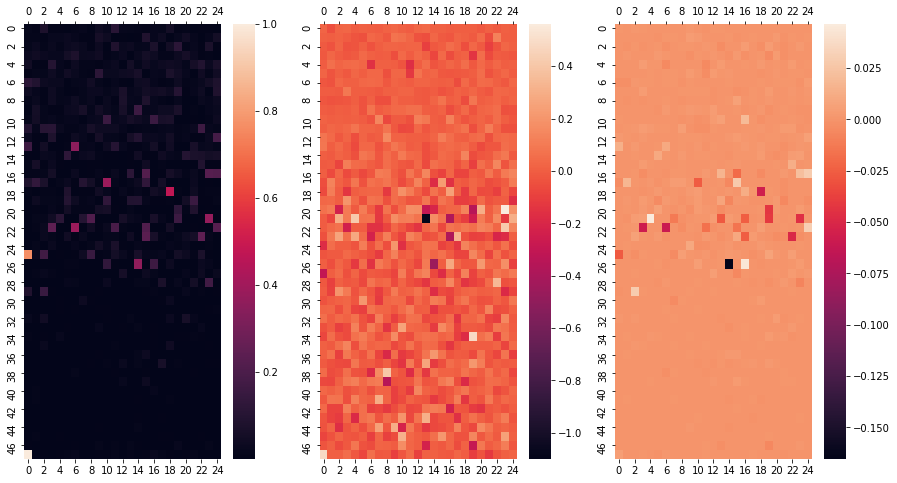

In [555]:
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(5 * n_cols, 2 * 4 * n_rows))
A = [attns, grads, attrs]

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row][col] if row > 1 else axs[col]
        a = A[col][:, :, src,tgt].detach()
        if col == 0: a[-1, 0] = 1.
#         fig = plt.subplots(1,1,sharey=False, figsize=(5 , 8))
        ax = sns.heatmap(a, ax=ax)
        ax.tick_params(top=True, labeltop=True)

In [383]:
logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
values, indices = logits[0, -1].softmax(dim=-1).topk(5)
list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

In [132]:
input_ids = tokenizer.encode_plus(_text)['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

input_ids = input_ids[: -3] + input_ids[-2:]
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '▁', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1>.</s>
['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1> welcome.</s>


In [342]:
texts = [
    'Big is to small as fast is to _',
    'Bread is to eat as gun is to _',
    'big: small, fast: _',
    'bread: eat, gun: _ .',
    'flower: fragrant, fire: hot, bread: delicious, gun: _ ',
    'Big and small are _ .',
    'What is twice 3? _.',
    'What is the half 6? _.',
    'There is a sequence: 3, 5, 2, 7. The number immediately precedes 5 is _.',  # :)
    'There is a sequence: 3, 5, 2, 7. The number immediately follows 5 is _.',  # :(
    'There is a sequence: 3, 5, 2, 7. The number between 5 and 7 is _.',
    'There is a sequence of numbers: 3, 5, 2, 4. _ is the first number.',
    'There is a sequence of numbers: 3, 5, 2. The reversed sequence is _.',
    '''There is a sequence of numbers: 5, 1, 6, 3. The second number is 1.
There is a sequence of numbers: 3, 7, 2, 4. The second number is _.''',
    '''There is a sequence of letters: e, c, b, a. The last letter is a.
There is a sequence of letters: f, d, b, g. The last letter is _.''',
    '''The uppercase of c is C. The uppercase of f is _.''',
    '''The successor of 3 is 4. The successor of 8 is _.''',
    '''The successor of 3 is 4. The successor of _ is 6.''',
#     '''The predecessor of 3 is 2. The predecessor of 5 is 4. The predecessor of 6 is _''',
#     '''The previous integer of 4 is 3. The previous integer of 3 is _.''',
#     '''3 minus 1 equals 2. 5 minus 1 equals _.''',
    '''If 2 changes to 3, 5 changes to 6, then _ changes to 9''',
    '''If 2 changes to 20, 3 changes to 30, then 5 changes to _''',
    '''2 -> 3, 4 -> 5, 5 -> 6, 9 -> _.''',
    '''3 -> 2, 5 -> 4, 6 -> 5, 9 -> _''',
    '''9 -> 8, 7 -> 6, 6 -> 5, 2 -> _.''',
    '''3 is to _ as 4 is to 8 and 5 is to 10.''',
#     '''6 : _ :: 5 : 10 :: 7 : 14 :: 8 : 16.''',
#     '''a is to _ as f is to g, h to i, i to j, s to t.''',
#     '''c is to _ as f is to e, h to g, j to i.''',
    '''c is to _ as j is to i, h to g, f to e.''',
#     '''Twice 3 is 6, twice 4 is _.''',
#     '''Half of 4 is 2, half of 6 is _.''',

# '''Shall I compare thee to a summer's day?
# Thou''',
# '''Do not go gentle into that good night,
# Old age should burn and rave at close of day;
# Rage'''
]

In [5]:
class CFG(object):
    def __init__(self):
        self.prod = defaultdict(list)  

    def add_prod(self, lhs, rhs):
        """ Add production to the grammar.
        """
        prods = rhs.split(' \\ ')
        allslices.append(lhs)
        for prod in prods:
            for sp in prod.split():
                if sp not in allslices:
                    allslices.append(sp)
        for prod in prods:
            self.prod[lhs].append(tuple(prod.split()))

    def xss_add_prod(self, lhs, rhs):
        """ Add production to the grammar.
        """
        prods = rhs.split(' | ')
        allslices.append(lhs)
        for prod in prods:
            for sp in prod.split():
                if sp not in allslices:
                    allslices.append(sp)
        for prod in prods:
            self.prod[lhs].append(tuple(prod.split()))

    def get_sli_number(self,
                    choice,
                    slistr,  #
                    ):
        for i in range(len(choice)):
            if choice[i]==slistr:
                return i
        return len(choice) 

    def get_ch_sli(self,
                slinum,
                choice,
                ):
        if slinum>=len(choice):
            return 0
        else:
            return choice[slinum]

In [6]:
def Read_list(filename):
    file1 = open(filename+'.txt','r')
    list_row =file1.readlines()
    # print(list_row[0])
    list_source = []
    for i in range(len(list_row)):
        column_list = list_row[i].strip().split(' ')
        # print(column_list)
        # list_source.append(column_list[:])
        list_source.append(column_list[:-1])
    for i in range(len(list_source)):
        for j in range(len(list_source[i])):
            list_source[i][j]=int(list_source[i][j])
    file1.close()
    return list_source



In [2]:
ans =set()
from tqdm import tqdm
with open('/nas/xd/data/waf/all_data/all_sqli.txt','r') as f:
    for line in tqdm(f.readlines()):
        ans.add(line.strip())

100%|██████████| 162109992/162109992 [02:07<00:00, 1276040.29it/s]


In [1152]:
len(ans)

162109992

In [1073]:
# count =0


In [3]:
allslices = []
def mainsql(filepath):
    cfg = CFG()
    with open(r"/nas/xd/data/waf/MLWAF/waf-ml/bnf-sql.txt","r") as f:
        for line in f.readlines():
            line = line.strip('\n')
            bnflist = line.split(':=')
            cfg.add_prod(bnflist[0],bnflist[1])
    newallsli = []
    for slic in allslices:
        if slic not in newallsli:
            newallsli.append(slic)
    choicelist = Read_list(filepath)
    allcount=0
    result=[]
    bypasscount=0
    bad=0
    good=0
    for j,schoice in enumerate(tqdm(choicelist)):
        global datafram
        datafram = schoice
        tmpstr = ''
        allcount = allcount + 1
        for dnum in datafram:
            sli = cfg.get_ch_sli(int(dnum),choice = newallsli)
            if sli not in cfg.prod:
                tmpstr = tmpstr + sli
        data_list.add(tmpstr)


In [21]:
#having tree
data_list =set()
mainsql('/nas/xd/data/waf/data_ablation_pretrainnotree/generatesql_mod/generatetrl16')
# mainsql('/nas/xd/data/waf/data_ablation_pretrainnotree/generatesql_mod/generate')
# mainsql('/nas/xd/data/waf/data_ablation_pretrain/generatesqlnaxsipre24/generate24')
# mainsql('/nas/xd/data/waf/data_ablation_pretrain/generatesqlmodpre24/generate24')

100%|██████████| 479003/479003 [00:04<00:00, 119357.44it/s]


In [17]:
len(ans)

162109992

In [1129]:
# list(data_list)[0]

"0'or+@<@+or%0bnot%0b1=+(false)+or'"

In [22]:
result = []
for data in list(data_list):
    if data not in ans:
        result.append(data)

In [23]:
len(result)

755

In [1137]:
'0%27<@=.1+or+{a+1}=1%0blike+false--+' in ans

False

In [15]:
with open('/nas/xd/data/waf/invalid','w') as f:
    for data in result:
        f.write(data+'\n')

47

43

43

35

46

45

47

30

54

51

48

47

47

48

56

46

67

44

60

45

55

41

46

56

56

43

39

57

48

54

46

40

62

55

53

55

50

52

57

49

38

44

39

49

47

53

48

46

49

58

51

48

46

39

59

59

38

46

51

44

50

50

44

55

43

44

50

52

43

45

55

43

53

47

45

46

48

57

48

44

54

54

44

57

61

57

51

55

54

40

51

54

49

50

50

59

59

48

59

48

50

44

44

55

50

65

67

45

57

50

53

59

59

45

50

44

49

38

59

53

52

59

53

47

42

45

44

52

71

67

52

50

51

44

43

50

41

52

60

39

41

47

53

69

39

44

48

61

47

50

35

41

52

52

50

45

65

52

48

57

44

63

45

47

52

49

75

49

52

48

53

65

54

58

63

47

43

43

59

50

55

46

47

50

63

47

52

50

50

48

55

48

41

41

43

47

56

43

57

55

44

49

51

51

56

51

50

32

48

50

48

53

49

47

45

50

47

49

57

57

47

46

51

49

50

48

51

48

49

55

47

33

47

45

48

55

49

41

52

50

49

45

46

46

61

44

61

48

52

56

57

53

52

51

47

52

56

58

53

53

58

48

66

48

53

64

38

62

60

48

56

51

53

48

61

71

54

37

42

55

53

48

51

49

54

45

46

53

49

44

50

59

44

44

44

52

47

54

41

50

61

48

57

59

44

41

48

43

73

45

47

51

55

53

56

49

54

53

49

33

55

63

34

52

41

53

57

59

48

40

43

57

49

48

53

48

49

37

53

48

44

56

55

59

47

60

44

51

49

55

44

50

49

46

43

41

46

41

53

46

55

46

51

45

52

52

51

40

47

50

50

55

55

53

56

54

48

47

46

64

48

49

51

49

42

46

46

49

46

48

46

56

55

48

52

57

44

59

45

52

49

56

48

52

47

48

50

58

57

57

59

53

51

50

49

46

51

49

55

51

45

51

53

44

48

58

57

45

56

46

49

51

55

46

52

60

61

63

69

47

60

65

53

60

41

53

46

40

56

43

59

56

48

47

55

50

45

50

47

47

49

44

27

42

47

56

53

44

39

43

55

53

54

44

58

55

48

46

43

45

57

53

46

63

51

61

42

42

52

52

54

41

52

51

59

49

42

57

57

48

47

52

48

43

59

45

48

48

35

47

43

40

44

51

46

63

61

59

49

47

42

45

52

45

48

45

50

53

49

43

45

62

47

46

53

37

58

56

50

57

53

60

45

55

37

46

48

45

55

51

51

54

50

35

51

69

53

47

49

63

47

56

51

61

45

55

64

49

54

53

55

48

41

50

45

49

53

46

50

51

39

45

50

51

50

61

65

45

45

51

42

48

69

44

49

45

49

63

46

45

45

56

43

52

48

52

43

39

41

63

45

59

39

47

45

52

43

58

52

40

46

41

51

50

47

53

48

42

57

53

46

59

43

44

41

53

37

60

59

48

46

39

42

43

45

48

61

52

43

51

43

62

50

57

44

41

53

51

47

38

58

43

39

52

51

48

43

51

53

42

42

51

46

46

62

45

59

44

49

48

43

55

47

48

52

47

51

41

53

49

49

50

45

43

47

50

45

58

50

63

51

50

48

52

50

44

55

50

53

43

60

48

52

49

51

57

47

55

50

42

47

52

52

58

53

51

48

46

41

56

40

46

53

61

41

53

45

51

48

58

63

49

51

48

56

52

58

47

46

46

40

40

43

50

55

51

54

52

47

55

43

53

50

63

38

52

41

47

46

48

57

55

45

39

52

51

56

46

41

46

53

56

49

51

46

53

51

44

58

52

48

48

50

55

50

46

44

55

47

50

55

40

49

48

44

50

50

32

59

63

57

53

41

53

61

48

63

53

52

45

45

45

48

44

50

42

46

44

47

53

45

54

55

50

51

48

41

46

47

42

42

49

45

46

56

53

53

52

56

44

49

53

49

48

52

44

54

57

42

45

55

40

51

50

56

48

54

57

65

53

60

49

46

50

48

63

50

39

51

50

52

48

51

48

53

49

54

58

46

48

50

52

50

54

63

55

50

54

48

52

53

54

48

49

68

48

46

47

47

47

46

55

48

43

44

56

49

51

58

50

46

51

53

59

51

48

55

44

71

48

36

45

55

50

43

51

43

57

49

52

46

39

46

45

41

50

53

49

42

53

48

47

59

48

66

49

51

69

67

50

50

48

48

51

48

40

34

49

45

53

48

50

57

68

43

61

55

52

49

45

59

50

52

46

52

50

58

50

51

54

46

62

45

46

56

49

45

52

48

61

47

46

66

65

54

45

52

48

49

51

49

52

54

39

50

57

58

67

58

46

55

47

54

50

40

47

59

51

55

52

50

48

57

47

45

50

58

44

53

58

53

41

45

55

50

53

57

43

53

39

66

45

41

42

47

42

41

51

55

57

41

53

34

50

53

49

57

43

62

41

46

57

57

38

52

44

48

33

55

46

48

41

59

58

51

43

54

50

44

56

51

44

46

47

46

65

44

51

50

48

75

51

53

36

49

46

50

48

54

49

41

52

67

61

55

51

39

50

41

57

49

56

57

46

62

53

44

46

56

52

61

56

52

44

48

55

53

40

45

49

48

51

54

45

51

48

46

45

43

50

50

46

44

54

49

39

43

49

59

45

46

63

59

54

45

63

51

41

54

55

54

59

49

50

46

46

47

45

45

57

50

50

53

49

44

56

51

51

54

41

51

43

45

67

47

43

45

40

47

50

55

37

46

44

52

54

61

52

41

42

60

57

40

32

47

57

52

35

49

57

48

63

52

59

50

47

46

45

58

48

47

51

45

53

59

52

50

58

39

49

67

51

72

47

39

46

54

48

52

57

41

43

56

48

49

49

52

51

50

56

55

40

56

51

42

46

45

43

54

63

59

53

35

47

68

40

47

32

46

53

49

58

46

52

43

52

42

51

40

41

50

52

46

64

45

41

48

55

47

43

52

47

54

43

53

46

53

60

45

47

48

61

59

54

63

54

51

50

51

46

54

43

44

50

44

49

42

44

54

50

48

53

56

49

49

54

44

50

53

57

51

50

63

47

55

48

48

52

51

39

40

47

48

41

55

58

50

47

41

43

39

42

60

46

46

47

44

53

63

46

45

54

41

45

62

47

46

49

46

53

52

52

45

50

53

46

50

48

58

52

51

44

51

65

50

46

42

69

57

52

39

50

41

45

50

41

57

44

67

46

59

54

44

43

50

50

53

51

52

58

46

63

50

54

42

35

47

53

41

49

57

49

55

42

41

51

51

48

55

61

52

49

53

47

45

49

52

42

55

55

51

52

43

49

45

53

49

42

48

45

53

47

52

61

53

43

39

65

53

47

43

41

49

45

48

54

55

50

53

45

60

47

53

45

50

42

42

42

49

52

44

52

55

42

47

49

44

45

73

39

42

51

39

58

45

57

65

48

53

45

40

44

61

60

60

39

63

58

48

55

57

54

50

40

58

56

52

51

52

57

48

55

56

45

41

54

51

72

50

48

50

61

51

56

46

49

59

49

44

60

40

69

59

57

53

46

45

56

55

58

45

59

48

47

50

46

60

59

46

46

52

69

44

48

59

60

50

62

47

48

43

60

47

61

37

47

51

52

43

51

44

55

52

58

41

48

43

53

39

46

51

48

53

46

55

50

62

67

40

56

58

49

49

52

63

53

48

61

51

43

53

41

45

53

46

50

47

47

39

48

49

53

40

46

54

54

50

48

42

52

73

41

59

38

44

55

58

51

51

46

48

60

44

51

53

53

49

60

42

47

52

60

49

58

60

49

51

41

50

45

46

46

42

53

50

44

50

60

47

58

44

43

63

44

41

50

48

43

48

54

48

54

54

67

38

45

55

46

37

50

69

50

54

43

50

51

55

52

55

43

53

55

50

52

48

44

67

47

43

53

45

43

64

47

46

57

68

45

45

55

55

49

46

41

42

59

48

47

44

44

41

57

41

42

53

52

45

42

56

62

60

53

42

40

53

48

54

57

51

50

53

53

41

49

54

58

54

72

54

48

53

45

46

46

47

54

58

52

39

51

49

40

41

44

46

61

49

39

46

48

47

58

55

53

41

50

43

48

53

44

44

48

44

48

54

63

46

57

43

45

50

50

37

40

46

70

54

48

53

48

44

47

57

53

53

54

45

45

56

55

44

41

55

46

44

48

56

65

50

45

56

69

52

63

58

63

53

49

56

52

44

45

49

51

55

59

44

44

51

49

53

52

57

63

52

44

41

59

50

39

50

37

42

47

63

67

41

45

53

43

54

58

40

49

53

49

53

52

42

47

43

45

51

40

58

56

53

46

46

55

48

42

49

45

59

51

56

54

46

40

50

47

59

62

57

51

45

53

42

62

41

55

43

46

58

52

44

51

49

41

49

50

51

52

51

39

65

48

40

47

52

58

49

43

46

57

48

47

47

44

57

51

49

50

47

47

42

40

59

42

50

41

45

68

44

54

58

56

41

52

49

52

61

47

45

42

56

55

49

63

56

52

54

48

53

55

44

47

50

54

48

45

40

48

56

50

63

54

56

54

53

47

50

44

50

37

50

55

50

48

47

69

39

53

53

49

61

59

48

61

59

47

52

44

45

41

50

50

48

45

44

45

52

59

50

61

47

43

46

48

73

49

43

61

63

49

46

55

56

46

56

43

55

65

40

56

44

42

47

51

55

49

44

42

49

49

50

67

35

42

44

46

44

48

52

56

56

57

65

51

44

37

55

47

51

49

52

54

45

55

61

49

50

61

53

65

54

50

61

57

43

50

50

44

58

44

48

55

42

50

42

46

49

49

52

56

43

56

54

65

54

43

50

42

55

44

52

47

48

51

59

47

48

57

56

43

40

64

51

48

48

41

61

57

50

46

50

43

52

54

48

44

56

42

56

60

52

44

69

59

39

48

41

45

61

44

49

42

47

54

51

50

53

41

52

51

44

51

54

56

42

53

46

56

61

44

48

48

45

44

58

69

51

49

47

51

71

47

44

41

50

45

48

53

44

51

47

49

43

65

46

47

50

49

53

44

47

50

48

49

55

48

55

50

49

57

59

48

40

57

46

59

56

45

28

42

46

48

56

51

49

50

45

48

65

43

43

45

48

41

48

54

47

42

56

43

67

40

46

47

46

40

47

50

52

47

45

58

50

56

75

57

52

45

50

57

54

49

53

54

59

46

61

58

46

53

46

39

46

45

58

58

45

51

44

43

54

44

47

49

48

64

53

54

46

52

44

46

46

63

39

50

50

64

49

42

40

41

45

43

48

52

45

54

31

53

48

64

65

50

49

44

43

66

45

53

48

43

53

54

55

55

46

55

50

51

46

49

51

50

41

59

69

52

53

41

50

49

53

49

55

48

42

48

46

56

54

40

45

41

46

47

54

53

46

38

48

44

50

58

47

58

39

50

55

54

49

50

45

52

44

61

51

57

47

50

61

72

44

53

57

44

55

43

54

57

63

53

62

49

42

49

48

47

48

48

63

51

47

42

55

43

50

52

60

46

53

65

50

52

52

45

56

40

50

47

55

51

51

47

56

47

49

55

47

49

52

47

56

39

45

36

46

53

52

39

45

49

48

41

48

50

52

53

57

48

48

54

55

50

42

69

37

52

51

55

49

55

58

41

48

46

41

49

43

49

53

44

49

57

46

44

48

44

48

46

45

55

50

47

38

62

45

46

61

45

52

59

47

61

55

60

55

52

48

44

49

57

49

69

46

42

50

42

57

50

55

54

50

46

61

48

56

44

51

44

51

53

51

54

49

39

51

43

58

53

51

50

45

49

49

56

60

48

50

43

51

69

55

51

60

43

36

52

60

52

51

48

46

40

49

42

69

42

55

48

46

60

50

48

50

61

55

60

39

51

41

49

48

37

47

48

47

43

54

45

42

47

46

46

39

54

61

46

56

52

45

56

52

50

39

49

67

51

61

54

47

55

50

51

55

58

50

51

59

52

49

42

45

56

47

51

46

49

49

52

48

74

50

48

56

57

53

51

45

47

50

56

45

40

63

62

43

62

40

45

52

47

50

53

48

43

44

48

49

47

48

55

44

37

58

44

54

47

44

53

60

52

45

46

46

48

53

45

42

51

50

43

39

46

67

67

44

57

48

55

57

44

67

70

50

49

53

42

38

60

50

45

50

46

43

43

45

55

60

48

50

47

54

47

55

51

50

55

46

49

51

49

52

45

51

56

53

49

50

47

44

48

49

46

47

55

45

46

50

46

53

52

35

52

58

61

48

47

73

43

47

54

58

54

57

50

48

55

63

49

60

51

51

48

43

42

67

48

48

50

45

46

53

52

50

40

47

56

47

47

43

48

44

37

46

55

52

50

49

52

50

46

61

41

59

56

45

76

54

54

46

49

50

55

41

65

44

56

59

50

51

50

In [ ]:
with open('/nas/xd/data/waf/invalid','w') as f:
    for data in result:
        f.write(data+'\n')

37

44

43

49

42

31

38

52

41

44

42

43

51

44

45

50

27

23

27

40

44

28

47

42

32

32

41

47

39

29

40

39

44

47

42

46

36

38

42

40

37

45

40

43

45

31

41

45

36

42

45

41

46

44

41

44

50

45

37

38

30

39

35

39

55

46

43

32

34

30

48

42

44

34

40

44

44

46

38

37

48

45

52

36

38

35

49

38

50

52

38

46

41

39

45

45

41

43

38

46

39

45

37

42

42

42

42

46

37

38

33

33

44

49

47

45

47

44

37

31

37

38

34

38

38

42

39

47

40

49

43

36

45

33

36

39

42

43

34

37

40

35

44

46

33

34

37

43

38

21

42

39

47

45

43

39

47

39

39

35

42

40

30

45

39

33

46

49

49

36

42

47

32

39

46

40

39

38

40

41

44

41

37

31

42

44

37

37

34

40

41

42

39

38

45

43

35

28

33

48

44

36

41

37

43

37

47

52

38

45

45

48

38

35

46

50

44

42

44

34

39

41

49

46

31

37

33

29

47

46

47

36

47

41

37

43

37

43

43

43

41

38

45

42

44

46

46

37

52

42

45

49

35

50

47

37

46

29

43

38

43

45

30

46

42

39

40

34

36

45

41

44

41

31

46

37

46

40

44

40

37

44

34

47

25

42

49

49

35

45

38

43

34

46

32

38

29

46

40

44

46

31

36

45

40

25

34

36

48

38

45

47

37

43

32

44

48

43

49

44

45

33

26

36

29

44

46

38

40

42

48

54

40

44

38

49

44

31

44

47

41

39

36

43

41

36

34

45

40

41

35

40

31

38

42

43

44

43

40

35

46

34

42

46

33

34

41

53

38

39

45

42

48

48

49

42

39

41

36

30

34

46

36

40

41

42

34

39

47

37

44

43

33

42

34

32

49

45

42

47

48

36

39

36

42

44

39

40

44

42

51

44

41

47

45

46

38

34

33

47

45

41

37

39

33

26

41

46

48

40

30

35

41

36

38

40

32

33

34

43

43

43

36

41

45

44

34

37

53

43

32

39

45

47

34

48

42

48

31

50

43

40

47

44

45

42

32

42

50

46

37

38

45

39

42

47

32

47

42

38

40

34

40

45

40

38

26

45

43

42

39

54

28

34

34

27

42

40

40

35

43

44

36

47

35

41

40

43

42

48

44

41

52

32

40

40

42

41

35

40

47

41

41

32

36

45

45

40

50

35

48

47

33

43

31

38

38

44

44

43

48

47

34

40

51

40

38

40

39

46

44

40

37

44

38

33

47

33

49

36

40

39

45

36

45

37

44

49

48

41

33

38

39

37

33

48

51

39

48

33

38

42

38

36

38

29

41

46

43

40

44

46

41

33

34

44

34

28

45

48

46

34

45

32

43

40

49

37

44

36

39

29

32

46

40

45

50

40

47

39

48

45

35

41

47

35

46

32

39

47

40

40

41

40

39

43

38

42

43

46

38

43

40

34

31

41

53

45

33

54

34

43

44

43

47

50

42

41

49

38

40

37

45

39

47

40

36

45

41

42

39

31

33

35

50

38

42

47

31

50

40

45

37

39

46

40

43

40

31

34

40

44

41

44

46

36

36

47

33

41

45

40

45

50

34

46

48

43

46

43

45

46

46

41

25

39

42

43

45

40

42

32

34

41

38

36

35

43

37

36

34

36

40

52

49

40

47

42

49

49

27

41

36

29

48

46

50

43

30

37

41

34

44

30

35

47

38

37

44

31

40

41

46

44

40

29

47

36

26

45

47

50

37

48

35

45

50

38

40

43

48

31

46

39

38

44

38

43

55

37

53

32

39

30

48

46

50

42

33

46

46

45

45

42

42

43

45

34

52

50

43

45

45

42

41

50

45

37

29

51

38

41

47

53

26

47

41

40

43

48

40

46

25

38

49

46

40

44

33

42

42

28

38

37

41

46

46

27

42

46

33

41

39

44

42

52

39

44

45

44

44

42

48

37

46

40

39

49

50

45

45

43

32

32

38

38

46

43

33

35

46

46

48

42

37

39

45

46

46

47

34

39

41

39

41

32

32

46

41

45

38

38

41

43

44

37

39

44

33

43

43

42

24

41

39

39

32

48

48

35

39

33

38

40

41

39

45

49

40

44

39

32

39

47

33

42

44

53

47

31

45

48

34

38

29

37

41

42

37

38

44

44

38

36

47

44

34

42

38

39

49

30

47

43

39

46

39

48

42

45

52

32

55

36

48

31

27

31

36

53

40

43

43

36

56

45

41

32

45

48

45

40

31

49

39

44

42

33

44

30

41

44

40

33

43

36

36

49

47

48

43

42

35

31

49

41

38

43

48

51

50

35

38

42

47

44

31

37

52

40

45

37

34

41

42

37

44

41

44

35

43

47

42

41

39

34

39

23

36

37

40

44

48

49

43

51

38

41

39

44

46

43

42

40

35

52

39

36

35

42

44

36

30

38

41

36

39

43

48

50

45

34

42

39

42

42

39

35

29

40

35

38

40

44

41

35

41

42

39

43

36

47

33

40

38

47

35

38

29

46

44

50

42

32

34

37

51

32

36

34

43

44

40

34

41

42

43

46

35

36

54

45

37

35

41

45

28

42

40

45

49

49

46

49

38

40

41

36

39

46

43

33

46

39

45

30

41

46

35

44

52

52

42

41

46

39

42

40

37

43

40

36

48

40

39

39

40

41

38

33

35

31

39

27

49

46

30

44

43

32

45

44

48

40

42

45

31

47

41

32

39

37

40

36

32

45

40

44

38

43

43

50

36

43

34

54

43

39

56

42

46

39

25

47

44

39

46

47

50

45

50

39

37

51

41

47

34

29

34

46

33

46

40

44

38

40

42

29

40

37

35

34

32

39

40

40

39

42

42

39

40

40

40

44

41

39

40

30

40

42

43

44

36

47

41

44

37

43

41

40

44

36

37

45

36

41

50

51

44

40

39

45

41

46

45

51

38

38

39

31

39

43

43

45

41

39

31

47

43

43

34

30

41

41

48

40

37

46

30

51

37

39

43

46

36

34

52

47

35

38

37

41

41

34

38

46

35

35

41

24

36

41

39

32

45

38

34

41

47

38

41

44

46

34

39

50

38

48

49

42

47

30

44

38

54

45

43

44

46

41

47

36

34

37

45

40

35

43

46

39

34

46

41

40

48

47

41

46

42

52

31

46

43

37

52

30

28

46

40

47

44

42

44

40

39

34

38

34

44

39

39

40

45

40

41

51

32

38

45

43

47

38

36

47

43

50

38

47

36

41

36

36

37

45

42

42

41

43

37

42

42

41

47

46

40

38

41

40

48

35

47

41

33

49

34

35

47

47

46

45

42

42

40

42

43

40

37

45

32

39

34

33

47

39

29

39

43

41

47

42

46

38

32

45

36

41

40

40

37

33

32

44

41

35

43

38

37

46

41

34

25

42

37

40

43

46

35

39

39

44

45

32

34

45

37

48

45

44

43

41

31

42

43

32

48

45

42

40

44

44

40

36

42

46

36

44

43

44

44

41

46

42

41

49

45

42

44

39

43

32

42

46

31

40

47

39

44

47

38

36

43

49

47

35

42

47

51

43

42

39

42

41

42

38

29

37

43

43

41

39

46

44

42

48

41

43

43

47

43

48

40

39

47

43

43

45

41

40

32

33

29

46

43

39

45

46

49

43

35

43

42

49

40

42

41

31

43

41

44

34

42

43

39

38

49

39

48

39

31

46

41

42

40

42

40

39

34

51

33

44

47

50

41

36

33

41

42

44

44

41

32

34

48

48

32

47

48

40

51

47

32

31

45

44

46

43

44

45

34

46

39

39

42

54

42

32

34

37

47

38

36

53

45

39

37

46

37

41

40

46

45

35

31

30

41

30

43

30

43

26

44

43

45

38

27

39

40

38

44

38

30

37

42

36

43

48

40

35

35

49

42

43

48

49

48

41

34

34

41

48

36

41

46

45

29

47

40

30

48

43

48

45

41

31

40

44

47

39

48

38

38

45

28

48

43

38

41

46

42

25

31

39

35

40

39

40

34

42

37

39

46

31

43

31

35

34

40

36

34

29

31

36

48

42

39

41

48

36

46

44

43

34

47

47

39

34

37

33

39

36

38

33

36

43

43

30

39

43

41

40

42

46

43

37

36

49

30

41

35

30

37

38

35

40

30

42

51

32

42

33

34

44

40

42

34

43

50

40

43

39

37

39

44

42

47

36

46

36

37

45

38

49

36

34

44

46

41

51

41

32

31

48

37

47

38

46

44

44

34

38

33

40

36

43

35

45

33

45

53

43

42

44

44

44

34

31

42

41

33

33

33

40

40

36

43

37

38

31

42

37

50

40

36

40

36

44

41

38

40

44

43

41

46

39

45

49

46

48

43

46

36

49

45

44

45

39

53

44

41

48

41

45

33

30

43

41

25

45

42

38

40

42

52

43

45

36

33

43

43

46

41

36

49

31

37

46

32

47

45

42

44

44

40

43

47

42

40

35

38

47

43

45

28

46

45

36

37

43

55

30

32

39

37

39

38

50

39

41

40

50

48

45

44

42

45

49

41

42

44

53

26

39

37

38

32

45

44

52

40

36

50

37

41

48

38

48

49

43

41

38

43

49

40

30

40

40

37

45

32

36

40

42

35

42

44

48

38

47

27

30

32

32

38

43

51

29

44

45

30

39

46

44

44

40

37

40

49

49

40

49

42

38

30

30

43

44

42

33

39

46

38

42

41

51

42

32

36

38

48

31

32

41

37

36

35

35

40

43

50

43

45

43

32

41

54

44

54

48

44

51

37

37

45

44

42

46

45

44

41

43

43

37

34

45

47

38

40

48

40

44

46

40

53

46

40

43

40

35

34

38

36

49

42

37

30

46

41

33

44

37

38

42

39

41

40

45

44

43

49

46

36

34

41

41

37

35

49

34

33

47

37

47

38

27

44

47

42

39

43

39

45

49

37

36

36

33

40

41

38

44

36

40

42

49

46

27

46

34

40

46

30

37

43

35

45

39

41

33

45

35

36

36

40

40

42

44

51

30

40

47

47

48

46

27

36

36

40

31

37

46

32

51

30

40

37

27

33

41

45

42

42

41

48

37

31

53

35

38

43

44

42

47

39

39

44

34

35

47

40

45

47

43

37

34

43

50

41

43

47

40

36

44

41

45

51

35

46

46

31

43

33

49

42

42

45

28

41

43

33

44

31

28

47

30

45

42

41

45

41

32

41

43

37

42

33

43

31

39

27

44

36

37

39

48

34

40

34

40

44

56

31

42

46

32

37

37

36

33

36

39

40

34

36

40

32

36

36

40

44

37

40

49

44

51

43

51

49

44

29

49

44

29

41

49

45

35

47

33

37

44

31

36

39

31

25

45

43

46

41

30

35

41

44

44

44

33

46

47

41

48

33

41

50

39

30

30

45

43

38

41

28

40

37

41

47

44

37

41

48

37

34

35

34

32

36

42

30

43

44

36

43

46

35

41

37

32

29

46

32

41

49

31

45

42

50

43

40

50

43

46

42

41

28

42

36

41

48

31

30

44

47

39

45

44

40

37

40

39

34

44

37

31

45

41

48

42

47

48

47

46

37

39

44

37

52

45

39

45

43

43

37

43

42

35

44

35

47

42

43

41

47

43

47

30

37

36

45

49

29

42

38

51

44

45

37

44

44

32

39

23

41

34

40

46

40

42

41

36

38

46

47

41

47

40

51

49

41

49

42

31

31

45

39

36

36

41

41

32

35

46

40

36

47

39

45

45

38

45

38

45

34

41

36

42

38

48

40

37

40

62

38

40

45

36

28

42

39

41

45

40

40

42

47

36

43

42

45

45

46

43

38

31

29

41

36

37

41

43

36

51

48

43

47

47

47

35

40

41

39

46

36

47

45

36

47

45

43

46

36

35

40

28

45

39

40

40

32

45

48

38

30

38

54

30

39

44

53

46

47

39

50

49

39

33

48

41

46

45

43

45

30

41

35

45

42

39

30

39

32

45

38

43

32

35

43

42

40

32

39

44

42

42

37

27

36

50

41

40

35

45

47

37

40

27

45

35

44

26

36

50

35

37

39

40

38

42

45

40

32

37

35

35

38

26

45

37

41

43

30

37

42

36

50

45

38

29

45

34

39

38

42

39

39

48

51

41

30

36

50

42

30

38

38

43

47

45

45

28

45

42

43

38

28

42

45

43

49

49

38

29

33

42

38

39

47

38

41

41

37

49

39

54

53

42

45

41

39

37

44

49

46

41

46

46

39

41

46

46

48

44

40

38

53

42

43

50

41

43

42

32

47

52

43

41

35

40

48

45

33

33

56

32

36

45

41

26

32

41

38

36

41

40

40

30

37

43

50

36

44

42

35

38

39

45

46

55

47

41

32

49

41

40

48

36

47

45

39

41

49

37

30

49

53

38

44

36

42

36

45

42

39

50

38

46

45

40

34

38

46

45

49

38

43

46

49

46

40

41

36

42

28

41

43

44

36

49

46

48

34

39

42

31

39

25

30

41

35

38

46

45

47

25

48

38

43

42

41

35

39

46

43

43

43

48

46

34

35

43

44

38

44

48

44

42

47

41

36

50

25

32

44

46

35

40

39

46

42

43

47

35

31

33

43

37

31

44

29

41

37

40

46

42

36

39

43

48

40

33

34

41

38

26

49

39

31

46

47

44

39

44

40

41

46

39

43

51

40

45

34

28

47

37

39

32

29

40

34

39

44

49

42

34

38

52

37

41

37

29

37

47

47

40

47

47

41

36

39

33

30

44

43

30

41

40

46

43

30

37

51

38

30

41

45

40

30

31

34

47

39

45

40

36

42

33

38

43

30

38

39

44

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28

31

46

49

39

36

35

43

34

38

47

43

28

37

30

39

36

37

41

39

55

41

43

38

36

55

42

35

37

52

32

43

42

42

39

44

42

34

42

39

43

35

43

40

44

36

37

43

35

41

51

28

39

31

48

37

43

31

45

40

42

47

45

45

46

39

43

43

41

51

40

46

50

37

41

41

38

32

37

46

42

41

45

42

40

39

37

35

52

38

27

37

31

45

48

44

42

43

43

41

42

38

46

47

41

42

44

41

41

39

42

44

49

46

40

36

47

43

38

37

40

40

41

34

39

31

41

44

36

42

39

49

38

46

36

48

36

45

34

36

47

44

41

37

49

31

36

35

45

50

46

29

47

35

48

43

40

46

39

46

42

43

49

38

45

45

37

36

33

49

45

38

38

44

44

45

43

49

46

33

45

42

40

45

34

39

39

32

38

39

39

41

41

39

32

42

44

43

48

48

45

40

33

50

48

30

30

54

44

43

40

40

44

42

45

32

28

32

47

35

39

42

39

34

42

55

40

45

34

39

39

37

47

40

45

27

41

40

43

49

43

44

47

47

51

43

43

39

24

39

36

43

45

41

44

50

28

43

44

40

52

41

40

44

28

32

29

44

37

40

45

33

33

45

48

44

32

43

46

41

36

31

47

30

44

27

36

41

32

39

38

33

36

43

50

37

42

40

43

39

42

36

45

50

33

51

47

47

45

37

34

31

27

37

39

48

48

42

33

45

42

40

34

27

40

40

50

51

31

41

35

42

42

42

46

41

46

33

45

40

36

37

44

36

36

46

29

42

41

52

39

48

37

41

39

49

46

46

42

56

45

45

39

46

43

42

50

40

54

41

40

33

45

44

37

45

43

53

37

40

41

35

32

29

39

43

42

41

41

41

38

32

42

37

38

33

46

37

43

43

36

53

51

37

33

32

35

40

42

31

43

39

44

42

45

45

31

40

34

30

36

37

31

39

46

48

39

47

41

41

32

35

44

40

42

35

42

44

51

38

40

41

40

49

38

44

42

29

38

51

37

40

43

38

35

44

48

44

52

49

40

28

42

44

50

40

36

42

48

45

32

40

43

41

38

36

46

41

42

37

35

40

38

46

43

51

38

31

46

35

36

36

48

42

44

41

34

37

45

40

43

28

47

45

39

49

38

50

44

34

43

35

45

44

47

41

27

45

47

40

45

42

50

39

53

42

38

39

37

33

49

33

44

34

52

45

41

46

47

32

36

34

55

49

32

42

37

47

42

44

41

42

46

44

43

48

40

47

32

42

48

34

47

42

40

31

56

53

33

39

35

46

31

39

41

35

47

30

47

30

34

42

41

43

40

43

39

43

46

36

44

30

38

43

43

30

35

41

46

40

41

44

36

43

41

46

38

44

42

35

50

38

49

41

42

30

48

42

42

37

45

45

45

40

42

56

39

41

43

44

44

46

42

38

34

30

40

35

43

32

47

48

49

44

42

40

32

40

43

44

23

42

38

45

41

47

41

36

36

33

34

45

49

54

36

43

51

38

47

46

35

33

48

46

35

54

42

41

49

40

43

42

30

33

32

33

45

45

40

41

23

42

42

36

39

37

44

41

29

37

36

36

47

42

32

35

45

44

51

40

44

43

35

42

38

36

37

43

40

36

43

49

41

51

42

38

49

45

42

38

40

48

38

41

35

43

40

47

46

35

42

44

36

37

47

43

42

41

28

42

46

46

53

36

48

37

36

43

48

45

42

39

27

39

41

42

43

33

46

36

37

42

48

43

42

32

33

39

44

42

47

46

43

41

44

28

44

34

43

42

45

32

26

48

47

39

36

41

34

47

54

35

38

43

40

37

37

42

48

43

36

38

42

46

50

40

32

44

49

49

51

47

45

47

45

37

35

40

36

41

30

46

46

37

45

43

35

38

36

27

36

34

41

44

47

44

48

41

47

49

42

37

37

32

39

41

29

46

39

36

50

33

40

33

42

39

47

38

50

42

39

44

35

43

31

34

40

34

39

45

44

40

41

28

31

39

35

40

42

48

31

38

43

40

43

38

38

43

37

41

37

44

31

49

42

52

36

50

41

37

34

33

37

37

44

31

34

40

48

37

43

40

27

34

44

33

38

45

41

47

36

41

32

39

46

45

40

44

41

42

43

55

39

44

34

48

44

40

44

34

40

38

45

44

41

47

41

43

43

41

45

37

36

52

43

37

41

38

36

52

36

42

36

48

45

34

36

40

45

32

36

39

38

38

43

44

42

46

39

45

30

44

39

49

48

41

50

31

42

50

41

39

36

38

47

38

45

46

43

41

39

41

41

44

31

42

37

54

48

28

42

49

34

41

41

46

34

41

37

38

36

36

49

31

55

37

36

28

46

44

39

31

47

42

48

34

40

43

33

30

32

33

42

39

41

33

38

41

30

28

44

48

33

35

40

40

46

50

38

33

44

37

38

42

45

33

48

46

33

39

35

30

42

41

36

40

45

45

38

44

37

43

45

45

37

36

40

44

42

41

41

41

33

34

37

43

43

48

35

41

40

38

51

34

42

36

53

38

47

41

33

42

31

32

34

41

40

40

39

41

39

44

35

34

41

41

47

47

47

47

41

38

44

34

48

40

40

46

44

38

43

41

46

44

38

44

46

31

39

34

30

48

36

36

41

42

40

45

41

27

36

38

28

43

44

36

45

31

47

45

44

30

33

46

40

49

41

27

46

36

48

31

33

54

43

34

46

38

36

48

45

32

48

48

34

31

39

26

42

50

43

38

38

38

48

48

35

42

34

47

40

44

29

44

36

46

31

49

30

34

41

40

33

39

38

44

31

37

42

38

36

41

45

45

32

54

40

39

41

50

44

44

35

39

35

45

38

40

45

47

52

37

35

36

39

39

52

37

40

43

30

40

50

52

44

42

41

34

41

43

49

52

36

41

37

35

37

42

40

30

43

48

42

38

47

44

44

29

40

38

37

53

34

43

32

41

33

32

29

46

42

48

41

29

41

35

31

49

33

41

52

55

38

46

42

42

39

45

28

35

26

34

40

36

38

43

40

43

41

36

33

50

48

42

50

41

25

42

40

43

41

48

45

48

28

38

40

41

30

44

43

38

49

52

34

43

40

31

47

37

40

42

35

41

33

42

38

39

30

44

40

50

46

41

35

43

41

45

34

41

46

30

43

44

35

43

48

36

34

32

52

36

36

43

39

40

54

45

41

43

34

32

37

50

37

40

40

35

40

39

35

35

35

41

46

44

39

54

30

45

45

42

40

31

36

39

41

41

35

38

49

48

46

46

38

43

38

39

43

47

43

42

51

43

42

45

40

40

34

35

40

29

23

38

43

43

44

49

37

35

36

40

50

38

44

48

42

43

46

51

51

44

36

43

40

38

43

34

37

48

37

43

29

41

32

38

28

41

31

42

43

35

46

46

43

44

41

31

37

31

36

49

41

45

39

43

40

44

34

40

42

47

31

42

41

30

30

50

41

41

46

44

41

42

34

47

41

43

42

49

42

40

39

48

31

43

41

36

42

50

40

32

48

43

42

31

32

33

40

40

37

45

32

48

42

42

28

38

43

44

44

32

48

47

42

34

40

32

51

46

45

47

34

32

42

35

28

39

47

35

42

30

50

44

51

36

37

40

39

51

39

42

40

32

31

44

43

43

33

30

34

27

45

35

41

43

42

29

32

44

40

24

36

28

41

40

46

42

41

37

40

45

43

42

44

47

45

43

36

45

42

43

45

42

38

34

50

41

38

47

43

42

47

36

40

43

39

47

41

31

52

29

43

38

50

32

36

37

47

48

39

38

43

31

36

33

49

43

41

38

52

39

35

48

29

49

52

40

43

46

51

29

39

41

42

45

45

42

43

48

48

30

45

38

40

39

50

42

38

30

38

35

33

49

45

49

45

40

37

34

43

37

37

43

37

41

43

47

41

45

29

31

46

40

43

32

45

32

32

41

47

39

47

43

45

39

42

44

41

46

33

42

32

49

38

37

30

30

37

43

42

38

37

42

38

37

30

37

36

39

37

39

42

37

39

29

46

42

47

44

40

45

52

33

33

36

32

38

43

42

47

36

48

40

44

41

34

44

45

38

32

39

47

31

36

37

35

33

30

40

38

43

32

46

45

47

37

41

46

34

39

28

38

47

45

35

38

39

48

46

30

44

42

45

37

39

38

43

44

46

41

39

36

41

40

42

50

40

43

30

42

41

35

37

38

39

39

38

39

39

46

46

30

44

43

32

42

42

34

34

32

41

43

40

43

46

34

33

34

33

43

42

27

34

32

35

45

46

32

36

41

45

42

38

34

41

49

45

45

45

40

42

46

28

32

48

45

41

41

40

38

44

38

39

27

44

50

43

31

50

45

45

33

43

36

44

46

39

28

42

34

42

36

40

47

31

51

53

41

42

31

49

44

44

41

43

41

51

40

43

42

31

48

41

45

27

37

48

42

45

40

43

42

32

32

34

37

49

40

37

41

29

45

35

45

41

41

35

40

37

42

41

36

41

39

35

45

47

33

40

36

41

38

32

45

42

38

45

38

40

50

49

30

39

41

38

40

49

40

38

31

40

45

37

34

45

33

46

41

39

44

40

49

46

46

51

50

30

47

45

43

46

41

45

42

28

36

45

48

40

46

46

44

38

42

42

34

37

33

46

42

41

41

40

42

38

39

48

44

48

45

40

33

49

44

34

45

30

37

42

44

43

40

49

40

37

46

41

38

48

29

35

43

39

41

29

44

38

31

39

41

46

46

38

45

45

55

45

47

43

46

28

43

36

25

40

37

30

37

46

45

43

32

36

41

38

52

42

36

39

33

26

47

52

49

37

43

39

43

49

45

41

38

40

41

36

35

41

29

38

42

48

41

41

35

43

39

52

44

38

40

34

42

32

40

36

46

38

31

48

38

46

32

44

43

35

44

51

44

44

34

43

38

30

44

45

38

43

32

46

44

45

39

40

42

43

43

35

42

45

43

33

46

34

32

48

44

43

44

43

46

36

38

24

27

39

49

30

43

27

37

46

36

38

36

39

36

47

40

39

42

43

35

46

39

42

46

41

35

49

39

42

49

40

39

40

40

51

34

36

48

45

39

28

44

33

36

41

44

43

52

34

28

44

45

47

46

31

37

50

42

38

49

42

38

34

30

47

40

49

43

43

39

44

37

46

41

37

50

40

48

45

36

34

36

45

40

35

43

46

43

44

31

47

39

45

40

45

38

39

37

45

39

44

43

39

40

36

47

41

53

49

41

38

47

39

41

37

38

35

34

47

28

47

43

36

42

25

39

39

52

46

45

40

47

40

42

47

39

50

38

44

41

37

45

51

48

41

36

39

52

28

47

42

42

39

42

35

38

45

43

45

43

33

43

36

39

36

41

37

44

46

47

25

35

39

37

40

46

40

36

31

40

46

43

41

41

46

27

44

50

53

38

37

38

43

49

37

39

45

43

34

43

38

51

40

32

37

36

32

46

44

41

37

38

41

39

35

41

38

32

38

32

45

47

47

37

47

38

44

40

38

42

39

39

48

38

50

29

44

39

35

42

36

40

46

46

33

42

35

46

43

34

40

46

47

42

25

35

49

42

41

54

40

37

40

45

48

41

46

29

41

38

39

41

38

40

43

34

42

48

43

40

36

47

40

42

42

43

39

38

37

46

35

39

40

50

36

43

32

40

39

55

41

39

42

40

39

51

40

41

34

40

45

43

45

43

47

32

37

48

43

32

40

34

39

37

52

46

51

36

40

48

43

48

43

39

40

38

40

40

23

44

40

53

31

42

30

51

46

43

44

44

35

30

38

48

45

46

42

41

36

36

40

45

41

31

38

42

29

42

31

53

31

45

45

46

47

36

41

49

33

32

35

42

49

33

39

43

42

39

43

42

37

46

37

41

44

49

43

49

42

45

45

42

43

34

38

40

34

47

41

32

39

47

31

32

43

39

41

40

40

39

40

38

41

43

47

38

37

45

31

39

31

30

31

32

43

40

42

34

44

50

37

35

38

44

41

37

43

49

45

36

41

45

40

50

39

34

34

37

41

41

34

35

42

39

37

41

49

46

35

38

44

43

43

49

41

41

43

43

51

33

44

48

45

40

38

38

48

35

43

41

43

46

28

35

49

23

43

28

42

43

35

29

46

42

39

50

38

45

42

48

36

30

41

42

49

39

42

45

49

31

39

50

40

37

33

43

26

44

33

40

41

39

46

45

23

45

32

49

33

47

46

38

38

41

42

39

40

33

51

37

54

33

28

36

40

53

44

49

47

47

37

50

47

50

34

29

37

41

35

39

45

50

42

38

32

42

40

39

46

41

42

44

40

45

45

44

45

38

40

41

33

40

34

37

45

30

49

37

40

33

48

42

44

43

44

42

39

41

30

45

42

39

34

48

33

43

53

43

40

27

39

48

46

43

34

32

40

25

34

30

47

36

41

32

37

29

30

39

40

49

39

44

42

52

35

40

42

36

48

35

29

40

35

39

43

33

45

44

44

31

43

42

31

31

46

43

36

43

28

44

42

39

40

49

42

47

41

35

37

44

30

35

45

42

51

29

43

43

40

32

43

42

43

41

35

44

39

44

39

44

49

47

32

38

33

40

37

48

48

36

40

48

43

57

41

44

41

44

40

37

50

33

45

44

42

38

46

54

49

34

40

27

48

32

28

47

46

35

38

37

35

43

40

37

39

48

46

46

32

42

40

41

44

41

37

43

27

38

41

41

42

34

46

41

43

47

41

40

46

25

46

34

44

35

45

36

40

42

36

38

32

42

42

39

41

39

46

38

32

38

53

41

42

27

44

32

40

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46

40

36

44

28

46

51

39

28

27

41

48

38

45

36

42

42

36

37

45

46

38

40

33

44

41

41

45

37

47

35

51

53

49

49

39

43

39

38

53

47

47

35

23

36

27

37

36

41

33

37

39

47

40

40

38

39

43

39

32

50

43

48

35

34

42

35

36

34

44

45

40

27

38

32

45

37

29

43

43

41

48

45

45

36

42

39

46

33

36

44

42

35

39

44

47

36

31

39

39

40

38

38

32

47

33

39

38

35

32

38

47

34

40

49

34

41

44

45

46

46

41

41

41

46

50

36

28

39

30

32

48

38

47

46

44

37

41

42

43

38

48

44

30

43

46

37

40

43

52

46

30

44

42

30

46

43

52

36

48

32

38

45

41

35

46

41

36

51

38

44

40

45

54

41

36

42

37

38

36

35

36

40

39

51

36

38

33

46

42

39

39

43

48

38

43

40

40

39

45

28

40

45

39

39

34

31

42

34

32

46

38

43

46

42

44

36

36

36

39

48

39

28

39

30

31

39

55

27

36

31

31

35

45

46

44

42

33

35

41

42

36

37

36

43

29

36

32

40

47

38

43

30

43

46

41

48

29

40

40

39

36

42

36

45

45

48

42

53

45

38

48

42

51

43

44

39

41

49

39

42

31

39

44

40

38

47

43

37

41

45

46

37

38

39

31

37

38

41

35

49

45

31

41

45

38

46

35

47

39

44

31

47

42

43

32

42

43

46

43

47

41

49

39

50

34

37

41

45

43

32

40

38

41

43

44

47

34

41

42

53

48

30

40

39

28

53

53

37

41

35

35

43

44

39

50

39

44

43

38

43

49

40

38

49

46

38

32

47

33

49

42

32

42

35

44

38

32

27

44

49

43

46

50

47

41

30

46

45

32

46

37

39

41

37

38

38

44

34

35

46

45

50

43

47

32

39

28

44

34

40

41

42

48

56

33

50

37

42

42

33

41

42

39

44

30

32

40

39

39

49

35

45

37

34

40

45

46

41

32

45

38

47

27

34

28

44

41

43

36

48

33

32

43

31

41

42

47

39

50

52

40

23

47

46

40

44

41

46

32

44

31

38

45

41

29

30

32

39

44

49

45

42

34

41

51

33

41

49

40

38

44

46

35

42

46

38

32

39

38

43

49

43

42

42

37

46

39

46

42

43

49

36

41

36

45

28

39

40

42

36

50

42

41

33

45

34

38

29

35

43

29

29

39

47

44

53

46

40

42

39

48

47

38

46

38

46

33

39

32

33

51

30

45

38

46

34

43

36

42

39

36

32

46

42

48

50

46

45

37

43

47

39

43

36

44

45

43

36

32

29

34

44

37

34

42

43

41

41

45

41

52

44

45

39

46

43

43

45

49

39

44

48

39

36

36

51

51

33

48

37

42

37

45

48

37

43

36

38

37

42

38

25

54

36

47

42

39

36

42

38

38

44

38

45

45

44

48

27

30

44

41

36

45

35

40

34

47

45

40

40

37

47

42

40

43

41

44

29

32

38

44

38

49

37

40

45

41

38

42

42

33

34

43

49

46

44

46

45

45

44

42

49

47

40

35

47

36

42

42

39

33

43

45

30

37

45

49

43

39

45

42

41

33

48

39

36

43

47

44

49

32

32

36

52

38

43

46

45

29

44

43

47

38

45

44

42

49

35

49

39

35

45

43

44

30

38

44

46

34

47

36

29

42

45

38

37

51

39

39

42

46

42

36

45

33

51

52

32

41

37

48

34

41

40

37

40

43

43

33

37

44

44

34

42

49

32

50

38

35

41

35

44

46

37

37

38

38

37

42

33

36

39

45

36

36

44

41

47

46

41

35

38

43

46

42

40

42

53

48

34

42

44

43

39

45

33

41

42

37

42

34

35

35

39

34

44

45

47

42

36

44

47

43

39

43

42

49

49

38

44

41

56

44

29

37

37

44

36

46

44

38

42

37

39

32

35

37

28

50

49

39

39

43

51

48

38

44

47

41

39

38

38

33

44

40

39

36

40

48

38

36

42

38

42

47

45

36

39

40

47

49

39

41

44

46

47

44

44

44

44

46

35

52

44

39

36

38

40

33

52

39

38

39

38

50

34

38

45

41

46

41

44

37

41

42

35

42

45

39

42

50

46

36

32

45

42

43

46

34

36

42

44

43

39

44

40

44

43

47

38

39

33

46

43

39

42

45

37

37

39

44

45

44

35

37

38

37

45

40

39

39

43

46

46

42

28

44

37

30

40

43

40

43

33

48

41

42

40

36

42

30

40

31

31

42

41

44

38

41

43

41

41

37

40

53

36

37

44

41

40

30

42

36

32

47

43

43

46

35

39

37

43

48

42

32

46

32

39

44

38

43

52

44

44

35

50

48

38

46

28

39

39

35

38

42

33

44

43

29

49

36

37

31

50

42

38

39

32

51

38

46

44

36

33

29

40

41

48

46

36

39

49

40

34

42

47

40

36

31

42

34

34

47

38

29

48

48

45

43

43

49

43

40

48

46

39

42

51

41

45

50

51

48

44

38

44

46

44

34

35

38

44

50

39

44

42

32

45

38

50

38

27

42

32

32

37

33

44

46

42

47

45

29

35

34

47

40

42

44

48

35

36

42

39

38

50

28

38

46

30

36

46

50

50

50

43

41

42

49

45

40

43

41

48

36

49

40

36

43

35

41

37

44

28

44

41

38

39

44

41

35

42

41

25

38

44

38

32

40

43

42

39

40

42

44

30

36

50

48

40

29

49

43

42

45

48

45

47

45

36

52

39

50

44

45

36

42

44

36

27

38

39

45

40

39

40

44

38

42

38

42

46

43

40

39

44

44

40

36

37

50

41

42

33

33

39

30

43

40

43

41

36

42

41

42

41

40

41

42

40

34

38

38

49

37

38

38

45

44

38

41

41

39

41

43

47

46

45

34

34

48

45

43

45

42

48

32

38

39

32

43

42

37

49

41

41

32

43

40

38

38

33

31

38

45

35

41

47

34

44

40

36

39

31

39

42

38

46

31

41

32

40

44

48

36

47

47

37

42

46

39

33

37

32

43

42

39

35

42

38

25

42

34

40

47

41

36

41

36

41

43

50

33

37

45

30

39

45

47

33

48

50

34

47

48

35

43

38

34

41

40

39

39

44

47

38

43

30

41

40

42

40

45

50

43

31

31

35

43

41

41

38

41

35

42

38

49

36

35

44

32

35

41

43

38

45

53

46

41

30

37

38

43

36

46

40

39

41

41

48

33

30

41

41

38

39

41

40

41

42

44

43

42

53

37

34

41

28

43

44

46

39

43

42

42

33

37

41

44

49

45

37

36

45

45

50

34

36

43

34

31

47

44

52

32

29

36

45

44

48

52

51

37

38

45

44

41

42

42

38

41

38

37

44

27

44

40

28

45

29

49

34

38

40

50

46

42

37

43

45

32

49

38

56

41

44

42

53

39

43

39

47

24

42

35

41

39

44

33

36

39

43

45

33

44

41

41

41

37

45

30

39

43

46

48

36

39

44

35

48

33

40

41

39

34

25

44

41

45

33

35

39

40

41

38

42

31

44

33

43

39

41

41

40

51

34

44

44

42

47

46

32

46

39

51

40

31

41

39

40

45

40

60

42

46

39

43

44

33

47

43

44

57

31

34

46

42

42

47

43

39

35

41

46

42

42

35

36

44

42

46

38

32

40

47

27

48

50

54

43

50

50

37

39

36

43

41

40

33

36

46

37

46

36

32

41

50

48

44

45

42

39

43

43

40

33

39

39

41

39

39

34

49

40

35

45

46

45

39

40

50

40

50

42

41

43

45

48

34

46

43

46

35

39

49

42

36

49

46

44

42

48

40

41

52

36

40

46

45

48

39

39

34

28

44

49

35

40

34

39

39

34

38

50

41

41

37

42

33

36

36

46

47

40

57

33

31

38

33

29

39

39

32

41

41

43

40

42

32

42

42

44

46

37

36

27

38

50

46

29

43

37

37

44

47

42

34

48

39

44

50

48

43

50

41

44

36

50

43

43

31

35

41

25

37

38

40

38

34

36

50

29

32

28

43

47

31

41

45

38

46

53

37

45

43

49

34

45

43

37

43

40

44

31

35

40

44

28

37

44

46

40

37

35

39

48

34

27

46

31

42

36

37

34

39

47

44

40

39

44

41

43

42

31

45

35

49

44

42

35

41

42

47

44

38

39

36

46

44

40

39

38

44

25

40

44

45

41

40

48

42

45

45

38

40

47

40

39

43

40

40

50

46

50

43

29

48

40

45

36

46

44

48

43

42

45

37

43

31

40

47

48

34

37

28

47

43

38

44

49

33

32

44

45

48

44

43

40

40

44

43

41

47

46

48

50

43

39

49

30

32

43

41

32

38

44

41

50

33

40

43

49

42

43

24

43

47

45

50

35

35

38

42

31

43

45

33

42

43

41

31

32

43

44

30

38

37

33

41

42

41

45

47

40

38

51

39

40

38

47

36

40

44

35

41

38

46

47

34

27

42

51

39

43

44

42

41

56

40

46

48

43

27

39

28

46

33

54

41

46

47

45

37

45

44

36

40

40

41

46

44

38

47

44

45

38

29

43

25

40

38

38

39

34

44

38

43

28

46

46

48

46

41

32

36

44

47

40

39

43

43

35

40

50

38

33

35

36

36

45

44

25

37

42

31

29

42

49

44

30

35

42

38

46

31

52

38

39

36

47

43

47

39

47

45

40

38

27

37

35

46

43

48

39

23

46

39

35

42

49

42

43

50

32

29

32

40

38

42

31

32

44

42

25

31

27

38

42

35

41

40

49

32

38

38

26

40

43

52

42

48

39

40

43

45

40

41

50

44

41

29

49

42

46

46

38

42

43

27

46

36

44

42

39

41

44

45

48

42

35

37

43

36

42

37

36

49

35

32

35

44

48

33

44

45

42

46

48

30

34

40

35

45

47

37

41

40

43

46

46

44

39

44

43

46

39

36

43

42

44

42

42

36

40

32

30

29

33

44

41

43

44

32

48

40

38

41

40

43

35

36

31

47

41

39

34

41

46

36

49

39

45

49

36

35

38

33

50

49

43

36

43

44

44

47

41

32

42

44

47

32

42

29

36

45

55

45

44

36

49

41

43

41

34

42

47

41

48

31

45

29

35

35

39

52

34

43

37

41

32

41

30

47

37

44

52

45

39

39

45

40

43

41

43

46

48

33

47

42

44

32

50

42

43

41

45

41

41

38

38

33

33

39

42

60

46

44

34

47

50

44

43

32

34

47

35

28

33

43

41

46

44

36

27

35

43

42

36

50

37

43

44

42

47

47

34

41

46

33

44

39

43

36

42

43

42

40

40

39

48

38

41

41

44

45

41

46

43

50

45

39

43

50

30

34

42

43

39

44

49

41

31

39

35

41

30

42

40

48

47

43

46

50

28

40

65

40

51

36

40

42

37

36

37

35

40

41

36

43

38

53

42

45

41

45

43

30

39

46

34

46

37

42

36

39

41

30

43

42

43

45

40

44

41

37

45

42

42

46

48

50

43

39

38

39

43

43

46

41

39

37

35

50

32

39

31

45

36

42

39

34

43

49

43

38

44

49

50

46

29

42

34

39

44

43

36

43

42

42

34

44

41

44

39

50

45

44

47

46

46

56

44

40

28

37

39

35

38

28

41

41

44

31

49

40

44

44

44

38

45

37

41

44

45

37

44

36

48

34

37

43

41

43

40

45

37

45

45

41

37

51

45

36

42

40

41

48

36

42

40

37

43

31

41

39

44

43

29

50

43

45

42

35

30

33

36

43

44

32

33

53

40

44

32

49

47

41

35

41

41

35

37

50

40

48

36

45

31

46

45

34

43

43

42

36

36

32

45

35

47

43

37

40

35

31

40

46

49

30

44

42

47

39

46

39

43

46

42

49

28

42

52

37

36

46

36

39

39

47

36

41

44

35

38

43

44

46

36

46

38

38

43

44

41

47

36

34

43

40

45

49

38

47

44

38

29

41

46

40

44

29

32

38

46

43

43

36

46

43

38

31

43

44

43

41

34

36

39

44

36

40

38

34

28

35

54

35

53

34

47

42

43

34

30

42

36

30

30

44

44

41

42

35

47

35

30

38

41

45

44

45

39

45

30

46

48

39

41

49

41

40

48

53

36

28

44

37

36

37

41

48

42

36

48

43

36

32

50

39

44

46

39

46

45

34

59

40

46

51

50

27

46

48

43

43

37

41

37

41

41

42

50

38

42

34

31

28

33

38

47

39

40

43

39

31

40

36

43

48

37

44

38

41

53

52

44

41

37

36

44

38

36

41

44

49

41

43

30

42

38

28

43

45

40

34

45

33

48

55

37

47

51

44

38

35

53

33

43

40

38

39

49

39

45

45

41

46

41

43

41

40

41

44

35

39

37

32

48

45

45

39

39

48

42

52

36

41

34

37

43

42

49

37

41

32

39

43

35

37

36

41

47

36

38

39

42

36

45

40

41

40

43

39

43

46

34

46

39

45

46

40

36

36

38

39

38

38

47

41

38

41

44

38

29

41

42

27

41

36

43

34

38

46

41

32

38

32

49

44

32

37

46

37

41

36

37

34

35

38

29

34

47

39

39

43

41

50

45

42

45

48

48

47

47

47

44

48

41

45

43

39

40

44

52

41

38

34

52

37

41

34

41

31

50

42

41

40

42

42

43

31

36

40

45

46

37

48

36

32

35

40

46

34

46

42

38

50

43

37

34

44

39

49

39

44

46

41

40

35

45

35

48

38

44

44

37

39

38

37

34

39

36

41

51

39

43

40

43

35

39

45

42

37

49

34

32

43

48

38

29

44

45

40

35

43

35

29

39

43

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30

40

36

41

36

36

45

37

45

45

38

47

33

46

37

33

37

33

34

37

38

40

36

40

40

40

41

37

41

33

32

41

41

38

30

41

47

51

42

47

41

34

41

44

41

47

36

45

30

43

30

36

38

44

44

44

41

34

40

43

36

30

42

46

53

41

44

44

47

40

50

40

45

28

38

45

42

47

36

42

43

40

43

44

42

40

44

32

40

41

51

46

42

36

44

39

33

36

38

29

45

52

49

37

28

42

48

34

44

25

51

34

49

41

35

46

43

43

37

37

32

44

42

42

41

39

43

32

42

42

47

47

45

30

39

37

43

42

37

48

38

45

46

47

36

47

36

48

43

50

42

31

34

46

40

47

39

41

49

43

40

43

44

38

38

37

41

33

34

33

44

48

45

39

25

38

43

40

34

44

48

40

38

37

39

43

30

51

42

53

40

32

35

43

32

47

44

34

28

44

43

38

45

41

38

40

39

43

39

40

43

42

46

44

44

35

45

38

41

32

41

38

48

40

40

35

40

47

43

43

43

46

47

45

43

35

48

38

44

39

42

48

48

47

44

38

49

41

36

42

42

38

45

46

39

45

42

47

37

48

38

42

32

44

39

35

40

43

32

38

50

41

38

44

50

47

40

40

51

39

42

43

46

42

36

43

41

38

42

27

42

39

41

28

47

31

40

30

48

31

49

34

41

41

32

30

51

43

42

43

39

37

40

38

34

38

46

46

39

37

36

34

39

52

44

46

44

34

49

38

32

42

36

40

30

37

35

35

38

41

44

47

33

43

38

35

44

40

33

46

39

41

34

41

45

32

41

38

42

33

45

44

35

37

36

34

46

51

36

39

40

43

39

40

40

42

47

37

44

56

37

33

39

45

45

46

39

41

43

37

40

37

46

38

46

34

47

49

37

39

41

34

31

38

39

42

35

40

36

46

43

38

43

45

45

42

45

39

42

46

43

38

29

40

41

39

36

41

43

47

48

44

36

35

38

42

34

38

38

34

39

39

33

39

45

38

48

53

39

36

33

36

38

42

44

41

28

38

42

41

42

33

49

41

47

43

40

42

39

43

39

38

42

35

38

41

33

39

50

39

36

35

47

48

40

40

36

48

41

41

50

43

40

36

30

44

38

41

43

41

48

34

29

47

38

45

43

50

45

40

27

34

52

27

41

44

41

43

36

43

44

41

43

40

35

45

44

34

41

48

46

48

45

38

48

38

41

44

30

44

33

43

44

31

44

38

45

51

50

45

44

46

44

49

35

45

41

50

37

33

37

41

52

38

42

34

43

47

38

48

43

41

46

39

44

35

29

40

39

42

44

50

36

33

40

48

37

42

47

48

39

40

43

38

36

39

46

35

40

40

41

38

45

38

39

42

45

41

44

36

35

45

36

37

40

39

43

39

52

35

44

41

34

44

41

43

40

44

34

28

42

35

30

39

46

36

48

34

42

42

36

41

32

41

36

48

45

25

40

40

36

28

44

55

42

43

41

46

40

38

35

39

33

38

42

36

42

36

43

42

32

30

45

33

48

40

46

39

42

32

42

43

40

38

47

36

43

42

39

42

49

45

51

40

36

33

39

49

43

44

32

41

48

41

30

43

30

43

30

30

44

36

44

41

44

45

36

35

29

40

45

45

44

29

38

43

42

39

42

37

27

40

39

42

33

39

45

36

52

42

48

25

48

44

38

47

43

45

39

35

35

42

43

42

50

33

50

43

40

50

40

45

44

37

35

32

40

46

31

42

38

48

47

42

46

45

48

31

45

28

53

47

43

41

37

38

45

43

34

30

45

43

41

45

51

33

45

36

36

34

30

33

38

42

43

49

35

43

39

38

30

38

41

47

36

44

29

28

37

36

39

39

38

44

32

43

41

40

53

46

45

54

43

37

39

44

51

48

36

42

38

38

39

29

39

44

32

30

35

43

45

40

42

40

43

48

37

38

41

47

33

40

42

35

39

29

41

38

44

45

36

49

53

42

53

41

35

36

44

44

43

36

41

39

52

46

43

47

34

45

42

31

34

50

48

39

43

43

54

42

38

50

36

52

40

45

33

44

39

44

45

48

42

46

39

46

38

42

35

44

50

39

43

40

42

46

49

32

52

31

38

39

49

50

44

38

42

32

44

45

47

31

41

37

34

46

37

45

49

44

47

33

28

44

41

31

35

40

26

33

44

42

34

51

47

39

34

45

35

51

44

30

31

31

30

29

46

37

29

39

43

50

39

30

38

39

34

34

33

35

32

36

48

34

36

38

35

35

38

44

33

33

44

27

40

37

51

47

41

39

41

45

33

44

40

42

39

51

35

23

44

53

43

45

29

37

42

27

35

45

47

44

51

37

31

33

33

47

41

34

44

43

37

49

43

38

50

44

40

40

41

40

38

44

37

33

36

51

53

42

43

44

39

50

49

32

42

38

46

37

48

41

50

42

32

41

48

39

42

45

35

48

43

28

47

47

43

45

39

39

45

36

32

39

43

46

33

46

43

45

43

49

39

43

38

38

45

37

40

41

37

31

47

39

36

45

31

44

43

36

42

28

40

38

43

42

44

39

52

49

35

45

40

49

30

49

47

30

48

56

33

41

34

45

45

42

48

35

42

41

34

45

29

45

38

48

44

44

36

48

42

41

39

39

48

28

36

49

42

34

43

45

44

49

41

31

35

34

37

36

43

32

46

37

42

42

44

39

51

35

37

27

36

49

37

42

45

49

43

49

40

29

40

44

43

48

39

54

48

40

37

41

38

51

42

34

39

39

42

46

30

40

42

45

42

34

36

45

36

37

46

42

39

39

34

46

48

46

39

47

35

38

30

45

37

45

47

27

46

46

37

32

47

28

27

41

31

43

37

44

44

29

49

36

29

37

47

47

29

37

38

41

39

40

32

51

40

40

32

46

44

45

41

38

46

39

40

32

40

39

37

39

34

40

41

34

27

37

46

42

45

37

39

27

37

46

48

23

52

44

50

44

45

41

40

42

33

34

50

41

46

43

37

34

42

25

41

47

29

37

39

40

43

44

42

28

51

35

39

39

43

40

37

46

49

46

29

35

47

49

45

32

49

25

40

43

47

54

40

34

39

39

47

33

40

41

46

41

43

36

43

36

45

44

51

40

41

43

38

38

38

48

30

36

44

51

41

45

43

44

44

49

34

39

48

40

43

48

43

42

45

49

33

43

41

46

41

29

43

47

40

35

42

40

38

37

43

39

44

41

48

44

43

38

37

45

33

48

44

41

43

51

49

44

41

44

36

45

52

33

43

38

46

46

41

45

39

45

33

49

33

37

31

39

46

38

41

36

35

45

42

37

48

49

38

48

32

47

38

40

47

35

36

36

44

40

39

42

39

36

39

39

40

44

43

46

36

46

32

47

45

42

53

48

50

46

33

44

45

33

36

39

43

35

35

47

37

41

39

42

36

43

38

42

43

35

41

30

50

42

36

38

44

37

38

40

37

38

35

52

39

43

41

46

45

30

41

36

36

39

46

38

36

36

38

39

36

44

45

37

39

29

45

36

44

41

36

41

38

39

42

39

36

41

30

34

33

39

44

37

49

41

41

35

39

32

45

40

38

42

54

35

28

36

48

48

40

44

27

34

46

29

32

48

40

50

47

32

46

48

41

38

31

35

43

42

43

46

41

49

38

44

53

40

40

41

48

44

43

46

37

44

38

41

46

52

30

39

51

50

45

34

44

28

38

30

40

39

33

35

38

43

41

38

28

44

41

43

44

49

45

39

38

39

43

40

43

38

43

48

44

45

48

34

26

41

40

46

46

42

35

32

34

53

39

41

42

39

48

45

41

47

41

40

41

45

47

46

39

48

29

53

46

46

40

34

38

33

46

41

47

46

31

47

40

39

47

44

39

52

46

40

42

50

46

48

24

42

46

47

40

38

31

37

38

41

31

46

34

36

46

38

37

25

52

55

40

37

32

51

30

39

43

46

41

40

34

42

49

40

47

39

44

48

47

31

38

46

46

45

30

40

38

48

35

35

39

45

37

35

44

37

36

41

49

35

45

51

32

41

42

36

49

52

34

36

30

42

49

41

39

46

43

38

34

48

35

42

39

32

41

42

50

40

33

33

41

44

37

40

38

30

40

40

30

51

34

43

39

42

41

44

37

41

38

25

39

32

55

38

43

38

37

45

35

36

36

41

44

41

38

34

48

38

43

51

44

48

53

45

35

42

35

37

49

35

37

49

47

46

34

45

46

38

39

40

37

33

46

37

41

47

44

40

36

44

41

28

42

44

39

43

51

49

44

39

41

44

42

47

43

31

32

50

34

41

42

40

40

40

38

51

38

44

44

38

43

34

41

43

40

45

43

40

49

35

41

43

48

44

47

54

39

40

44

25

35

43

50

37

33

36

39

36

44

43

45

50

33

35

45

39

39

42

42

38

42

46

39

33

39

36

44

40

47

29

41

27

45

44

47

35

55

42

34

44

27

45

32

39

41

38

34

44

41

44

38

52

48

39

29

47

43

41

35

36

44

44

41

36

41

45

40

40

40

48

38

42

38

37

49

31

48

41

46

43

46

38

34

35

39

47

36

41

40

48

40

38

39

34

45

21

36

42

39

45

41

34

41

36

47

46

53

37

46

47

40

37

38

37

36

23

43

50

26

29

45

51

46

44

37

41

32

45

49

40

42

32

39

26

43

40

42

42

39

47

35

40

29

36

49

42

43

39

36

44

39

42

34

45

50

43

46

38

43

38

33

33

42

38

38

48

42

37

29

51

37

36

41

49

31

47

44

44

35

30

32

39

33

47

44

37

39

49

37

33

48

39

42

45

43

46

32

43

37

43

48

43

48

48

40

34

38

48

30

36

43

37

43

36

41

46

36

43

35

45

45

44

41

36

47

44

43

36

35

39

43

38

50

35

43

43

35

53

30

51

38

35

45

44

51

44

45

34

38

33

42

45

39

48

42

33

40

46

35

44

43

37

44

44

35

46

37

39

28

37

45

37

39

39

34

42

36

41

44

43

46

48

36

35

46

44

39

41

42

34

48

34

42

32

46

31

45

43

36

46

46

52

43

45

32

50

45

38

42

32

40

47

38

38

40

34

34

33

55

32

45

45

23

43

34

38

41

35

39

30

41

34

50

38

38

46

43

44

39

41

31

40

40

38

36

44

45

43

41

41

31

37

35

48

40

27

34

42

36

42

29

34

38

42

31

34

36

43

47

39

38

44

39

42

39

48

39

44

43

46

49

41

50

41

46

38

47

35

48

41

34

39

43

50

41

46

52

37

40

41

42

43

36

31

21

42

43

30

42

39

42

38

41

47

37

32

26

42

31

43

42

48

46

40

43

28

48

45

33

40

43

36

46

28

45

52

36

46

28

45

43

38

44

38

41

40

46

40

41

41

46

44

32

40

36

40

36

50

48

41

50

46

47

43

49

40

39

36

36

48

34

36

40

45

44

44

36

47

32

46

31

41

46

44

43

41

42

28

44

40

45

32

42

37

46

34

43

44

38

30

38

46

47

46

29

40

51

45

52

40

40

45

46

39

28

43

43

43

37

35

37

37

39

33

32

44

26

44

43

46

46

49

45

43

40

33

40

30

39

45

42

34

30

43

37

31

41

40

45

38

46

45

28

43

32

42

50

45

40

40

41

45

27

33

42

43

37

26

40

36

50

37

39

41

40

41

36

41

44

44

41

44

48

35

47

32

48

41

39

42

42

39

42

35

48

38

35

37

37

45

37

31

42

46

42

42

42

40

41

32

35

35

42

40

40

42

42

46

48

37

23

44

38

35

46

41

47

29

46

37

39

39

38

45

47

46

34

31

40

30

41

39

30

26

42

36

45

35

41

34

46

35

40

31

39

39

45

37

31

41

46

42

38

31

45

42

44

31

39

43

44

41

43

36

37

44

38

40

43

43

42

36

48

46

51

44

38

41

34

45

32

32

44

39

54

34

41

34

38

38

48

37

37

36

37

34

44

42

30

39

37

42

45

38

39

45

27

40

41

46

43

39

45

48

37

44

43

42

43

42

42

48

44

43

31

41

40

43

50

41

40

40

50

35

49

41

41

37

34

37

34

28

32

33

38

48

42

41

39

35

44

47

47

43

46

42

27

41

45

36

45

28

45

43

45

46

38

44

44

37

44

49

29

45

46

50

48

42

38

39

54

40

40

46

38

35

38

52

35

42

45

44

41

43

48

36

43

35

36

39

31

34

47

42

43

42

39

38

40

48

45

37

33

54

41

35

33

44

45

25

39

39

39

40

36

40

35

43

51

46

47

50

42

48

49

51

39

34

53

43

48

43

43

33

43

33

48

39

40

42

45

39

52

35

47

47

40

42

41

35

39

52

42

45

43

47

51

33

37

48

45

38

46

27

41

45

29

30

42

45

37

37

38

43

39

37

30

39

38

42

31

29

44

48

35

34

48

45

43

28

36

42

40

47

38

44

47

39

43

47

43

41

40

37

44

37

46

31

42

47

36

39

42

43

49

43

41

43

40

47

46

51

37

47

42

38

29

36

45

42

37

47

40

33

46

50

34

39

44

35

44

39

40

26

29

41

44

51

37

40

43

42

36

44

30

42

45

42

43

43

38

44

48

46

34

42

42

45

27

32

42

42

43

32

52

43

40

32

47

45

42

39

40

38

37

36

45

44

34

42

38

25

33

34

45

37

38

45

33

30

43

44

44

56

45

31

47

45

47

40

30

47

34

43

44

45

31

38

32

33

46

44

40

40

21

44

43

40

34

27

44

46

51

41

44

46

51

50

51

38

41

48

36

38

46

45

42

30

45

38

36

43

42

43

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45

41

41

33

42

39

39

34

38

38

41

37

38

39

46

43

37

36

32

48

43

36

41

43

39

37

39

43

46

32

43

41

46

39

43

42

31

43

32

44

42

48

54

38

42

41

41

49

28

34

30

51

38

44

49

45

35

40

41

36

38

43

47

46

43

32

46

28

41

45

38

31

38

39

39

28

41

34

45

42

42

36

40

39

46

41

45

41

41

44

43

41

46

27

34

38

26

32

41

53

51

49

40

46

29

25

39

37

35

45

36

36

41

36

54

44

43

34

50

42

46

35

32

36

33

47

31

32

27

38

44

41

44

38

42

30

39

49

37

42

33

31

42

42

36

35

46

38

43

41

29

45

37

45

49

48

37

35

52

43

48

38

37

43

40

33

41

53

39

45

42

40

40

48

34

48

42

45

39

49

38

33

47

42

37

39

40

46

36

37

39

35

47

45

35

41

46

39

34

46

44

40

46

46

33

47

32

42

48

41

40

37

36

31

41

47

48

39

42

49

In [1114]:
allslices = []
def mainxss(filepath):
    cfg = CFG()
    with open(r"/nas/xd/data/waf/MLWAF/waf-ml/bnf-xss.txt","r") as f:
        for line in f.readlines():
            line = line.strip('\n')
            bnflist = line.split(':=')
            cfg.xss_add_prod(bnflist[0],bnflist[1])
    newallsli = []
    for slic in allslices:
        if slic not in newallsli:
            newallsli.append(slic)
#     print(len(choicelist))
    choicelist = Read_list(filepath)
#     print(choicelist[0])
    allcount=0
    result=[]
    bypasscount=0
    bad=0
    good=0
    for j,schoice in enumerate(tqdm(choicelist)):
        global datafram
        datafram = schoice
        tmpstr = ''
        allcount = allcount + 1
        for dnum in datafram:
            sli = cfg.get_ch_sli(int(dnum),choice = newallsli)
            if sli not in cfg.prod:
                tmpstr = tmpstr + sli
        data_list.add(tmpstr)

In [1090]:
ans_xss =set()
from tqdm import tqdm
with open('/nas/xd/data/waf/all_data/xss_all_payload.txt','r') as f:
    for line in tqdm(f.readlines()):
        ans_xss.add(line.strip())

100%|██████████| 4253696/4253696 [00:04<00:00, 936475.37it/s]


In [1112]:
len(ans_xss)

4253696

In [1115]:
data_list =set()
mainxss('/nas/xd/data/waf/data_ablation_pretrain/generatexssnaxsipre16/generate16')
mainxss('/nas/xd/data/waf/data_ablation_pretrain/generatexssnaxsipre24/generate24')

100%|██████████| 2444/2444 [00:00<00:00, 65941.56it/s]


In [1116]:
result = []
for data in list(data_list):
    if data not in ans_xss:
        result.append(data)
print(len(result))

1


In [1117]:
print(result)

['<button%09onblur+']


In [1113]:
with open('/nas/xd/data/waf/invalid','w') as f:
    for data in result:
        f.write(data+'\n')

244

166

197

168

161

169

359

372

170

163

168

180

172

172

178

161

166

383

170

174

168

158

329

191

286

168

163

185

179

169

160

165

174

330

177

184

177

158

329

251

173

161

174

344

180

165

290

338

283

171

331

167

163

172

172

163

167

161

211

168

285

165

166

177

209

164

359

179

158

186

166

174

239

162

179

168

168

166

158

330

203

170

285

158

168

328

163

158

160

373

317

156

387

170

175

331

241

323

162

160

180

171

170

166

168

161

175

168

184

177

175

174

168

160

368

170

170

174

280

170

163

168

164

191

378

373

164

164

180

329

179

327

184

378

165

172

177

179

158

163

174

165

163

174

158

173

179

221

164

177

160

167

194

169

173

163

360

180

168

251

168

162

200

344

223

368

226

373

224

169

161

378

277

165

179

277

163

282

158

236

341

326

278

181

171

281

179

174

168

163

295

170

164

371

280

361

171

342

189

205

163

173

200

160

175

181

156

168

161

321

173

170

178

161

163

174

373

280

285

173

353

177

166

168

334

321

180

163

161

187

327

168

373

214

376

158

377

331

165

158

158

169

168

315

285

166

173

160

380

186

321

177

158

160

189

166

285

179

160

165

161

283

174

170

177

167

166

160

156

172

178

381

161

161

290

166

373

168

376

162

161

347

182

165

178

186

322

191

179

168

156

158

189

170

165

172

332

161

251

277

173

336

194

323

378

189

168

329

218

171

207

178

179

165

172

161

161

166

170

315

286

180

161

163

165

371

328

163

196

227

172

168

158

170

167

173

160

327

162

179

175

164

173

235

168

184

166

239

163

369

235

163

225

163

179

163

182

168

172

218

161

280

290

290

280

179

179

161

177

163

167

271

169

372

161

170

165

165

158

329

158

158

163

163

166

170

165

167

165

339

223

178

165

170

189

378

165

166

161

373

319

165

168

276

333

163

275

334

173

171

167

161

287

161

233

329

165

173

160

333

376

242

167

163

173

170

342

378

174

173

285

185

165

179

170

158

172

342

362

372

290

179

190

173

173

166

377

179

184

172

184

164

191

369

354

167

163

173

167

160

172

161

347

187

321

232

163

168

378

174

334

329

177

166

162

180

166

161

161

378

168

361

175

168

333

161

224

324

166

168

163

371

285

166

168

167

321

183

189

166

168

207

222

170

161

190

167

180

175

168

174

170

171

244

280

180

172

161

162

160

163

337

295

173

310

174

170

371

156

177

167

162

172

371

160

170

167

165

163

158

186

169

373

232

168

384

238

163

231

376

162

171

275

168

156

168

367

161

241

178

169

180

172

338

283

181

319

373

368

185

165

326

162

164

168

158

167

175

181

181

158

156

170

168

174

172

326

165

178

386

170

166

184

231

285

166

163

163

163

163

378

173

177

170

358

163

156

256

158

183

172

168

181

168

184

172

167

163

172

290

163

288

333

172

339

163

163

163

179

166

194

280

163

158

160

158

180

378

227

172

161

161

173

163

165

329

280

172

163

156

175

163

172

277

240

285

277

170

334

168

166

166

170

226

329

160

286

177

323

327

162

173

167

160

319

174

162

347

190

166

334

165

170

177

165

158

167

189

340

167

290

161

167

163

366

161

163

168

163

178

375

172

165

181

167

183

209

186

198

161

170

163

158

158

168

173

179

167

165

177

166

177

286

174

174

163

189

170

357

189

244

165

169

171

158

214

160

166

229

364

173

216

184

226

176

319

339

177

174

246

358

285

170

208

363

200

278

160

167

161

172

169

170

163

202

175

188

181

177

163

168

336

169

161

168

163

162

365

169

163

369

171

179

189

182

276

329

163

238

186

184

278

163

331

314

179

183

278

170

163

160

249

161

337

179

163

200

285

180

169

163

166

163

168

197

209

163

170

170

165

161

177

163

239

161

158

170

163

167

281

170

161

163

184

161

163

174

168

158

166

168

161

278

287

158

184

168

183

226

160

163

168

165

229

171

168

236

163

247

163

163

163

191

165

230

167

168

175

168

166

161

363

161

185

285

231

181

169

372

158

319

165

161

327

163

323

163

317

172

203

343

216

164

290

184

368

213

168

172

174

163

342

285

283

331

287

305

172

180

166

166

168

161

163

165

174

162

181

170

329

165

184

160

163

227

344

179

168

175

315

280

167

179

165

174

180

162

369

322

163

166

295

172

172

368

172

321

186

161

199

179

249

280

166

166

167

224

171

208

280

177

161

160

165

169

166

239

163

236

374

172

178

287

186

172

161

164

373

175

168

329

161

370

314

168

164

239

181

174

175

185

158

168

184

177

158

175

161

365

168

158

173

169

160

173

280

163

175

178

158

172

331

177

185

163

168

342

291

169

165

165

177

165

160

158

164

163

167

160

364

239

180

177

169

165

165

170

182

179

244

290

166

367

165

165

163

183

166

163

172

163

237

219

158

285

170

158

174

374

166

281

184

339

235

163

161

171

186

376

286

168

164

173

273

183

163

166

171

165

187

290

168

158

163

158

173

170

174

167

170

376

163

164

183

158

160

165

365

160

174

166

378

168

158

169

373

173

381

177

163

168

161

178

203

240

175

158

167

173

290

160

167

325

317

373

184

168

165

364

256

287

165

167

344

181

160

237

173

163

179

290

178

158

163

165

181

193

273

179

291

288

232

168

163

165

167

371

285

245

232

251

172

181

163

271

189

175

333

173

163

207

275

175

169

167

327

163

280

163

178

163

163

165

156

320

244

167

163

353

161

161

227

161

168

175

170

191

165

156

174

161

168

163

276

161

158

169

245

163

324

229

179

179

168

169

168

158

180

366

163

175

163

270

164

161

162

170

168

156

370

170

328

167

166

179

191

277

168

170

280

170

168

191

338

168

169

173

184

163

163

165

168

172

165

163

163

281

292

179

175

170

342

170

281

163

169

165

378

334

177

174

158

166

324

165

280

172

167

168

158

285

165

191

170

184

160

170

168

189

285

165

331

161

331

158

367

174

165

223

179

372

163

370

160

233

161

173

165

177

160

383

168

168

184

242

163

334

162

285

170

161

174

285

168

160

167

163

370

158

339

165

287

343

163

165

163

172

165

160

351

349

174

178

171

169

373

329

158

351

378

165

168

193

167

161

366

168

286

169

163

271

166

331

316

184

168

161

181

239

177

186

369

167

165

295

172

328

175

160

280

163

176

186

161

174

285

285

172

169

288

324

375

166

168

179

171

338

285

160

332

179

177

164

170

275

158

163

329

165

290

371

373

176

177

170

167

191

158

228

163

168

178

180

308

229

329

168

169

173

204

172

170

158

168

179

222

160

165

290

295

324

166

169

360

164

166

165

179

285

184

172

166

277

372

168

158

174

158

161

170

381

290

375

333

216

163

168

285

165

366

293

161

163

173

165

285

290

167

170

158

167

229

179

368

290

169

168

165

158

167

365

236

329

165

166

285

184

224

166

204

244

163

297

163

329

222

275

174

163

179

178

325

185

285

372

348

385

162

167

169

295

237

179

169

383

231

169

160

158

163

164

172

173

283

165

166

171

191

160

178

365

282

162

167

164

293

322

163

173

165

371

158

329

363

163

161

170

173

169

163

170

175

195

167

168

216

163

168

179

166

167

178

240

228

168

281

175

377

168

179

283

163

168

275

162

361

172

170

165

174

173

376

228

168

366

164

165

283

380

331

239

189

166

182

164

285

174

161

163

173

168

236

172

336

174

183

168

323

165

277

360

166

163

321

167

173

166

172

165

158

166

300

173

169

280

165

172

172

200

180

239

344

349

165

174

225

163

161

158

338

371

167

336

186

168

168

281

167

165

170

173

172

163

158

177

172

168

168

245

163

181

173

156

283

276

285

285

163

182

370

161

160

165

169

158

186

173

168

280

276

163

168

178

164

173

360

174

175

373

163

280

163

163

287

281

325

164

186

169

179

168

239

163

366

160

164

165

173

186

184

165

180

232

173

161

177

365

180

160

280

291

163

161

165

368

163

172

382

179

314

171

186

177

158

158

172

184

158

312

168

165

191

156

174

366

285

346

180

156

165

180

163

184

158

322

280

163

348

170

179

173

283

163

378

347

173

172

163

179

373

372

261

342

191

171

163

163

165

290

160

171

378

373

165

172

239

324

158

168

163

175

162

167

161

170

161

158

184

383

172

275

158

175

200

163

158

175

286

165

378

163

354

167

170

234

168

160

335

163

160

156

165

167

189

169

158

163

184

309

324

179

161

169

163

329

331

173

195

225

333

285

326

165

168

326

179

163

170

158

163

174

378

278

160

310

178

160

167

158

160

282

174

280

160

169

167

168

283

182

229

172

175

156

190

172

175

316

165

368

163

161

179

158

169

167

158

165

168

326

169

356

177

167

200

170

361

184

177

162

173

163

163

344

325

161

364

167

178

276

383

160

317

169

168

170

174

165

285

165

353

166

158

167

177

158

336

158

163

178

172

275

230

175

160

173

234

276

168

179

168

170

163

168

325

167

197

175

181

167

165

234

167

170

330

178

239

235

376

180

230

168

178

161

161

380

323

222

163

326

165

174

222

173

166

160

189

291

205

173

181

165

168

175

170

160

224

285

341

374

329

186

184

167

202

163

165

163

172

172

163

160

166

175

169

165

165

184

275

324

179

163

370

173

178

281

236

277

165

319

161

163

377

311

165

228

163

163

163

323

380

186

168

280

362

317

184

181

321

188

169

166

175

332

181

172

165

272

163

177

285

178

172

174

332

163

161

165

290

179

165

168

170

366

168

367

336

163

327

216

160

163

166

349

334

167

283

373

175

174

160

160

327

226

168

326

184

171

184

170

368

181

277

163

195

158

170

237

172

168

167

288

161

160

161

291

368

175

184

166

174

161

172

158

165

170

179

168

172

167

173

292

165

239

285

177

168

163

174

171

167

165

281

167

347

280

216

163

175

361

327

163

160

234

156

281

194

160

361

160

163

175

167

163

329

330

278

278

280

286

163

168

158

175

167

371

162

278

163

196

168

379

163

282

160

168

165

290

166

172

172

277

251

374

165

168

182

377

339

233

371

161

181

172

179

356

173

158

334

165

158

169

163

174

160

161

280

331

367

175

285

368

163

222

179

160

321

158

288

173

178

160

168

167

169

165

283

186

166

251

170

170

321

184

376

165

334

175

174

163

165

185

168

181

200

342

168

169

172

172

163

166

178

156

336

281

276

172

169

161

169

285

329

373

193

288

285

374

178

158

173

169

175

342

179

168

205

277

160

221

168

234

335

219

161

172

336

166

331

163

194

173

285

172

171

161

362

320

166

163

199

172

163

179

212

166

161

180

369

202

173

344

233

328

373

329

174

160

165

162

170

165

170

288

158

290

171

158

188

163

373

239

166

360

171

361

321

166

160

186

179

365

172

183

173

376

330

160

163

174

172

162

163

232

174

282

329

226

280

165

211

184

168

191

196

381

186

161

184

174

280

165

170

172

169

178

156

243

224

166

223

228

334

378

165

163

158

161

158

227

173

160

158

167

338

177

278

163

177

339

170

371

172

344

161

170

163

375

162

185

176

366

161

174

161

180

182

325

180

359

174

333

166

383

285

171

170

375

161

172

167

243

186

166

158

320

218

222

331

164

175

180

168

285

171

175

173

177

162

282

174

203

177

280

177

248

172

180

173

168

175

278

186

280

163

358

295

173

158

170

166

278

163

276

165

172

163

178

158

322

168

179

340

331

170

166

168

168

237

161

285

311

160

342

275

328

167

330

158

170

90

164

280

163

161

163

281

179

330

165

202

168

327

160

228

182

235

172

161

173

185

271

161

158

168

168

170

223

161

168

156

169

370

166

177

160

168

222

332

326

168

166

173

168

319

337

361

163

168

175

242

278

182

249

326

158

158

331

169

229

175

281

165

181

186

169

166

178

173

281

167

174

166

227

158

163

189

165

163

388

169

166

234

172

312

167

334

161

371

167

163

156

170

169

175

166

160

170

357

175

344

370

358

280

322

329

369

167

172

172

339

182

325

374

165

173

184

163

174

158

180

177

175

158

170

363

175

173

160

321

378

163

175

326

177

361

166

179

186

173

331

165

381

165

156

327

165

181

170

361

172

336

280

231

315

165

172

181

160

373

290

322

166

168

175

275

172

165

177

172

160

163

320

158

278

166

163

311

230

370

283

179

167

165

161

381

158

156

165

243

333

163

166

288

186

194

333

345

186

174

370

168

232

329

278

231

170

276

165

203

171

161

170

163

163

165

344

161

365

172

173

168

378

166

167

334

179

165

330

173

182

168

180

156

172

174

251

165

184

249

163

181

170

175

285

172

166

203

174

170

163

182

177

168

339

160

381

221

383

186

331

371

172

158

286

163

189

338

166

160

312

331

158

163

163

234

219

163

372

166

184

184

329

161

172

165

172

156

166

179

163

173

175

168

179

173

179

163

328

285

189

295

161

382

225

166

328

187

156

168